# Team Based Model

## Imports

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, brier_score_loss, hamming_loss, average_precision_score
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
team_data = load_team_data()

In [4]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)



In [5]:
clean_team_df

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612745               HOU   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612754               IND   
...           ...        ...         ...               ...   
51343     2019-20      42019  1610612747               LAL   
51344     2019-20      42019  1610612748               MIA   
51345     2019-20      42019  1610612747               LAL   
51346     2019-20      42019  1610612748               MIA   
51347     2019-20      42019  1610612747               LAL   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  \
0             Houston Rockets  20000008 2000-10-31  HOU vs. MIN   0  240   34   
1      Minnesota Timberwolves  20000008 2000-10-31    MIN @ HOU   1  240   43   
2             New Jersey Nets  20000002 2000-10-31  BKN vs. CLE   0  240   31   
3         Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN   1  240   32   
4              Indiana Pacers  20000009 2000-10-31    IND @ SAS   0  240   36   
...                       ...       ...        ...          ...  ..  ...  ...   
51343      Los Angeles Lakers  41900404 2020-10-06    LAL @ MIA   1  240   35   
51344              Miami Heat  41900405 2020-10-09    MIA @ LAL   1  240   38   
51345      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA   0  240   38   
51346              Miami Heat  41900406 2020-10-11  MIA vs. LAL   0  240   35   
51347      Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA   1  240   43   

       FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  \
0       74   0.459     2     9    0.222   28   40   0.700    11    27   38   
1       88   0.489     6    11    0.545   14   16   0.875    13    31   44   
2       85   0.365     3    10    0.300   17   26   0.654    12    35   47   
3       78   0.410     2     7    0.286   20   32   0.625    11    41   52   
4       80   0.450     4    17    0.235    9   13   0.692     9    26   35   
...    ...     ...   ...   ...      ...  ...  ...     ...   ...   ...  ...   
51343   79   0.443    14    39    0.359   18   21   0.857    10    32   42   
51344   83   0.458    14    33    0.424   21   22   0.955     9    26   35   
51345   82   0.463    14    38    0.368   18   21   0.857    12    29   41   
51346   79   0.443    10    28    0.357   13   22   0.591     9    32   41   
51347   89   0.483    11    35    0.314    9   14   0.643    12    34   46   

       AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0       18    9    7   18  17   98          -8          99.4       103.2   
1       29    7    1   16  25  106           8         108.1       110.4   
2       24    9    8   15  31   82          -4          82.5        83.7   
3       16    5    8   19  27   86           4          85.9        87.8   
4       19    5    4   17  32   85         -13          90.7        90.4   
...    ...  ...  ...  ...  ..  ...         ...           ...         ...   
51343   25    5    4   15  14  102           6         109.4       110.9   
51344   26    7    3   13  19  111           3         114.8       119.4   
51345   21   10    5   15  21  108          -3         114.6       114.9   
51346   25    4    4   15  18   93         -13          98.2       100.0   
51347   23    5    4   14  22  106          13         109.1       112.8   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0             108.1       110.4          -8.7        -7.3    0.529     1.00   
1              99.4       103.2           8.7         7.3    0.674     1.81   
2              85.9        87.8          -3.5        -4.1    0.774     1.60   
3              82.5        83.7           3.5         4.1    0.500     0.84   
4             106.1       104.3         -15

In [6]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612745               HOU   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612754               IND   
...           ...        ...         ...               ...   
51343     2019-20      42019  1610612747               LAL   
51344     2019-20      42019  1610612748               MIA   
51345     2019-20      42019  1610612747               LAL   
51346     2019-20      42019  1610612748               MIA   
51347     2019-20      42019  1610612747               LAL   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0             Houston Rockets  20000008 2000-10-31  HOU vs. MIN          1   
1      Minnesota Timberwolves  20000008 2000-10-31    MIN @ HOU          0   
2             New Jersey Nets  20000002 2000-10-31  BKN vs. CLE          1   
3         Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN          0   
4              Indiana Pacers  20000009 2000-10-31    IND @ SAS          0   
...                       ...       ...        ...          ...        ...   
51343      Los Angeles Lakers  41900404 2020-10-06    LAL @ MIA          0   
51344              Miami Heat  41900405 2020-10-09    MIA @ LAL          0   
51345      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
51346              Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   
51347      Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA          0   

       TEAM_SCORE  point_diff  WL  MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  \
0              98          -8   0  240       0    32    65     2     9   28   
1             106           8   1  240       1    37    77     6    11   14   
2              82          -4   0  240       0    28    75     3    10   17   
3              86           4   1  240       1    30    71     2     7   20   
4              85         -13   0  240       0    32    63     4    17    9   
...           ...         ...  ..  ...     ...   ...   ...   ...   ...  ...   
51343         102           6   1  240       1    21    40    14    39   18   
51344         111           3   1  240       1    24    50    14    33   21   
51345         108          -3   0  240       0    24    44    14    38   18   
51346          93         -13   0  240       0    25    51    10    28   13   
51347         106          13   1  240       1    32    54    11    35    9   

       FTA  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0       40    11    27   38   18    9    7   18  17   98          -8   
1       16    13    31   44   29    7    1   16  25  106           8   
2       26    12    35   47   24    9    8   15  31   82          -4   
3       32    11    41   52   16    5    8   19  27   86           4   
4       13     9    26   35   19    5    4   17  32   85         -13   
...    ...   ...   ...  ...  ...  ...  ...  ...  ..  ...         ...   
51343   21    10    32   42   25    5    4   15  14  102           6   
51344   22     9    26   35   26    7    3   13  19  111           3   
51345   21    12    29   41   21   10    5   15  21  108          -3   
51346   22     9    32   41   25    4    4   15  18   93         -13   
51347   14    12    34   46   23    5    4   14  22  106          13   

       E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  \
0              99.4       103.2         108.1       110.4          -8.7   
1             108.1       110.4          99.4       103.2           8.7   
2              82.5        83.7          85.9        87.8          -3.5   
3              85.9        87.8          82.5        83.7           3.5   
4              90.7        90.4         106.1       104.3         -15.4   
...             ...         ...           ...         ...   

In [7]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)
matchups

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1               2000-01           22000    1610612745                    HOU   
2               2000-01           22000    1610612750                    MIN   
5               2000-01           22000    1610612751                    BKN   
6               2000-01           22000    1610612739                    CLE   
9               2000-01           22000    1610612754                    IND   
...                 ...             ...           ...                    ...   
102678          2019-20           42019    1610612747                    LAL   
102681          2019-20           42019    1610612748                    MIA   
102682          2019-20           42019    1610612747                    LAL   
102685          2019-20           42019    1610612748                    MIA   
102686          2019-20           42019    1610612747                    LAL   

                TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
1              Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
2       Minnesota Timberwolves  20000008     2000-10-31    MIN @ HOU   
5              New Jersey Nets  20000002     2000-10-31  BKN vs. CLE   
6          Cleveland Cavaliers  20000002     2000-10-31    CLE @ BKN   
9               Indiana Pacers  20000009     2000-10-31    IND @ SAS   
...                        ...       ...            ...          ...   
102678      Los Angeles Lakers  41900404     2020-10-06    LAL @ MIA   
102681              Miami Heat  41900405     2020-10-09    MIA @ LAL   
102682      Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
102685              Miami Heat  41900406     2020-10-11  MIA vs. LAL   
102686      Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   

        HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
1                    1               98               -8        0       240   
2                    0              106                8        1       240   
5                    1               82               -4        0       240   
6                    0               86                4        1       240   
9                    0               85              -13        0       240   
...                ...              ...              ...      ...       ...   
102678               0              102                6        1       240   
102681               0              111                3        1       240   
102682               1              108               -3        0       240   
102685               1               93              -13        0       240   
102686               0              106               13        1       240   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 0         32         65          2          9        28   
2                 1         37         77          6         11        14   
5                 0         28         75          3         10        17   
6                 1         30         71          2          7        20   
9                 0         32         63          4         17         9   
...             ...        ...        ...        ...        ...       ...   
102678            1         21         40         14         39        18   
102681            1         24         50         14         33        21   
102682            0         24         44         14         38        18   
102685            0         25         51         10         28        13   
102686            1         32         54         11         35         9   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             40         11         27        38        18         9   
2             16         13         31        44        29         7   
5             26         12         35        47        24         9   
6             32   

In [8]:
test = matchups.loc[(matchups['SEASON_YEAR_team'] == '2000-01') & (matchups['TEAM_ABBREVIATION_team'] == 'HOU')].sort_values('GAME_DATE_team')
test['FG3M_2_avg'] = test['FG3M_team'].expanding().mean()
test['FG3M_2_SMA_2'] = test['FG3M_team'].rolling(window=2).mean()
test['FG3M_2'] = test['FG3M_team'].ewm(span=2, adjust=True).mean()
test['FG3M_3'] = test['FG3M_team'].ewm(span=1.5, adjust=True).mean()
test['FG3M_19'] = test['FG3M_team'].ewm(span=19, adjust=True).mean()
test['FG3M_10'] = test['FG3M_team'].ewm(span=10, adjust=True).mean()

test[['FG3M_team', 'FG3M_2_avg', 'FG3M_2_SMA_2', 'FG3M_2', 'FG3M_3', 'FG3M_10', 'FG3M_19']].head(10)
# test['FG3M_team']

FG3M_team  FG3M_2_avg  FG3M_2_SMA_2    FG3M_2     FG3M_3   FG3M_10  \
1            2    2.000000           NaN  2.000000   2.000000  2.000000   
85          12    7.000000           7.0  9.500000  10.333333  7.500000   
182          5    6.333333           8.5  6.384615   6.032258  6.495017   
193          6    6.250000           5.5  6.125000   6.006410  6.331931   
217          4    5.800000           5.0  4.702479   4.400768  5.662497   
290          5    5.666667           4.5  4.901099   4.880184  5.490424   
365          2    5.142857           3.5  2.966148   2.576007  4.649372   
386          4    5.000000           3.0  3.655488   3.715204  4.501636   
409          8    5.333333           6.0  6.551976   7.143043  5.262758   
473          2    5.000000           5.0  3.517274   3.028608  4.577396   

      FG3M_19  
1    2.000000  
85   7.263158  
182  6.428044  
193  6.303577  
217  5.741056  
290  5.582900  
365  4.896130  
386  4.738785  
409  5.271159  
473  4.768925

## Add Betting Data 

In [9]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread
clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]

away_team home_team  game_date  home_spread_mode
0           CHI       MIA 2006-10-31              -4.5
1           PHX       LAL 2006-10-31               8.0
2           TOR       BKN 2006-11-01              -7.5
3           NYK       MEM 2006-11-01              -5.0
4           ATL       PHI 2006-11-01              -6.0
...         ...       ...        ...               ...
18423       MIN       MEM 2021-04-02              -7.0
18424       ATL       NOP 2021-04-02               1.5
18425       CHI       UTA 2021-04-02             -11.0
18426       OKC       PHX 2021-04-02             -14.0
18427       LAL       SAC 2021-04-02              -5.0

[18428 rows x 4 columns]

In [10]:
def add_spread_data(df=matchups):
    df = df.copy()
    df['home_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP_team']]
    
    df = pd.merge(df, clean_spread[['away_team', 'home_team', 'game_date', 'away_spread_mode', 'home_spread_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE_team'], right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff_team'] + row['home_spread_mode'] > 0) 
                                          if row['HOME_GAME_team'] == 1 else int(row['point_diff_team'] + row['away_spread_mode'] > 0), axis=1)

    return df


matchups = add_spread_data(matchups)


In [11]:
matchups

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2000-01           22000    1610612745                    HOU   
1              2000-01           22000    1610612750                    MIN   
2              2000-01           22000    1610612751                    BKN   
3              2000-01           22000    1610612739                    CLE   
4              2000-01           22000    1610612754                    IND   
...                ...             ...           ...                    ...   
51339          2019-20           42019    1610612747                    LAL   
51340          2019-20           42019    1610612748                    MIA   
51341          2019-20           42019    1610612747                    LAL   
51342          2019-20           42019    1610612748                    MIA   
51343          2019-20           42019    1610612747                    LAL   

               TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0             Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
1      Minnesota Timberwolves  20000008     2000-10-31    MIN @ HOU   
2             New Jersey Nets  20000002     2000-10-31  BKN vs. CLE   
3         Cleveland Cavaliers  20000002     2000-10-31    CLE @ BKN   
4              Indiana Pacers  20000009     2000-10-31    IND @ SAS   
...                       ...       ...            ...          ...   
51339      Los Angeles Lakers  41900404     2020-10-06    LAL @ MIA   
51340              Miami Heat  41900405     2020-10-09    MIA @ LAL   
51341      Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
51342              Miami Heat  41900406     2020-10-11  MIA vs. LAL   
51343      Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                   1               98               -8        0       240   
1                   0              106                8        1       240   
2                   1               82               -4        0       240   
3                   0               86                4        1       240   
4                   0               85              -13        0       240   
...               ...              ...              ...      ...       ...   
51339               0              102                6        1       240   
51340               0              111                3        1       240   
51341               1              108               -3        0       240   
51342               1               93              -13        0       240   
51343               0              106               13        1       240   

       RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
0                0         32         65          2          9        28   
1                1         37         77          6         11        14   
2                0         28         75          3         10        17   
3                1         30         71          2          7        20   
4                0         32         63          4         17         9   
...            ...        ...        ...        ...        ...       ...   
51339            1         21         40         14         39        18   
51340            1         24         50         14         33        21   
51341            0         24         44         14         38        18   
51342            0         25         51         10         28        13   
51343            1         32         54         11         35         9   

       FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  BLK_team  \
0            40         11         27        38        18         9         7   
1            16         13         31        44        29         7         1   
2            26         12         35        47        24         9         8   
3            32         11    

In [12]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]

    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])

    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            team_record = team_df['RECORD_team'].shift(1).expanding().mean()
            ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
            records_df = pd.DataFrame({'WL_record':team_record, 
                                      'ATS_record':ATS_rec})
            
            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records_df], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.14it/s]


In [13]:
avg_data_ewm_19.loc[(avg_data_ewm_19['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_ewm_19['SEASON_YEAR_team'] == '2010-11'), ['MATCHUP_team','point_diff_team', 'RECORD_team',
                                                                          'team_covered', 'home_spread_mode', 'WL_record', 
                                                                          'ATS_record']].head(20)

avg_data_ewm_19.columns

Index(['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team',
       'team_covered', 'FG2M_team', 'FG2A_team', 'FG3M_team', 'FG3A_team',
       'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team', 'REB_team',
       'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
       'PLUS_MINUS_team', 'E_OFF_RATING_team', 'OFF_RATING_team',
       'E_DEF_RATING_team', 'DEF_RATING_team', 'E_NET_RATING_team',
       'NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'TEAM_SCORE_opp',
       'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp',
       'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [14]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [15]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
avg_data_3_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [16]:
avg_data_3_ewm_19.loc[avg_data_3_ewm_19['rest'] > 11] = 11
avg_data_3_ewm_19['rest'].value_counts()

2.0     28445
1.0     11038
3.0      8051
4.0      2075
5.0       398
6.0       351
7.0       139
8.0       106
9.0       102
11.0       27
10.0       16
Name: rest, dtype: int64

In [17]:
test = avg_data_3_ewm_19[(avg_data_3_ewm_19['TEAM_ABBREVIATION_team'] == 'SAS') & (avg_data_3_ewm_19['SEASON_YEAR_team'] == '2000-01')]
test

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
418          2000-01           22000    1610612759                    SAS   
419          2000-01           22000    1610612759                    SAS   
420          2000-01           22000    1610612759                    SAS   
421          2000-01           22000    1610612759                    SAS   
422          2000-01           22000    1610612759                    SAS   
423          2000-01           22000    1610612759                    SAS   
424          2000-01           22000    1610612759                    SAS   
425          2000-01           22000    1610612759                    SAS   
426          2000-01           22000    1610612759                    SAS   
427          2000-01           22000    1610612759                    SAS   
428          2000-01           22000    1610612759                    SAS   
429          2000-01           22000    1610612759                    SAS   
430          2000-01           22000    1610612759                    SAS   
431          2000-01           22000    1610612759                    SAS   
432          2000-01           22000    1610612759                    SAS   
433          2000-01           22000    1610612759                    SAS   
434          2000-01           22000    1610612759                    SAS   
435          2000-01           22000    1610612759                    SAS   
436          2000-01           22000    1610612759                    SAS   
437          2000-01           22000    1610612759                    SAS   
438          2000-01           22000    1610612759                    SAS   
439          2000-01           22000    1610612759                    SAS   
440          2000-01           22000    1610612759                    SAS   
441          2000-01           22000    1610612759                    SAS   
442          2000-01           22000    1610612759                    SAS   
443          2000-01           22000    1610612759                    SAS   
444          2000-01           22000    1610612759                    SAS   
445          2000-01           22000    1610612759                    SAS   
446          2000-01           22000    1610612759                    SAS   
447          2000-01           22000    1610612759                    SAS   
448          2000-01           22000    1610612759                    SAS   
449          2000-01           22000    1610612759                    SAS   
450          2000-01           22000    1610612759                    SAS   
451          2000-01           22000    1610612759                    SAS   
452          2000-01           22000    1610612759                    SAS   
453          2000-01           22000    1610612759                    SAS   
454          2000-01           22000    1610612759                    SAS   
455          2000-01           22000    1610612759                    SAS   
456          2000-01           22000    1610612759                    SAS   
457          2000-01           22000    1610612759                    SAS   
458          2000-01           22000    1610612759                    SAS   
459          2000-01           22000    1610612759                    SAS   
460          2000-01           22000    1610612759                    SAS   
461          2000-01           22000    1610612759                    SAS   
462          2000-01           22000    1610612759                    SAS   
463          2000-01           22000    1610612759                    SAS   
464          2000-01           22000    1610612759                    SAS   
465          2000-01           22000    1610612759                    SAS   
466          2000-01           22000    1610612759                    SAS   
467          2000-01           22000    1610612759                    SAS   
468          2000-01           22000    1610612759                    SAS   


In [18]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy()
    avg_data.drop(columns=['MIN_opp'], inplace=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs.columns]
    stat_diffs.columns = new_cols


    full_df = pd.concat([home_teams.iloc[:, :14], stat_diffs], axis=1)

    full_df = full_df.dropna()
    full_df = full_df.sort_values('GAME_DATE_team')

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

full_df_ewm_19 = compute_matchup_diffs(avg_data_3_ewm_19)

In [19]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID       TEAM_ID TEAM_ABBREVIATION  \
0         2006-07    22006.0  1.610613e+09               IND   
1         2006-07    22006.0  1.610613e+09               HOU   
2         2006-07    22006.0  1.610613e+09               POR   
3         2006-07    22006.0  1.610613e+09               LAL   
4         2006-07    22006.0  1.610613e+09               CLE   
...           ...        ...           ...               ...   
16475     2019-20    42019.0  1.610613e+09               LAL   
16476     2019-20    42019.0  1.610613e+09               MIA   
16477     2019-20    42019.0  1.610613e+09               MIA   
16478     2019-20    42019.0  1.610613e+09               LAL   
16479     2019-20    42019.0  1.610613e+09               MIA   

                    TEAM_NAME     GAME_ID            GAME_DATE      MATCHUP  \
0              Indiana Pacers  20600076.0  2006-11-10 00:00:00  IND vs. ORL   
1             Houston Rockets  20600079.0  2006-11-10 00:00:00  HOU vs. NYK   
2      Portland Trail Blazers  20600080.0  2006-11-10 00:00:00  POR vs. NOP   
3          Los Angeles Lakers  20600081.0  2006-11-10 00:00:00  LAL vs. DET   
4         Cleveland Cavaliers  20600083.0  2006-11-11 00:00:00  CLE vs. BOS   
...                       ...         ...                  ...          ...   
16475      Los Angeles Lakers  41900402.0  2020-10-02 00:00:00  LAL vs. MIA   
16476              Miami Heat  41900403.0  2020-10-04 00:00:00  MIA vs. LAL   
16477              Miami Heat  41900404.0  2020-10-06 00:00:00  MIA vs. LAL   
16478      Los Angeles Lakers  41900405.0  2020-10-09 00:00:00  LAL vs. MIA   
16479              Miami Heat  41900406.0  2020-10-11 00:00:00  MIA vs. LAL   

       HOME_GAME  SCORE_team  point_diff_team  WL_team  MIN_team  \
0            1.0        93.0             10.0      1.0     240.0   
1            1.0       103.0              9.0      1.0     240.0   
2            1.0        92.0              1.0      1.0     240.0   
3            1.0        83.0            -14.0      0.0     240.0   
4            1.0        94.0              1.0      1.0     240.0   
...          ...         ...              ...      ...       ...   
16475        1.0       124.0             10.0      1.0     240.0   
16476        1.0       115.0             11.0      1.0     240.0   
16477        1.0        96.0             -6.0      0.0     240.0   
16478        1.0       108.0             -3.0      0.0     240.0   
16479        1.0        93.0            -13.0      0.0     240.0   

       home_spread_mode  WL_record_diff  ATS_record_diff  RECORD_team_diff  \
0                  -5.5        0.000000         0.400000         -0.046397   
1                 -10.5        0.200000         0.200000          0.237577   
2                   2.5       -0.200000        -0.200000         -0.153598   
3                  -5.5        0.266667        -0.266667          0.237894   
4                 -11.0        0.400000         0.400000          0.362653   
...                 ...             ...              ...               ...   
16475             -11.0        0.142731         0.022231          0.310655   
16476               9.5       -0.014141        -0.000758         -0.127136   
16477               7.5       -0.002840         0.010372         -0.014414   
16478              -7.5       -0.005556        -0.011111         -0.052764   
16479               5.5       -0.117917         0.054005         -0.147510   

       team_covered_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0               0.417572       -0.575810        7.261337        1.148934   
1               0.237577       -4.323655      -10.223951        1.990916   
2              -0.094039       -2.149081       -9.286709       -0.488364   
3              -0.329542        3.092239       -3.338606        0.840770   
4               0.422212       -0.837049        0.993382       -0.295109   
...                  ...             ...             ...             ...   
16

## Add ELO Rating

In [20]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = ((MOV+3)**(0.8))/(7.5+0.006*(elo_diff))
    else:
        multiplier = ((-MOV+3)**(0.8))/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    HOME_AD = 69
    home_rating += HOME_AD
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 69
    home_rating += HOME_AD
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    elo_diff = home_rating - away_rating
    
#     print("ELO_diff:", elo_diff)
    
    S_home, S_away = get_S(home_score, away_score)
#     print("S_home:", S_home, "S_away", S_away)
    
    K_home, K_away = get_K(MOV, elo_diff)
#     print("K_home:", K_home, "K_away:", K_away)
    
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [21]:
elo_update(100, 110, 1500, 1700)

(-7.734481302215141, 7.73448130221514)

In [22]:
def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION']] = 1300
            df.loc[idx, 'home_rating_i'] = 1300
        else:
            df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION']]

        away_team_abbr = row['MATCHUP'][-3:]
        if away_team_abbr not in elo_dic:
            elo_dic[away_team_abbr] = 1300
            df.loc[idx, 'away_rating_i'] = 1300
        else:
            df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = row['SCORE_team'] - row['point_diff_team']
        home_rating = elo_dic[row['TEAM_ABBREVIATION']]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating, away_rating)

        elo_dic[row['TEAM_ABBREVIATION']] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+69 - df['away_rating_i'])/28, 2)

    return None


In [23]:
add_elo_ratings(full_df_ewm_19)

progress:: 16480it [00:25, 653.96it/s]


In [24]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID       TEAM_ID TEAM_ABBREVIATION  \
0         2006-07    22006.0  1.610613e+09               IND   
1         2006-07    22006.0  1.610613e+09               HOU   
2         2006-07    22006.0  1.610613e+09               POR   
3         2006-07    22006.0  1.610613e+09               LAL   
4         2006-07    22006.0  1.610613e+09               CLE   
...           ...        ...           ...               ...   
16475     2019-20    42019.0  1.610613e+09               LAL   
16476     2019-20    42019.0  1.610613e+09               MIA   
16477     2019-20    42019.0  1.610613e+09               MIA   
16478     2019-20    42019.0  1.610613e+09               LAL   
16479     2019-20    42019.0  1.610613e+09               MIA   

                    TEAM_NAME     GAME_ID            GAME_DATE      MATCHUP  \
0              Indiana Pacers  20600076.0  2006-11-10 00:00:00  IND vs. ORL   
1             Houston Rockets  20600079.0  2006-11-10 00:00:00  HOU vs. NYK   
2      Portland Trail Blazers  20600080.0  2006-11-10 00:00:00  POR vs. NOP   
3          Los Angeles Lakers  20600081.0  2006-11-10 00:00:00  LAL vs. DET   
4         Cleveland Cavaliers  20600083.0  2006-11-11 00:00:00  CLE vs. BOS   
...                       ...         ...                  ...          ...   
16475      Los Angeles Lakers  41900402.0  2020-10-02 00:00:00  LAL vs. MIA   
16476              Miami Heat  41900403.0  2020-10-04 00:00:00  MIA vs. LAL   
16477              Miami Heat  41900404.0  2020-10-06 00:00:00  MIA vs. LAL   
16478      Los Angeles Lakers  41900405.0  2020-10-09 00:00:00  LAL vs. MIA   
16479              Miami Heat  41900406.0  2020-10-11 00:00:00  MIA vs. LAL   

       HOME_GAME  SCORE_team  point_diff_team  WL_team  MIN_team  \
0            1.0        93.0             10.0      1.0     240.0   
1            1.0       103.0              9.0      1.0     240.0   
2            1.0        92.0              1.0      1.0     240.0   
3            1.0        83.0            -14.0      0.0     240.0   
4            1.0        94.0              1.0      1.0     240.0   
...          ...         ...              ...      ...       ...   
16475        1.0       124.0             10.0      1.0     240.0   
16476        1.0       115.0             11.0      1.0     240.0   
16477        1.0        96.0             -6.0      0.0     240.0   
16478        1.0       108.0             -3.0      0.0     240.0   
16479        1.0        93.0            -13.0      0.0     240.0   

       home_spread_mode  WL_record_diff  ATS_record_diff  RECORD_team_diff  \
0                  -5.5        0.000000         0.400000         -0.046397   
1                 -10.5        0.200000         0.200000          0.237577   
2                   2.5       -0.200000        -0.200000         -0.153598   
3                  -5.5        0.266667        -0.266667          0.237894   
4                 -11.0        0.400000         0.400000          0.362653   
...                 ...             ...              ...               ...   
16475             -11.0        0.142731         0.022231          0.310655   
16476               9.5       -0.014141        -0.000758         -0.127136   
16477               7.5       -0.002840         0.010372         -0.014414   
16478              -7.5       -0.005556        -0.011111         -0.052764   
16479               5.5       -0.117917         0.054005         -0.147510   

       team_covered_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0               0.417572       -0.575810        7.261337        1.148934   
1               0.237577       -4.323655      -10.223951        1.990916   
2              -0.094039       -2.149081       -9.286709       -0.488364   
3              -0.329542        3.092239       -3.338606        0.840770   
4               0.422212       -0.837049        0.993382       -0.295109   
...                  ...             ...             ...             ...   
16

(-25.0, 25.0)

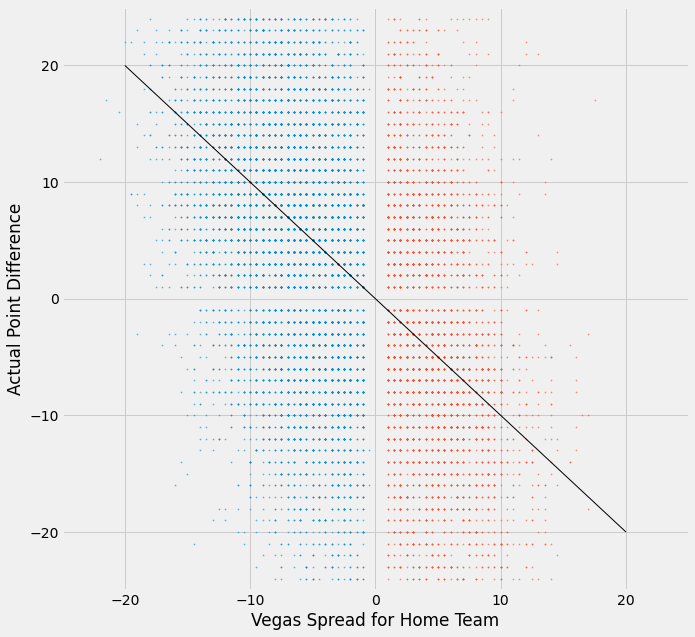

In [25]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,10))
home_fav_x = full_df_ewm_19.loc[full_df_ewm_19['home_spread_mode'] < 0, 'home_spread_mode']
home_fav_y = full_df_ewm_19.loc[full_df_ewm_19['home_spread_mode'] < 0, 'point_diff_team']
away_fav_x = full_df_ewm_19.loc[full_df_ewm_19['home_spread_mode'] > 0, 'home_spread_mode']
away_fav_y = full_df_ewm_19.loc[full_df_ewm_19['home_spread_mode'] > 0, 'point_diff_team']

ax.scatter(home_fav_x, home_fav_y, marker='o', s=1.5, alpha=0.5)
ax.scatter(away_fav_x, away_fav_y, marker='o', s=1.5, alpha=0.5)
ax.plot(np.linspace(-20,20,100), -np.linspace(-20,20,100), linewidth=1, c='black')
ax.set_xlabel('Vegas Spread for Home Team')
ax.set_ylabel('Actual Point Difference')
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

## Helper Functions for Bet Simulations

In [26]:
def simulate_bets(selected_bets, unit_size=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [27]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [58]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_DATE', 'home_spread_mode', 'point_diff_team']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['prob'] = test_probs[:, 1]
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['prob']>0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] != 0]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/100))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-108)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_thresholds = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best thresholds:", best_thresholds)
        select_bets =  betting_df.loc[abs(betting_df['confidence_preds']) > best_thresholds]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
    
    return select_bets, confidence_thresholds
    



In [29]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_confidence_thresholds(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = final_df_ewm_19.loc[test_indices, ['GAME_DATE', 'home_spread_mode', 'point_diff_team']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['confidence_preds'] = test_preds
    betting_df['home_cover'] = ((betting_df['point_diff_team'] + betting_df['spread']) > 0).astype(int)
    betting_df['bet_home'] = (betting_df['confidence_preds'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    confidence_threshold = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for i in range(1, 1000):
        select_bets = betting_df.loc[abs(betting_df['confidence_preds']) > i/100]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_threshold.append(i/100)
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-108)
        expected_profits.append(expected_profit)
        

    confidence_thresholds = pd.DataFrame({'confidence_thresholds':confidence_threshold, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profits':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('expected_profits', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_thresholds = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best thresholds:", best_thresholds)
        select_bets =  betting_df.loc[abs(betting_df['confidence_preds']) > best_thresholds]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
   
    
    return select_bets, confidence_thresholds
    

In [30]:
# Find ranges of model probability where the win percentage is higher than 52.8

def find_optimal_spreads(test_preds, test_indices):
    betting_df = final_df[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_15:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['preds'] = lr_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['preds'] + betting_df['spread'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    betting_df['model_spread_diff'] = betting_df['preds'] + betting_df['spread']
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df



In [31]:
def bet_selector(test_preds, test_indices, low, high):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    results = full_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 
                                          'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    selected_bets = betting_df.loc[abs(betting_df['confidence']).between(low, high)]
    return selected_bets


In [32]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID       TEAM_ID TEAM_ABBREVIATION  \
0         2006-07    22006.0  1.610613e+09               IND   
1         2006-07    22006.0  1.610613e+09               HOU   
2         2006-07    22006.0  1.610613e+09               POR   
3         2006-07    22006.0  1.610613e+09               LAL   
4         2006-07    22006.0  1.610613e+09               CLE   
...           ...        ...           ...               ...   
16475     2019-20    42019.0  1.610613e+09               LAL   
16476     2019-20    42019.0  1.610613e+09               MIA   
16477     2019-20    42019.0  1.610613e+09               MIA   
16478     2019-20    42019.0  1.610613e+09               LAL   
16479     2019-20    42019.0  1.610613e+09               MIA   

                    TEAM_NAME     GAME_ID            GAME_DATE      MATCHUP  \
0              Indiana Pacers  20600076.0  2006-11-10 00:00:00  IND vs. ORL   
1             Houston Rockets  20600079.0  2006-11-10 00:00:00  HOU vs. NYK   
2      Portland Trail Blazers  20600080.0  2006-11-10 00:00:00  POR vs. NOP   
3          Los Angeles Lakers  20600081.0  2006-11-10 00:00:00  LAL vs. DET   
4         Cleveland Cavaliers  20600083.0  2006-11-11 00:00:00  CLE vs. BOS   
...                       ...         ...                  ...          ...   
16475      Los Angeles Lakers  41900402.0  2020-10-02 00:00:00  LAL vs. MIA   
16476              Miami Heat  41900403.0  2020-10-04 00:00:00  MIA vs. LAL   
16477              Miami Heat  41900404.0  2020-10-06 00:00:00  MIA vs. LAL   
16478      Los Angeles Lakers  41900405.0  2020-10-09 00:00:00  LAL vs. MIA   
16479              Miami Heat  41900406.0  2020-10-11 00:00:00  MIA vs. LAL   

       HOME_GAME  SCORE_team  point_diff_team  WL_team  MIN_team  \
0            1.0        93.0             10.0      1.0     240.0   
1            1.0       103.0              9.0      1.0     240.0   
2            1.0        92.0              1.0      1.0     240.0   
3            1.0        83.0            -14.0      0.0     240.0   
4            1.0        94.0              1.0      1.0     240.0   
...          ...         ...              ...      ...       ...   
16475        1.0       124.0             10.0      1.0     240.0   
16476        1.0       115.0             11.0      1.0     240.0   
16477        1.0        96.0             -6.0      0.0     240.0   
16478        1.0       108.0             -3.0      0.0     240.0   
16479        1.0        93.0            -13.0      0.0     240.0   

       home_spread_mode  WL_record_diff  ATS_record_diff  RECORD_team_diff  \
0                  -5.5        0.000000         0.400000         -0.046397   
1                 -10.5        0.200000         0.200000          0.237577   
2                   2.5       -0.200000        -0.200000         -0.153598   
3                  -5.5        0.266667        -0.266667          0.237894   
4                 -11.0        0.400000         0.400000          0.362653   
...                 ...             ...              ...               ...   
16475             -11.0        0.142731         0.022231          0.310655   
16476               9.5       -0.014141        -0.000758         -0.127136   
16477               7.5       -0.002840         0.010372         -0.014414   
16478              -7.5       -0.005556        -0.011111         -0.052764   
16479               5.5       -0.117917         0.054005         -0.147510   

       team_covered_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0               0.417572       -0.575810        7.261337        1.148934   
1               0.237577       -4.323655      -10.223951        1.990916   
2              -0.094039       -2.149081       -9.286709       -0.488364   
3              -0.329542        3.092239       -3.338606        0.840770   
4               0.422212       -0.837049        0.993382       -0.295109   
...                  ...             ...             ...             ...   
16

#### Test Model Per Season

In [33]:
def test_model_per_season(df, model, feature_names, test_seasons_idxs, threshold):
    df = df.copy(deep=True)
    
    X = df[feature_names]
    y = df['point_diff_team'] + df['home_spread_mode']
    
    result_dfs = []
    for i in range(len(test_seasons_idxs)):
        X_train = X.loc[:test_seasons_idxs[i][0], :]
        X_test = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1], :]
        y_train = y.loc[:test_seasons_idxs[i][0]]
        y_test = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]

        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)

        betting_results = df.loc[X_test.index, ['GAME_DATE', 'MATCHUP', 'point_diff_team', 'home_spread_mode']]
        betting_results.rename(columns={'point_diff_team':'point_diff',
                                       'home_spread_mode':'spread'}, inplace=True)

        betting_results['model_preds'] = preds
        betting_results['bet_home'] = (betting_results['model_preds'] > 0).astype(int)
        betting_results['home_cover'] = ((betting_results['point_diff'] + betting_results['spread']) > 0).astype(int)
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['point_diff'] + betting_results['spread'] != 0]

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        select_bets = betting_results.loc[abs(betting_results['model_preds']) > threshold]

        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

In [34]:
def create_betting_df(df, hd_preds, hf_preds, test_indices):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_DATE', 'home_spread_mode', 'point_diff_team']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['confidence_preds'] = 0
    betting_df.loc[betting_df['spread'] >= 0, 'confidence_preds'] = hd_preds
    betting_df.loc[betting_df['spread'] < 0, 'confidence_preds'] = hf_preds

    betting_df['home_cover'] = ((betting_df['point_diff_team'] + betting_df['spread']) > 0).astype(int)
    betting_df['bet_home'] = (betting_df['confidence_preds'] > 0).astype(int)

    betting_df = betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] != 0]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    return betting_df

## Create Features Sets

### Features EWM

In [35]:
final_df_ewm_19 = full_df_ewm_19

In [38]:
final_df_ewm_19.iloc[:, 12:]

MIN_team  home_spread_mode  WL_record_diff  ATS_record_diff  \
0         240.0              -5.5        0.000000         0.400000   
1         240.0             -10.5        0.200000         0.200000   
2         240.0               2.5       -0.200000        -0.200000   
3         240.0              -5.5        0.266667        -0.266667   
4         240.0             -11.0        0.400000         0.400000   
...         ...               ...             ...              ...   
16475     240.0             -11.0        0.142731         0.022231   
16476     240.0               9.5       -0.014141        -0.000758   
16477     240.0               7.5       -0.002840         0.010372   
16478     240.0              -7.5       -0.005556        -0.011111   
16479     240.0               5.5       -0.117917         0.054005   

       RECORD_team_diff  team_covered_diff  FG2M_team_diff  FG2A_team_diff  \
0             -0.046397           0.417572       -0.575810        7.261337   
1              0.237577           0.237577       -4.323655      -10.223951   
2             -0.153598          -0.094039       -2.149081       -9.286709   
3              0.237894          -0.329542        3.092239       -3.338606   
4              0.362653           0.422212       -0.837049        0.993382   
...                 ...                ...             ...             ...   
16475          0.310655          -0.026435        1.893892        1.465442   
16476         -0.127136          -0.024549        0.063427        0.396260   
16477         -0.014414           0.077914        0.257095       -0.443436   
16478         -0.052764          -0.096434       -1.785597       -2.437519   
16479         -0.147510           0.274224       -3.573538       -3.072443   

       FG3M_team_diff  FG3A_team_diff  FTM_team_diff  FTA_team_diff  \
0            1.148934        6.622988      -0.816903      -4.248272   
1            1.990916        4.518327      -3.477449      -5.215013   
2           -0.488364        1.207028      -0.154331      -2.195258   
3            0.840770        1.863964      -1.172882       0.353975   
4           -0.295109        0.361725      -1.696637       0.738712   
...               ...             ...            ...            ...   
16475       -0.131455        1.094112       1.898138       3.387852   
16476       -0.378056       -1.247930      -0.056853      -0.383224   
16477       -0.240237       -1.223132       0.948919       0.555183   
16478        0.412458        1.336169       0.113484      -0.108204   
16479        0.509406        1.007204       1.992574      -0.249530   

       OREB_team_diff  DREB_team_diff  REB_team_diff  AST_team_diff  \
0            4.494689        1.648116       6.142805       4.424190   
1           -0.176992       -1.397329      -1.574321       3.763937   
2           -5.292423       -1.873117      -7.165539      -3.111133   
3            0.096077       -1.606446      -1.510369       3.047261   
4            4.099192       -1.080267       3.018925       0.479500   
...               ...             ...            ...            ...   
16475        0.875210        2.236775       3.111986       1.855750   
16476       -0.464159       -0.626145      -1.090304       0.100848   
16477       -0.617749       -0.263501      -0.881250       0.290780   
16478        0.038823       -0.265130      -0.226307      -0.379308   
16479       -3.098371       -0.477041      -3.575412      -0.743253   

       STL_team_diff  BLK_team_diff  TOV_team_diff  PF_team_diff  \
0           0.493932       1.449000      -3.451833     -1.093185   
1           2.460282      -0.158091      -1.194403     -4.265342   
2           1.586774       0.779029      -0.666626      0.873971   
3           1.152555      -0.571463       6.557348     -1.924089   
4          -1.684477       0.595053      -4.478328     -3.298234   
...              ...            ...            ...           ...   
16475       1.695600       1.887259       0.415

In [40]:
final_df_ewm_19 = final_df_ewm_19.sort_values('GAME_DATE').reset_index(drop=True)
final_df_ewm_19 = final_df_ewm_19.dropna()

cutoff_16 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2016-17'].index[0]
cutoff_18 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2018-19'].index[0]

final_hf = final_df_ewm_19.loc[final_df_ewm_19['home_spread_mode'] < 0]
cutoff_16_hf = final_hf.loc[final_hf['SEASON_YEAR'] == '2016-17'].index[0]
cutoff_18_hf = final_hf.loc[final_hf['SEASON_YEAR'] == '2018-19'].index[0]

features_hf = final_hf.iloc[:, 13:]
features_hf = features_hf.drop(columns=['home_rating_n', 'away_rating_n'])

y_hf = (final_hf['home_spread_mode'] + final_hf['point_diff_team'] > 0).astype(int)

final_hd = final_df_ewm_19.loc[final_df_ewm_19['home_spread_mode'] >= 0]
cutoff_16_hd = final_hd.loc[final_hd['SEASON_YEAR'] == '2016-17'].index[0]
cutoff_18_hd = final_hd.loc[final_hd['SEASON_YEAR'] == '2018-19'].index[0]

features_hd = final_hd.iloc[:, 13:]
features_hd = features_hd.drop(columns=['home_rating_n', 'away_rating_n'])

y_hd = (final_hd['home_spread_mode'] + final_hd['point_diff_team'] > 0).astype(int)


print('home_favorite:', features_hf.shape, 'home_dog:', features_hd.shape)

X_train_hf1 = features_hf.loc[:cutoff_16_hf]
X_test_hf1 = features_hf.loc[cutoff_16_hf:cutoff_18_hf]
y_train_hf1 = y_hf.loc[:cutoff_16_hf]
y_test_hf1 = y_hf.loc[cutoff_16_hf:cutoff_18_hf]


X_train_hf2 = features_hf.loc[:cutoff_18_hf]
X_test_hf2 = features_hf.loc[cutoff_18_hf:]
y_train_hf2 = y_hf.loc[:cutoff_18_hf]
y_test_hf2 = y_hf.loc[cutoff_18_hf:]

test_indices_hf1 = X_test_hf1.index
test_indices_hf2 = X_test_hf2.index

X_train_hd1 = features_hd.loc[:cutoff_16_hd]
X_test_hd1 = features_hd.loc[cutoff_16_hd:cutoff_18_hd]
y_train_hd1 = y_hd.loc[:cutoff_16_hd]
y_test_hd1 = y_hd.loc[cutoff_16_hd:cutoff_18_hd]

X_train_hd2 = features_hd.loc[:cutoff_18_hd]
X_test_hd2 = features_hd.loc[cutoff_18_hd:]
y_train_hd2 = y_hd.loc[:cutoff_18_hd]
y_test_hd2 = y_hd.loc[cutoff_18_hd:]


test_indices_hd1 = X_test_hd1.index
test_indices_hd2 = X_test_hd2.index

# spread_point_diff_train_ewm_19 = spread_point_diff_ewm_19[:cutoff_16]
# spread_point_diff_test_ewm_19 = spread_point_diff_ewm_19[cutoff_16:]

# test_indices_16 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2016-17'].index
# test_indices_17 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2017-18'].index
# test_indices_18 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2018-19'].index
# test_indices_19 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2019-20'].index

test_indices2 = final_df_ewm_19.loc[cutoff_18:].index

# print(X_train_ewm_19.shape, X_test_ewm_19.shape, spread_point_diff_train_ewm_19.shape, spread_point_diff_test_ewm_19.shape)

print(cutoff_16_hd, cutoff_16_hf, cutoff_16)
print(cutoff_18_hd, cutoff_18_hf, cutoff_18)

print(X_train_hf1.shape, X_test_hf1.shape, y_train_hf1.shape, y_test_hf1.shape)
print(X_train_hf2.shape, X_test_hf2.shape, y_train_hf2.shape, y_test_hf2.shape)

print(X_train_hd1.shape, X_test_hd1.shape, y_train_hd1.shape, y_test_hd1.shape)
print(X_train_hd2.shape, X_test_hd2.shape, y_train_hd2.shape, y_test_hd2.shape)


print(final_df_ewm_19.shape[0])
test_indices2

home_favorite: (11152, 90) home_dog: (5328, 90)
11772 11774 11772
14225 14227 14225
(8087, 90) (1616, 90) (8087,) (1616,)
(9702, 90) (1451, 90) (9702,) (1451,)
(3687, 90) (839, 90) (3687,) (839,)
(4525, 90) (804, 90) (4525,) (804,)
16480


Int64Index([14225, 14226, 14227, 14228, 14229, 14230, 14231, 14232, 14233,
            14234,
            ...
            16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478,
            16479],
           dtype='int64', length=2255)

In [42]:
print((final_df_ewm_19.loc[test_indices_hf1, 'home_spread_mode'] < 0).sum())
print((final_df_ewm_19.loc[test_indices_hd1, 'home_spread_mode'] >= 0).sum())


1616
839


In [38]:
final_df_ewm_19.iloc[:, 13:]

home_spread_mode  WL_record_diff  ATS_record_diff  RECORD_team_diff  \
0                  -5.5        0.000000         0.400000         -0.046397   
1                 -10.5        0.200000         0.200000          0.237577   
2                   2.5       -0.200000        -0.200000         -0.153598   
3                  -5.5        0.266667        -0.266667          0.237894   
4                 -11.0        0.400000         0.400000          0.362653   
...                 ...             ...              ...               ...   
16475             -11.0        0.142731         0.022231          0.310655   
16476               9.5       -0.014141        -0.000758         -0.127136   
16477               7.5       -0.002840         0.010372         -0.014414   
16478              -7.5       -0.005556        -0.011111         -0.052764   
16479               5.5       -0.117917         0.054005         -0.147510   

       team_covered_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0               0.417572       -0.575810        7.261337        1.148934   
1               0.237577       -4.323655      -10.223951        1.990916   
2              -0.094039       -2.149081       -9.286709       -0.488364   
3              -0.329542        3.092239       -3.338606        0.840770   
4               0.422212       -0.837049        0.993382       -0.295109   
...                  ...             ...             ...             ...   
16475          -0.026435        1.893892        1.465442       -0.131455   
16476          -0.024549        0.063427        0.396260       -0.378056   
16477           0.077914        0.257095       -0.443436       -0.240237   
16478          -0.096434       -1.785597       -2.437519        0.412458   
16479           0.274224       -3.573538       -3.072443        0.509406   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0            6.622988      -0.816903      -4.248272        4.494689   
1            4.518327      -3.477449      -5.215013       -0.176992   
2            1.207028      -0.154331      -2.195258       -5.292423   
3            1.863964      -1.172882       0.353975        0.096077   
4            0.361725      -1.696637       0.738712        4.099192   
...               ...            ...            ...             ...   
16475        1.094112       1.898138       3.387852        0.875210   
16476       -1.247930      -0.056853      -0.383224       -0.464159   
16477       -1.223132       0.948919       0.555183       -0.617749   
16478        1.336169       0.113484      -0.108204        0.038823   
16479        1.007204       1.992574      -0.249530       -3.098371   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
0            1.648116       6.142805       4.424190       0.493932   
1           -1.397329      -1.574321       3.763937       2.460282   
2           -1.873117      -7.165539      -3.111133       1.586774   
3           -1.606446      -1.510369       3.047261       1.152555   
4           -1.080267       3.018925       0.479500      -1.684477   
...               ...            ...            ...            ...   
16475        2.236775       3.111986       1.855750       1.695600   
16476       -0.626145      -1.090304       0.100848      -0.813941   
16477       -0.263501      -0.881250       0.290780      -0.332509   
16478       -0.265130      -0.226307      -0.379308      -0.325325   
16479       -0.477041      -3.575412      -0.743253      -1.373830   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
0           1.449000      -3.451833     -1.093185       1.478279   
1          -0.158091      -1.194403     -4.265342      -6.152011   
2           0.779029      -0.666626      0.873971      -5.917584   
3          -0.571463       6.557348     -1.924089       7.533905   
4           0.595053      -4.478328     -3.298234      -4.256062   
...              ...            ...           ...      

In [43]:
features = final_df_ewm_19.iloc[:, 13:].drop(columns=['home_rating_n', 'away_rating_n'])
features
y = final_df_ewm_19['point_diff_team']

X_train1 = features.iloc[:cutoff_16]
X_train2 = features.iloc[:cutoff_18]

X_test1 = features.iloc[cutoff_16:cutoff_18]
X_test2 = features.iloc[cutoff_18:]

y_train1 = y[:cutoff_16]
y_train2 = y[:cutoff_18]

y_test1 = y[cutoff_16:cutoff_18]
y_test2 = y[cutoff_18:]

print(X_train1.shape, X_train2.shape, X_test1.shape, X_test2.shape, 
      y_train1.shape, y_train2.shape, y_test1.shape, y_test2.shape)

(11772, 90) (14225, 90) (2453, 90) (2255, 90) (11772,) (14225,) (2453,) (2255,)


In [44]:
features

home_spread_mode  WL_record_diff  ATS_record_diff  RECORD_team_diff  \
0                  -5.5        0.000000         0.400000         -0.046397   
1                 -10.5        0.200000         0.200000          0.237577   
2                   2.5       -0.200000        -0.200000         -0.153598   
3                  -5.5        0.266667        -0.266667          0.237894   
4                 -11.0        0.400000         0.400000          0.362653   
...                 ...             ...              ...               ...   
16475             -11.0        0.142731         0.022231          0.310655   
16476               9.5       -0.014141        -0.000758         -0.127136   
16477               7.5       -0.002840         0.010372         -0.014414   
16478              -7.5       -0.005556        -0.011111         -0.052764   
16479               5.5       -0.117917         0.054005         -0.147510   

       team_covered_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0               0.417572       -0.575810        7.261337        1.148934   
1               0.237577       -4.323655      -10.223951        1.990916   
2              -0.094039       -2.149081       -9.286709       -0.488364   
3              -0.329542        3.092239       -3.338606        0.840770   
4               0.422212       -0.837049        0.993382       -0.295109   
...                  ...             ...             ...             ...   
16475          -0.026435        1.893892        1.465442       -0.131455   
16476          -0.024549        0.063427        0.396260       -0.378056   
16477           0.077914        0.257095       -0.443436       -0.240237   
16478          -0.096434       -1.785597       -2.437519        0.412458   
16479           0.274224       -3.573538       -3.072443        0.509406   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0            6.622988      -0.816903      -4.248272        4.494689   
1            4.518327      -3.477449      -5.215013       -0.176992   
2            1.207028      -0.154331      -2.195258       -5.292423   
3            1.863964      -1.172882       0.353975        0.096077   
4            0.361725      -1.696637       0.738712        4.099192   
...               ...            ...            ...             ...   
16475        1.094112       1.898138       3.387852        0.875210   
16476       -1.247930      -0.056853      -0.383224       -0.464159   
16477       -1.223132       0.948919       0.555183       -0.617749   
16478        1.336169       0.113484      -0.108204        0.038823   
16479        1.007204       1.992574      -0.249530       -3.098371   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
0            1.648116       6.142805       4.424190       0.493932   
1           -1.397329      -1.574321       3.763937       2.460282   
2           -1.873117      -7.165539      -3.111133       1.586774   
3           -1.606446      -1.510369       3.047261       1.152555   
4           -1.080267       3.018925       0.479500      -1.684477   
...               ...            ...            ...            ...   
16475        2.236775       3.111986       1.855750       1.695600   
16476       -0.626145      -1.090304       0.100848      -0.813941   
16477       -0.263501      -0.881250       0.290780      -0.332509   
16478       -0.265130      -0.226307      -0.379308      -0.325325   
16479       -0.477041      -3.575412      -0.743253      -1.373830   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
0           1.449000      -3.451833     -1.093185       1.478279   
1          -0.158091      -1.194403     -4.265342      -6.152011   
2           0.779029      -0.666626      0.873971      -5.917584   
3          -0.571463       6.557348     -1.924089       7.533905   
4           0.595053      -4.478328     -3.298234      -4.256062   
...              ...            ...           ...      

### Define Custom Scorer

In [40]:
from sklearn.metrics import make_scorer

def my_scorer(y_true, y_pred):
#     residual = y_pred - y_true
#     condlist = [np.where(y_true<0, residual**2, 10*residual**2), np.where(y_true<0, 10*residual**2, residual**2)]
#     score = np.where(y_pred<0, condlist[0], condlist[1])
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    return accuracy
    
bet_accuracy = make_scorer(my_scorer)

In [45]:
tscv = TimeSeriesSplit()

## Training Models

### Logistic Regression

#### Separate Models for HD and HF

In [57]:
lr_pipeline_hd = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', max_iter=10000, C=.002))])

lr_pipeline_hf = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', max_iter=10000, C=.006))])


params = {
#       'logreg__C':np.logspace(-6, 3, 20),
    'logreg__penalty':['elasticnet'],
    'logreg__l1_ratio':np.linspace(0.05, 0.95, 19)
}

lr_cv_hd = GridSearchCV(lr_pipeline_hd, param_grid = params, cv=tscv)

lr_cv_hf = GridSearchCV(lr_pipeline_hf, param_grid = params, cv=tscv)

lr_cv_hd.fit(X_train_hd1, y_train_hd1)
lr_cv_hf.fit(X_train_hf1, y_train_hf1)

best_lr_pipeline_hd = lr_cv_hd.best_estimator_
best_lr_pipeline_hf = lr_cv_hf.best_estimator_

print(best_lr_pipeline_hd)
print(best_lr_pipeline_hf)

lr_preds_hd = best_lr_pipeline_hd.predict(X_test_hd1)
lr_preds_hf = best_lr_pipeline_hf.predict(X_test_hf1)

accuracy_hd = accuracy_score(y_test_hd1, lr_preds_hd)
accuracy_hf = accuracy_score(y_test_hf1, lr_preds_hf)

brier_hd = brier_score_loss(y_test_hd1, lr_preds_hd)
brier_hf = brier_score_loss(y_test_hf1, lr_preds_hf)

hamming_hd = hamming_loss(y_test_hd1, lr_preds_hd)
hamming_hf = hamming_loss(y_test_hf1, lr_preds_hf)

precision_hd = brier_score_loss(y_test_hd1, lr_preds_hd)
precision_hf = brier_score_loss(y_test_hf1, lr_preds_hf)

print("accuracy_hd:", accuracy_hd, "accuracy_hf", accuracy_hf)
print("brier_hd:", brier_hd, "brier_hf", brier_hf)
print("hamming_hd:", hamming_hd, "hamming_hf", hamming_hf)
print("precision_hd:", precision_hd, "precision_hf", precision_hf)




Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.002, l1_ratio=0.1, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.006, l1_ratio=0.05, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])
accuracy_hd: 0.49821215733015495 accuracy_hf 0.5272277227722773
brier_hd: 0.5017878426698451 brier_hf 0.47277227722772275
hamming_hd: 0.5017878426698451 hamming_hf 0.47277227722772275
precision_hd: 0.5017878426698451 precision_hf 0.47277227722772275


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


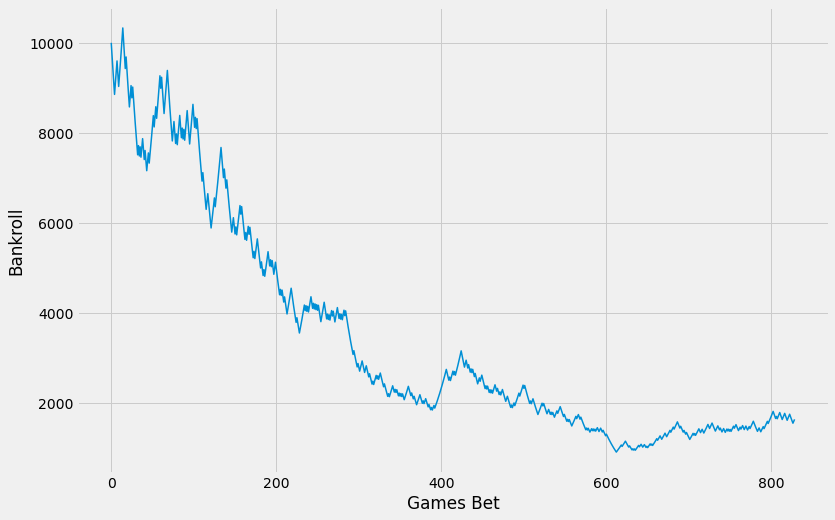

min balance: 901.5092342941567 
max balance: 10330.384162423055 
final balance: 1673.4145733462015 
win percentage 49.34


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


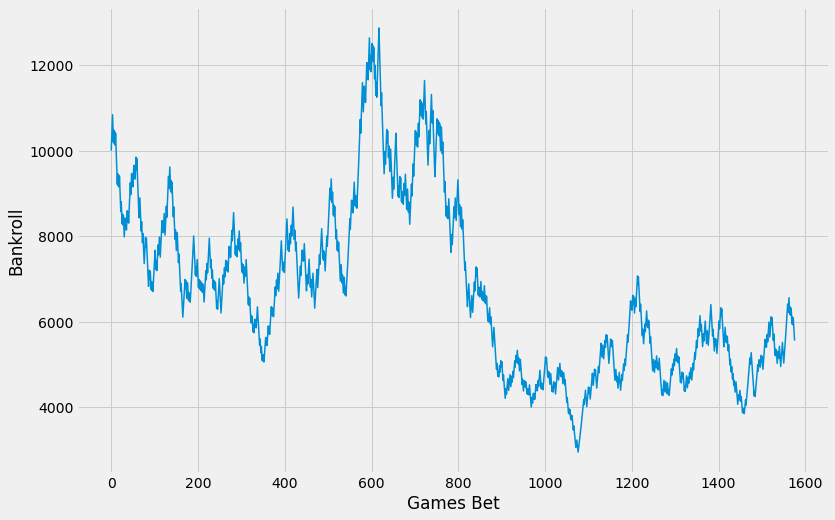

min balance: 2945.0949627385144 
max balance: 12871.110827506527 
final balance: 5385.63697930343 
win percentage 52.410000000000004


index            GAME_DATE  spread  point_diff_team      prob  \
0     11774  2016-11-04 00:00:00    -2.5             -1.0  0.434295   
1     11775  2016-11-05 00:00:00    -3.5             17.0  0.533790   
2     11776  2016-11-05 00:00:00    -3.0             15.0  0.513009   
3     11777  2016-11-05 00:00:00    -3.5             26.0  0.495934   
4     11778  2016-11-05 00:00:00    -4.5            -24.0  0.579345   
...     ...                  ...     ...              ...       ...   
1571  14218  2018-05-26 00:00:00   -12.5             29.0  0.518710   
1572  14219  2018-05-27 00:00:00    -3.5             -8.0  0.554475   
1573  14221  2018-05-31 00:00:00   -13.0             10.0  0.513373   
1574  14222  2018-06-03 00:00:00   -11.0             19.0  0.458477   
1575  14227  2018-10-27 00:00:00    -7.0              2.0  0.552598   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0              0         0        1  10000.000000  10272.727273  300.000000  
1              1         1        1  10272.727273  10552.892562  308.181818  
2              1         1        1  10552.892562  10840.698723  316.586777  
3              1         0        0  10840.698723  10515.477761  325.220962  
4              0         1        0  10515.477761  10200.013428  315.464333  
...          ...       ...      ...           ...           ...         ...  
1571           1         1        1   5921.945155   6083.452750  177.658355  
1572           0         1        0   6083.452750   5900.949167  182.503582  
1573           0         1        0   5900.949167   5723.920692  177.028475  
1574           1         0        0   5723.920692   5552.203071  171.717621  
1575           0         1        0   5552.203071   5385.636979  166.566092  

[1576 rows x 11 columns]

In [61]:
lr_preds_hd = best_lr_pipeline_hd.predict_proba(X_test_hd1)
lr_preds_hf = best_lr_pipeline_hf.predict_proba(X_test_hf1)

select_bets_lr_hd, bet_thresholds_lr_hd = find_optimal_threshold(final_df_ewm_19, lr_preds_hd, test_indices_hd1)
simulate_bets(select_bets_lr_hd)


select_bets_lr_hf, bet_thresholds_lr_hf = find_optimal_threshold(final_df_ewm_19, lr_preds_hf, test_indices_hf1)
simulate_bets(select_bets_lr_hf)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


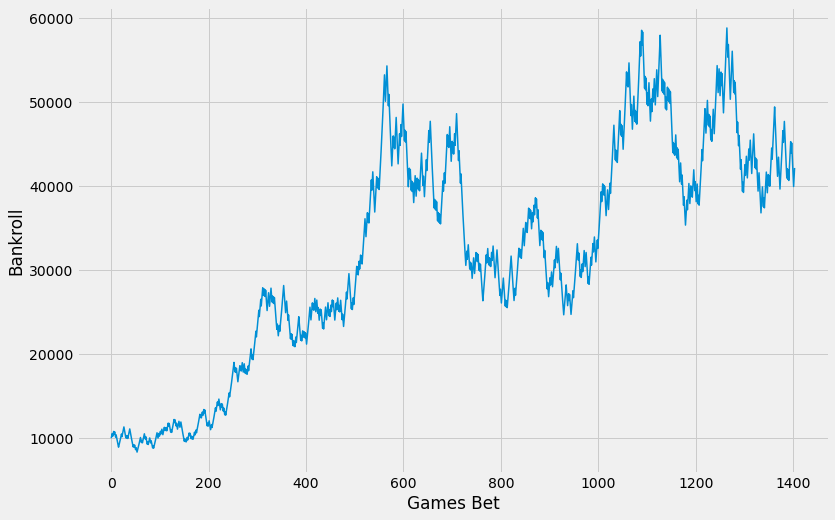

min balance: 8351.269860655406 
max balance: 58764.76475183001 
final balance: 43274.04170187406 
win percentage 54.910000000000004


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11773  2016-11-04 00:00:00    11.5             20.0          2.221860   
1     11777  2016-11-05 00:00:00    -3.5             26.0          5.410746   
2     11782  2016-11-06 00:00:00    -4.0             11.0         -6.022581   
3     11786  2016-11-07 00:00:00   -16.5             10.0         -3.967054   
4     11789  2016-11-08 00:00:00    -4.0            -12.0         -6.365064   
...     ...                  ...     ...              ...               ...   
1399  16445  2020-09-04 00:00:00    -5.5            -15.0          3.420366   
1400  16459  2020-09-11 00:00:00     3.5             -5.0          4.959952   
1401  16461  2020-09-13 00:00:00     8.5             13.0          5.533572   
1402  16469  2020-09-23 00:00:00     3.5              3.0          3.307046   
1403  16473  2020-09-27 00:00:00     3.0             12.0          4.851701   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n     bet_size  
0              1         1        1  10000.000000  10272.727273   300.000000  
1              1         1        1  10272.727273  10552.892562   308.181818  
2              1         0        0  10552.892562  10236.305785   316.586777  
3              0         0        1  10236.305785  10515.477761   307.089174  
4              0         0        1  10515.477761  10802.263518   315.464333  
...          ...       ...      ...           ...           ...          ...  
1399           0         1        0  42425.475227  41152.710971  1272.764257  
1400           0         1        0  41152.710971  39918.129641  1234.581329  
1401           1         1        1  39918.129641  41006.805904  1197.543889  
1402           1         1        1  41006.805904  42125.173338  1230.204177  
1403           1         1        1  42125.173338  43274.041702  1263.755200  

[1404 rows x 11 columns]

In [143]:
betting_df_lr = create_betting_df(final_df_ewm_19, lr_preds_hd, lr_preds_hf, test_indices)

select_bets_lr = betting_df_lr.loc[((betting_df_lr['spread'] >= 0) & (abs(betting_df_lr['confidence_preds']) >= 1.89))
                 | ((betting_df_lr['spread'] < 0) & (abs(betting_df_lr['confidence_preds']) >= 2.54))]

simulate_bets(select_bets_lr)

In [95]:
lr_feature_names = X_train_hd.columns
lr_hf_coefs = lr_pipeline_hf.named_steps['linreg'].coef_
lr_hd_coefs = lr_pipeline_hd.named_steps['linreg'].coef_

coef_df = pd.DataFrame({'feature':lr_feature_names,
                       'lr_home_fav_coef':lr_hf_coefs,
                       'lr_home_dog_coef':lr_hd_coefs})
coef_df.sort_values('lr_home_fav_coef', ascending=False)

feature  lr_home_fav_coef  lr_home_dog_coef
7           FG3M_team_diff      6.686097e+13      4.637855e+13
13           REB_team_diff      6.042279e+13      5.185207e+12
5           FG2M_team_diff      5.746357e+13      4.120873e+13
46           DREB_opp_diff      5.473229e+13     -4.625568e+13
45           OREB_opp_diff      3.542222e+13     -2.909411e+13
9            FTM_team_diff      3.093430e+13      2.221810e+13
39           FG2M_opp_diff      1.815524e+13     -6.932713e+12
41           FG3M_opp_diff      1.434073e+13     -5.341155e+12
76        REB_PCT_opp_diff      1.315197e+13     -6.083514e+12
75       REB_PCT_team_diff      1.315197e+13     -6.083514e+12
43            FTM_opp_diff      1.022411e+13     -3.813541e+12
55   E_OFF_RATING_opp_diff      2.115458e+12      7.626751e+12
22    OFF_RATING_team_diff      2.015965e+12      8.265085e+13
21  E_OFF_RATING_team_diff      1.492246e+12      4.770309e+11
25  E_NET_RATING_team_diff      1.015201e+12     -3.497141e+13
59   E_NET_RATING_opp_diff      1.015201e+12     -3.497141e+13
60     NET_RATING_opp_diff      1.267057e+11     -5.384188e+12
26    NET_RATING_team_diff      1.267057e+11     -5.384188e+12
24    DEF_RATING_team_diff      1.130589e+11     -1.120584e+13
88           away_rating_i      3.717812e+02     -3.017480e+01
89            elo_MOV_pred      3.656094e+02     -2.627734e+01
6           FG2A_team_diff      1.143471e+01     -4.765790e+00
8           FG3A_team_diff      9.867198e+00     -3.615996e+00
17           TOV_team_diff      7.751465e+00      8.149414e-01
14           AST_team_diff      6.587891e+00      1.245117e+00
79       EFG_PCT_team_diff      4.712891e+00     -5.374023e+00
35       AST_3PM_team_diff      4.043945e+00      3.466797e-01
10           FTA_team_diff      3.140625e+00     -2.024414e+00
40           FG2A_opp_diff      2.429688e+00     -6.948242e+00
84        TOV_PCT_opp_diff      2.083984e+00      4.320312e+00
33       AST_2PM_team_diff      1.867188e+00      9.912109e-01
18            PF_team_diff      1.356445e+00      5.048828e-01
36      UAST_3PM_team_diff      1.290039e+00      6.909180e-02
34      UAST_2PM_team_diff      1.285156e+00      1.316895e+00
31   PTS_OFF_TOV_team_diff      1.149414e+00      1.123047e-01
86           home_elo_pred      1.046875e+00     -8.017578e-01
69        AST_3PM_opp_diff      1.037109e+00      2.037109e+00
42           FG3A_opp_diff      9.257812e-01     -5.611328e+00
49            STL_opp_diff      6.835938e-01     -2.197266e-02
51            TOV_opp_diff      6.430664e-01     -9.167969e+00
67        AST_2PM_opp_diff      4.433594e-01      5.959229e+00
1           WL_record_diff      4.344933e-01     -1.937763e-01
44            FTA_opp_diff      2.246094e-01     -7.687500e+00
2          ATS_record_diff      1.705481e-01     -3.863776e-01
70       UAST_3PM_opp_diff      1.687012e-01      3.808594e-01
85               rest_diff      6.640625e-02      3.125000e-01
0         home_spread_mode     -3.093524e-02      1.625052e-01
65    PTS_OFF_TOV_opp_diff     -9.375000e-02      6.733398e-01
16           BLK_team_diff     -1.054688e-01      1.357422e-01
50            BLK_opp_diff     -1.171875e-01     -3.046875e-01
30        PTS_FB_team_diff     -1.914062e-01      7.382812e-01
4        team_covered_diff     -2.048485e-01      3.652354e-01
15           STL_team_diff     -3.967285e-01     -4.287109e-01
64         PTS_FB_opp_diff     -4.038086e-01     -4.003906e-01
32     PTS_PAINT_team_diff     -5.336914e-01      6.833496e+00
52             PF_opp_diff     -1.095703e+00      1.015625e-01
29    PTS_2PT_MR_team_diff     -1.101074e+00      5.794922e+00
82      AST_RATIO_opp_diff     -1.165039e+00     -2.902344e+00
80        EFG_PCT_opp_diff     -1.167969e+00      1.916162e+01
48            AST_opp_diff     -1.426270e+00      7.021484e-01
68       UAST_2PM_opp_diff     -1.454102e+00      3.910156e+00
63     PTS_2PT_MR_opp_diff     -1.699219e+00     -5.702637e+00
78         TS_PCT_opp_diff     -2.265625e+00     -

### One Model

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.72
num_games_bet: 390
win percetange at threshold: 0.5384615384615384


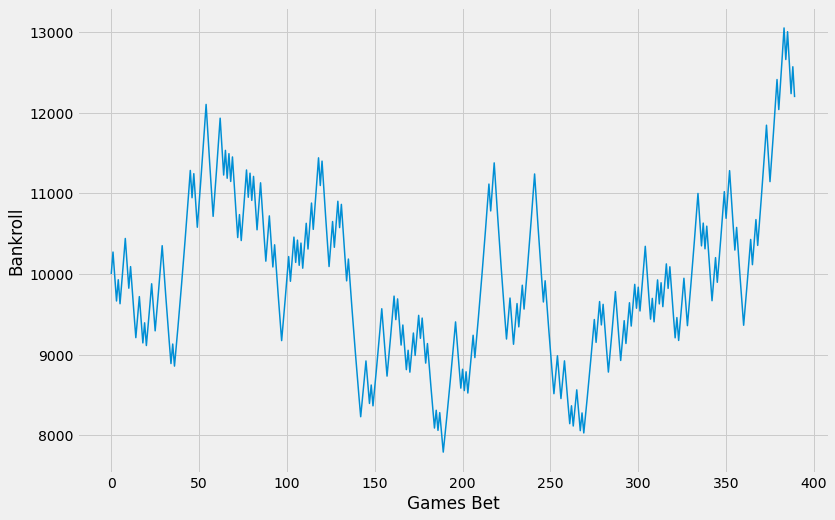

min balance: 7791.195212807984 
max balance: 13052.425655935502 
final balance: 11828.27508628974 
win percentage 53.849999999999994


GAME_DATE  spread  point_diff_team  confidence_preds  \
0    2016-11-05 00:00:00    -3.5             26.0          4.123288   
1    2016-11-06 00:00:00    -3.0             11.0         -5.309729   
2    2016-11-06 00:00:00    -4.0             11.0         -5.668437   
3    2016-11-07 00:00:00   -16.5             10.0         -5.089142   
4    2016-11-08 00:00:00    -6.5              8.0         -6.387031   
..                   ...     ...              ...               ...   
385  2020-03-04 00:00:00    -8.0             21.0         -4.004551   
386  2020-03-04 00:00:00     9.0             -8.0         -5.273559   
387  2020-08-08 00:00:00    -4.5             -5.0         -4.745792   
388  2020-08-14 00:00:00     3.0              8.0         -4.289362   
389  2020-09-02 00:00:00    -5.5              2.0          3.796459   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           1.0         1        1  10000.000000  10272.727273  300.000000  
1           1.0         0        0  10272.727273   9964.545455  308.181818  
2           1.0         0        0   9964.545455   9665.609091  298.936364  
3           0.0         0        1   9665.609091   9929.216612  289.968273  
4           1.0         0        0   9929.216612   9631.340113  297.876498  
..          ...       ...      ...           ...           ...         ...  
385         1.0         0        0  13006.148874  12615.964408  390.184466  
386         1.0         0        0  12615.964408  12237.485476  378.478932  
387         0.0         0        1  12237.485476  12571.235079  367.124564  
388         1.0         0        0  12571.235079  12194.098027  377.137052  
389         0.0         1        0  12194.098027  11828.275086  365.822941  

[390 rows x 10 columns]

In [105]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])


lr_pipeline.fit(X_train_ewm_19, y_train)
lr_preds = lr_pipeline_hf.predict(X_test_ewm_19)


# mse = mean_squared_error(spread_point_diff_test, lr_preds)
# mae = mean_absolute_error(spread_point_diff_test, lr_preds)
# print("mse:", mse, "mae:", mae)

select_bets_lr, bet_thresholds_lr = find_optimal_confidence_thresholds(lr_preds, test_indices)
simulate_bets(select_bets_lr)


### SGD

best_sgd_hd: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.06951927961775606,
                              epsilon=2.3357214690901213, l1_ratio=0.1,
                              loss='huber', penalty='elasticnet'))])
best_sgd_hf: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823,
                              epsilon=2.3357214690901213, l1_ratio=0.7,
                              loss='huber', penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.03
num_games_bet: 55
win percetange at threshold: 0.6363636363636364


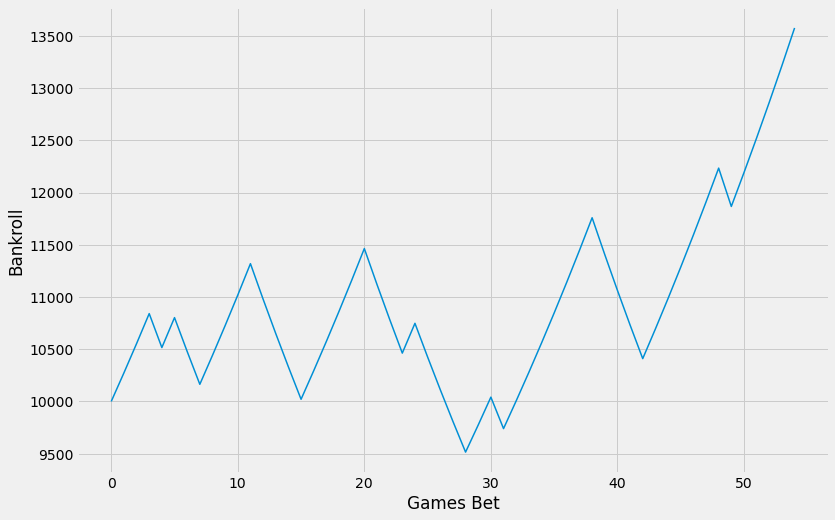

min balance: 9514.914635028077 
max balance: 13945.56861084817 
final balance: 13945.56861084817 
win percentage 63.63999999999999


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 5.42
num_games_bet: 3
win percetange at threshold: 0.6666666666666666


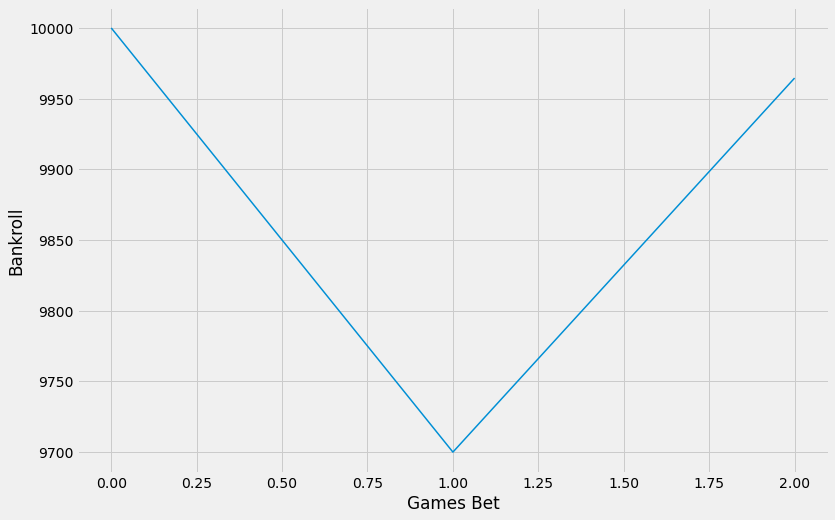

min balance: 9700.0 
max balance: 10236.305785123966 
final balance: 10236.305785123966 
win percentage 66.67


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0  14837  2019-01-21 00:00:00   -11.0             10.0          7.116744   
1  15498  2019-11-08 00:00:00    -4.0             -4.0         -5.718812   
2  15499  2019-11-08 00:00:00    -5.0              3.0         -5.790667   

   home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0         0.0         1        0  10000.000000   9700.000000  300.000000  
1         0.0         0        1   9700.000000   9964.545455  291.000000  
2         0.0         0        1   9964.545455  10236.305785  298.936364

In [42]:
sgd_pipe_hd = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet'))
sgd_pipe_hf = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet'))

params = {
      'sgdregressor__epsilon':np.logspace(-2, 3, 20),
    'sgdregressor__alpha':np.logspace(-4, 2, 20),
    'sgdregressor__l1_ratio':np.linspace(0.05, 1, 20)
}

sgd_cv_hd = GridSearchCV(sgd_pipe_hd, param_grid = params, scoring=bet_accuracy, cv=tscv)

sgd_cv_hf = GridSearchCV(sgd_pipe_hf, param_grid = params, scoring=bet_accuracy, cv=tscv)

sgd_cv_hd.fit(X_train_hd, y_train_hd)
sgd_cv_hf.fit(X_train_hf, y_train_hf)

best_sgd_hd = sgd_cv_hd.best_estimator_
print("best_sgd_hd:", best_sgd_hd)

best_sgd_hf = sgd_cv_hf.best_estimator_
print("best_sgd_hf:", best_sgd_hf)

sgd_preds_hd = best_sgd_hd.predict(X_test_hd)
sgd_preds_hf = best_sgd_hf.predict(X_test_hf)



select_bets_sgd_hd, bet_thresholds_sgd_hd = find_optimal_confidence_thresholds(sgd_preds_hd, test_indices_hd)
simulate_bets(select_bets_sgd_hd)


select_bets_sgd_hf, bet_thresholds_sgd_hf = find_optimal_confidence_thresholds(sgd_preds_hf, test_indices_hf)
simulate_bets(select_bets_sgd_hf)



In [160]:
select_bets_sgd_hf.shape[0] + select_bets_sgd_hd.shape[0]

638

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


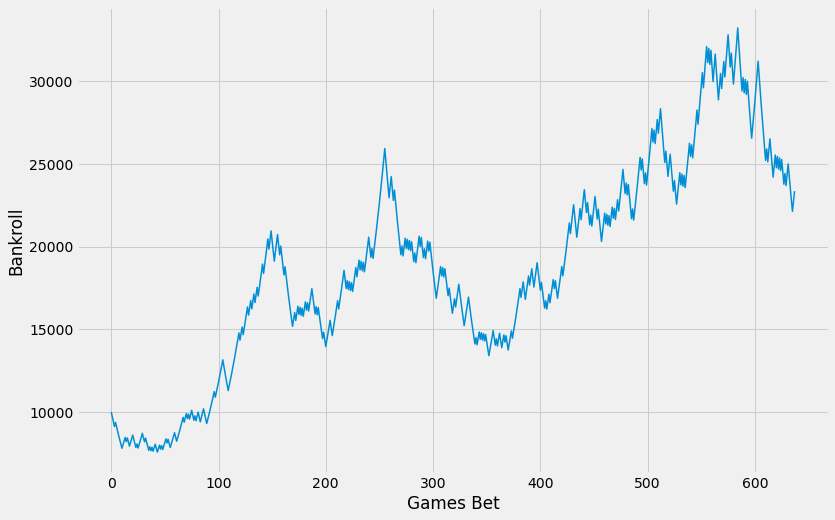

min balance: 7579.438030390443 
max balance: 33207.39246875077 
final balance: 23984.51709173514 
win percentage 55.489999999999995


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11772  2016-11-04 00:00:00     3.5            -14.0          1.981353   
1    11778  2016-11-05 00:00:00    -4.5            -24.0          4.534842   
2    11780  2016-11-06 00:00:00    -3.0             11.0         -3.932365   
3    11789  2016-11-08 00:00:00    -4.0            -12.0         -3.920267   
4    11795  2016-11-09 00:00:00    -1.5             25.0         -5.044546   
..     ...                  ...     ...              ...               ...   
633  16457  2020-09-10 00:00:00     5.5            -10.0          1.760985   
634  16459  2020-09-11 00:00:00     3.5             -5.0          2.801308   
635  16461  2020-09-13 00:00:00     8.5             13.0          2.110119   
636  16469  2020-09-23 00:00:00     3.5              3.0          2.356763   
637  16473  2020-09-27 00:00:00     3.0             12.0          2.061374   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0             0         1        0  10000.000000   9700.000000  300.000000  
1             0         1        0   9700.000000   9409.000000  291.000000  
2             1         0        0   9409.000000   9126.730000  282.270000  
3             0         0        1   9126.730000   9375.640818  273.801900  
4             1         0        0   9375.640818   9094.371594  281.269225  
..          ...       ...      ...           ...           ...         ...  
633           0         1        0  23514.201487  22808.775442  705.426045  
634           0         1        0  22808.775442  22124.512179  684.263263  
635           1         1        1  22124.512179  22727.907965  663.735365  
636           1         1        1  22727.907965  23347.760001  681.837239  
637           1         1        1  23347.760001  23984.517092  700.432800  

[638 rows x 11 columns]

In [161]:
betting_df_sgd = create_betting_df(final_df_ewm_19, sgd_preds_hd, sgd_preds_hf, test_indices)
betting_df_sgd

select_bets_sgd = betting_df_sgd.loc[((betting_df_sgd['spread'] >= 0) & (abs(betting_df_sgd['confidence_preds']) >= 1.69))
                                    | ((betting_df_sgd['spread'] < 0) & (abs(betting_df_sgd['confidence_preds']) >= 3.75))]


simulate_bets(select_bets_sgd)

In [163]:
feature_names = X_train_hd.columns
sgd_hf_coefs = best_sgd_hf.named_steps['sgdregressor'].coef_
sgd_hd_coefs = best_sgd_hd.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_home_fav_coef':sgd_hf_coefs,
                       'sgd_home_dog_coef':sgd_hd_coefs})
coef_df_sgd.sort_values('sgd_home_fav_coef', ascending=False)

feature  sgd_home_fav_coef  sgd_home_dog_coef
86           home_elo_pred           1.076760           0.000000
31   PTS_OFF_TOV_team_diff           0.733993           0.043594
35       AST_3PM_team_diff           0.570870           0.000000
12          DREB_team_diff           0.558793           0.000000
49            STL_opp_diff           0.520041           0.000000
55   E_OFF_RATING_opp_diff           0.465598           0.000000
23  E_DEF_RATING_team_diff           0.465598           0.000000
1           WL_record_diff           0.455778          -0.071765
10           FTA_team_diff           0.378037           0.000000
18            PF_team_diff           0.364226           0.114329
38         RECORD_opp_diff           0.346872           0.246061
88           away_rating_i           0.340300           0.000000
54     PLUS_MINUS_opp_diff           0.340296           0.000000
0         home_spread_mode           0.308488           0.000000
28           PIE_team_diff           0.307941           0.038340
57   E_DEF_RATING_opp_diff           0.286602           0.000000
21  E_OFF_RATING_team_diff           0.286602           0.000000
15           STL_team_diff           0.257607          -0.070407
22    OFF_RATING_team_diff           0.208014           0.000000
58     DEF_RATING_opp_diff           0.208014           0.000000
26    NET_RATING_team_diff           0.206994           0.000000
13           REB_team_diff           0.205679           0.000000
33       AST_2PM_team_diff           0.200371           0.000000
70       UAST_3PM_opp_diff           0.179592           0.286064
32     PTS_PAINT_team_diff           0.169582           0.000000
85               rest_diff           0.165450           0.462069
43            FTM_opp_diff           0.165412          -0.332177
78         TS_PCT_opp_diff           0.151256           0.000000
75       REB_PCT_team_diff           0.135587           0.000000
69        AST_3PM_opp_diff           0.130606           0.427548
59   E_NET_RATING_opp_diff           0.109858          -0.243331
53            PTS_opp_diff           0.100078           0.000000
37     TEAM_SCORE_opp_diff           0.100078           0.000000
8           FG3A_team_diff           0.086870           0.254206
40           FG2A_opp_diff           0.082414           0.000000
61           POSS_opp_diff           0.069515          -0.044541
46           DREB_opp_diff           0.047551           0.000000
71      OREB_PCT_team_diff           0.042802           0.000000
39           FG2M_opp_diff           0.017402           0.000000
79       EFG_PCT_team_diff           0.015626           0.000000
72       OREB_PCT_opp_diff           0.004917           0.000000
63     PTS_2PT_MR_opp_diff           0.003002           0.000000
84        TOV_PCT_opp_diff           0.002390           0.229727
47            REB_opp_diff           0.002051           0.000000
41           FG3M_opp_diff           0.000336           0.388553
87           home_rating_i           0.000000           0.139564
73      DREB_PCT_team_diff          -0.004917           0.000000
34      UAST_2PM_team_diff          -0.010500           0.000000
50            BLK_opp_diff          -0.012815          -0.374919
80        EFG_PCT_opp_diff          -0.014448           0.277275
74       DREB_PCT_opp_diff          -0.042802           0.000000
9            FTM_team_diff          -0.046916           0.000000
24    DEF_RATING_team_diff          -0.050323           0.133343
56     OFF_RATING_opp_diff          -0.050323           0.133343
5           FG2M_team_diff          -0.051989          -0.065393
45           OREB_opp_diff          -0.052800           0.000000
51            TOV_opp_diff          -0.054639           0.000000
2          ATS_record_diff          -0.061038          -0.020640
77        TS_PCT_team_diff          -0.066197           0.000000
16           BLK_team_diff          -0.097592           0.199244
30        PTS_FB_team_diff          -0.106923         

In [152]:
X_train_ewm_19.shape, y_train.shape

((11772, 90), (11772,))

### One Model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.002154434690031882,
                              epsilon=4.6415888336127775, l1_ratio=1.0,
                              loss='huber', penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.03
num_games_bet: 831
win percetange at threshold: 0.5547533092659447


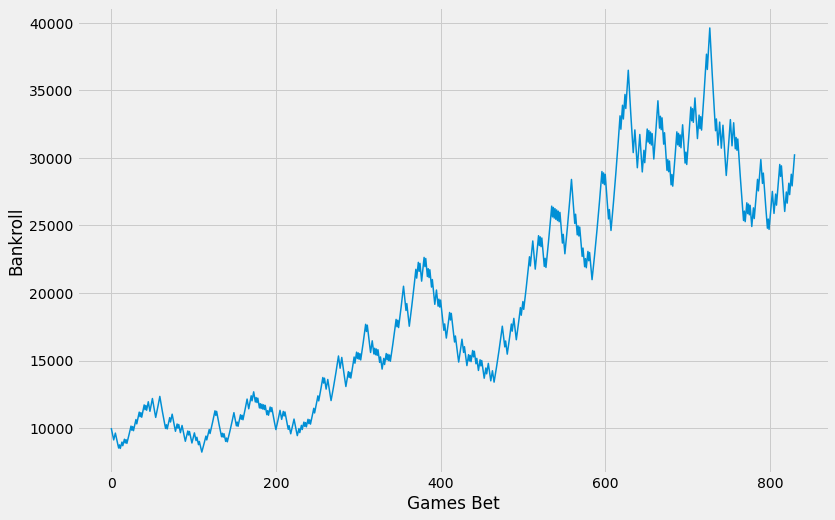

min balance: 8225.495943625096 
max balance: 39609.61997859476 
final balance: 31093.976530551674 
win percentage 55.48


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11778  2016-11-05 00:00:00    -4.5            -24.0          2.581831   
1    11782  2016-11-06 00:00:00    -4.0             11.0         -2.336447   
2    11784  2016-11-07 00:00:00    -5.5             12.0         -2.969865   
3    11786  2016-11-07 00:00:00   -16.5             10.0         -3.615820   
4    11789  2016-11-08 00:00:00    -4.0            -12.0         -5.448755   
..     ...                  ...     ...              ...               ...   
826  16445  2020-09-04 00:00:00    -5.5            -15.0          2.343016   
827  16450  2020-09-06 00:00:00    -6.0              8.0          2.290758   
828  16461  2020-09-13 00:00:00     8.5             13.0          2.408207   
829  16473  2020-09-27 00:00:00     3.0             12.0          2.725770   
830  16476  2020-10-04 00:00:00     9.5             11.0          2.370353   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0.0         1        0  10000.000000   9700.000000  300.000000  
1           1.0         0        0   9700.000000   9409.000000  291.000000  
2           1.0         0        0   9409.000000   9126.730000  282.270000  
3           0.0         0        1   9126.730000   9375.640818  273.801900  
4           0.0         0        1   9375.640818   9631.340113  281.269225  
..          ...       ...      ...           ...           ...         ...  
826         0.0         1        0  28784.686171  27921.145586  863.540585  
827         1.0         1        1  27921.145586  28682.631374  837.634368  
828         1.0         1        1  28682.631374  29464.884957  860.478941  
829         1.0         1        1  29464.884957  30268.472729  883.946549  
830         1.0         1        1  30268.472729  31093.976531  908.054182  

[831 rows x 11 columns]

In [154]:
sgd_pipe = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet', epsilon=2.7283333))

params = {
      'sgdregressor__epsilon':np.logspace(-2, 2, 10),
    'sgdregressor__alpha':np.logspace(-4, 2, 10),
    'sgdregressor__l1_ratio':np.linspace(0.05, 1, 10)
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid = params, scoring=bet_accuracy, cv=tscv)

sgd_cv.fit(X_train_ewm_19, y_train)

best_sgd = sgd_cv.best_estimator_
print(best_sgd)

sgd_preds = best_sgd.predict(X_test_ewm_19)
# mse = mean_squared_error(spread_point_diff_test, lr_preds)
# mae = mean_absolute_error(spread_point_diff_test, lr_preds)
# print("mse:", mse, "mae:", mae)

select_bets_sgd, bet_thresholds_sgd = find_optimal_confidence_thresholds(sgd_preds, test_indices)
simulate_bets(select_bets_sgd)


#### SGD Trained on Full Data

In [96]:
best_sgd_hd = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823, epsilon=744.38,
                              l1_ratio=0.95, loss='huber',
                              penalty='elasticnet'))])

best_sgd_hf = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823, epsilon=4.923,
                              l1_ratio=0.75, loss='huber',
                              penalty='elasticnet'))])

best_sgd_hd.fit(features_hd, y_hd)
best_sgd_hf.fit(features_hf, y_hf)

filename = "../models/best_sgd_hd.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_sgd_hd, file)
    
filename = "../models/best_sgd_hf.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_sgd_hf, file)    

In [133]:
sgd_pipe = pickle.load(open("../models/sgd_ewm_19.pkl", 'rb'))

sgd_pipe.named_steps['sgdregressor'].coef_

array([-0.06820603, -0.1049333 ,  0.03966829,  0.10231544, -0.06610335,
       -0.0563903 ,  0.03785041, -0.01991708,  0.00527253,  0.02459342,
        0.0473408 ,  0.00562744, -0.01531308, -0.00519175, -0.04863452,
       -0.05125892,  0.00722939, -0.02052688,  0.04435049,  0.04682948,
       -0.0218272 , -0.04631934, -0.03124972, -0.00582338, -0.1514588 ,
        0.14965718,  0.15266089,  0.06120634, -0.02786332, -0.04415127,
        0.11383774, -0.11774906,  0.04477372,  0.02541117,  0.0183196 ,
       -0.02765965, -0.00882934,  0.03520619, -0.00643851,  0.09784824,
       -0.02707639,  0.05712702,  0.05098465, -0.17936122, -0.00369882,
       -0.03208756, -0.04669513,  0.01008616, -0.01247985, -0.11556701,
        0.048351  , -0.13771881,  0.05600445, -0.02685343,  0.00695672,
        0.05125892,  0.04435049,  0.04682948,  0.00722939, -0.02052688,
        0.0218272 ,  0.04631934, -0.03348601,  0.00578375,  0.14984411,
       -0.19651074, -0.04895991, -0.13852607, -0.16710022,  0.13

#### Windsor Outliers

The reasoning behind this technique is that a spread is generally never more than 20. Thus, I will replace any point differentials that are greater than 20 with 20, as that will never change whether or not a bet is placed. However the hope is that this could possibly make the other predictions more accurate.

In [401]:
final_df = final_df.sort_values('GAME_DATE').reset_index(drop=True)

features = final_df.iloc[:, 14:-1]
features = features.drop(columns=['MIN_opp_diff', 'home_rating_n', 'away_rating_n'])
point_diff = final_df['point_diff_team']
features

X_train = features.iloc[:cutoff_15]
# X_train2 = features.iloc[cutoff_15:cutoff_17]
X_test = features.iloc[cutoff_15:]
point_diff_train = point_diff[:cutoff_15]

point_diff_train_windsor = point_diff_train.copy(deep=True)
point_diff_train_windsor.loc[point_diff_train_windsor > 20] = 20
point_diff_train_windsor.loc[point_diff_train_windsor < -20] = -20

# point_diff_train2 = point_diff[cutoff_15:cutoff_17]
point_diff_test = point_diff[cutoff_15:]


test_indices = X_test.index


mse: 164.06774993339562 mae: 10.011002978334561


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 217
win percetange at threshold: 0.5391705069124424


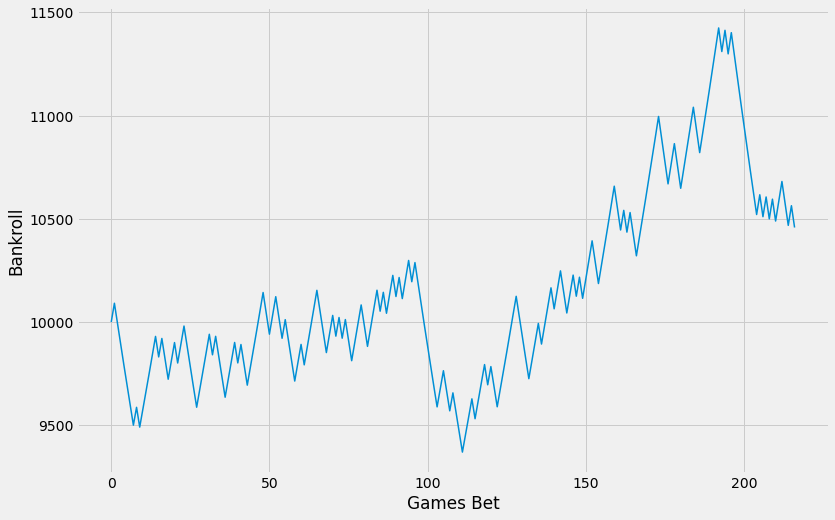

min balance: 9369.945115789762 
max balance: 11424.259463164577 
final balance: 10552.70540429874 
win percentage 53.92


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.119298         1.0   
1    18117 2015-11-09    10.5              -23 -3.874963         0.0   
2    18120 2015-11-10     6.5              -24 -0.194011         0.0   
3    18149 2015-11-13   -10.5               19  4.085793         1.0   
4    18222 2015-11-24     7.0              -17 -0.868779         0.0   
..     ...        ...     ...              ...       ...         ...   
212  23994 2020-08-12     5.5              -13  0.985405         0.0   
213  23998 2020-08-13    -8.5               26  1.755143         1.0   
214  24010 2020-08-18   -14.0              -12  7.945966         0.0   
215  24034 2020-08-24     7.0              -20 -0.445108         0.0   
216  24078 2020-09-23     3.5                3  3.380890         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    6.619298  
1           1        0  10090.909091   9990.000000  100.909091    6.625037  
2           1        0   9990.000000   9890.100000   99.900000    6.305989  
3           0        0   9890.100000   9791.199000   98.901000   -6.414207  
4           1        0   9791.199000   9693.287010   97.911990    6.131221  
..        ...      ...           ...           ...         ...         ...  
212         1        0  10680.649006  10573.842515  106.806490    6.485405  
213         0        0  10573.842515  10468.104090  105.738425   -6.744857  
214         0        1  10468.104090  10563.268673  104.681041   -6.054034  
215         1        0  10563.268673  10457.635986  105.632687    6.554892  
216         1        1  10457.635986  10552.705404  104.576360    6.880890  

[217 rows x 12 columns]

In [403]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train, point_diff_train_windsor)
lr_preds = lr_pipeline.predict(X_test)

mse = mean_squared_error(point_diff_test, lr_preds)
mae = mean_absolute_error(point_diff_test, lr_preds)
print("mse:", mse, "mae:", mae)

select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (2, 3)
num_games_bet: 1048
win percetange at threshold: 0.541030534351145


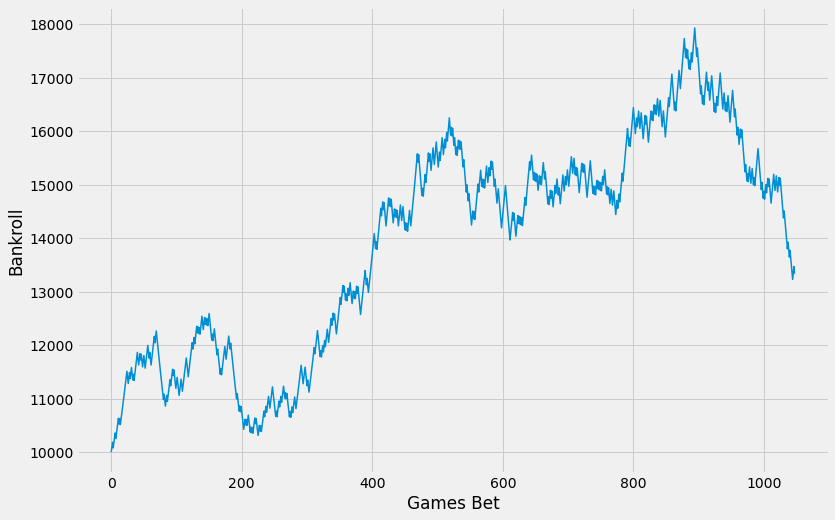

min balance: 10080.818181818182 
max balance: 17935.297491435085 
final balance: 13458.761239481086 
win percentage 54.1


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0     18093 2015-11-06     6.0                5 -3.972051         1.0   
1     18094 2015-11-06    -1.5               -7 -1.000302         0.0   
2     18097 2015-11-06     4.5               -6 -1.929266         0.0   
3     18100 2015-11-07    -2.5               10  5.432279         1.0   
4     18112 2015-11-09    -4.5               13  6.645202         1.0   
...     ...        ...     ...              ...       ...         ...   
1043  24055 2020-09-04    -5.5              -15  8.403555         0.0   
1044  24057 2020-09-05    -9.0               -9  6.301397         0.0   
1045  24069 2020-09-12    -6.5               23  8.876701         1.0   
1046  24072 2020-09-15    -2.0               -3  4.239794         0.0   
1047  24074 2020-09-18    -7.5               12  9.517177         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0            1        1  10000.000000  10090.909091  100.000000    2.027949  
1            0        1  10090.909091  10182.644628  100.909091   -2.500302  
2            1        0  10182.644628  10080.818182  101.826446    2.570734  
3            1        1  10080.818182  10172.461983  100.808182    2.932279  
4            1        1  10172.461983  10264.938911  101.724620    2.145202  
...        ...      ...           ...           ...         ...         ...  
1043         1        0  13364.226226  13230.583964  133.642262    2.903555  
1044         0        1  13230.583964  13350.862000  132.305840   -2.698603  
1045         1        1  13350.862000  13472.233473  133.508620    2.376701  
1046         1        0  13472.233473  13337.511138  134.722335    2.239794  
1047         1        1  13337.511138  13458.761239  133.375111    2.017177  

[1048 rows x 12 columns]

In [157]:
select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds_reduced, test_indices)
simulate_bets(select_bets_lr)

### Elastic Net

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17180.384475535913, tolerance: 8.35116280388979
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25812.666791966054, tolerance: 17.442354630381807
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2969.810580510879, tolerance: 24.568232195121954
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

Pipeline(steps=[('scaler', StandardScaler()),
                ('en',
                 ElasticNet(alpha=0.0018329807108324356, max_iter=10000))])
Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.011288378916846888, max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.01
num_games_bet: 546
win percetange at threshold: 0.554945054945055


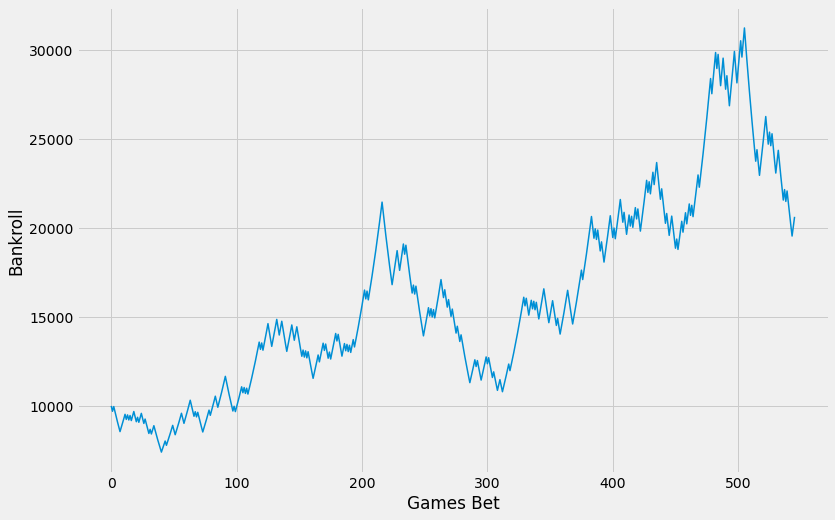

min balance: 7404.466210266355 
max balance: 31258.255264201034 
final balance: 21199.040239827966 
win percentage 55.489999999999995


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.95
num_games_bet: 93
win percetange at threshold: 0.6451612903225806


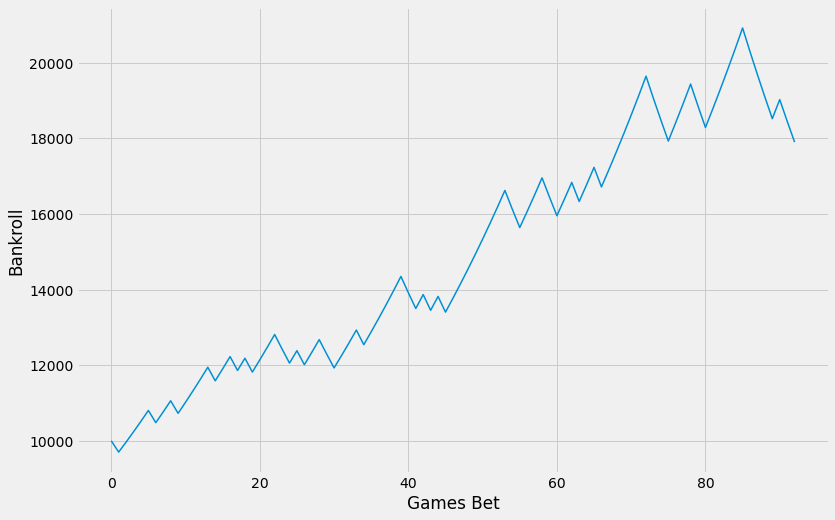

min balance: 9700.0 
max balance: 20922.36662655175 
final balance: 18391.31277246145 
win percentage 64.52


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0   11782  2016-11-06 00:00:00    -4.0             11.0         -3.780211   
1   11789  2016-11-08 00:00:00    -4.0            -12.0         -3.814030   
2   11831  2016-11-14 00:00:00   -11.0              4.0         -3.246164   
3   11874  2016-11-19 00:00:00    -4.5             -3.0         -4.423576   
4   11919  2016-11-25 00:00:00    -5.0             -9.0         -3.057031   
5   12133  2016-12-23 00:00:00   -16.5             20.0         -3.292179   
6   12137  2016-12-23 00:00:00    -5.0              4.0         -3.677526   
7   12193  2017-01-01 00:00:00    -6.0             -6.0         -3.354258   
8   12251  2017-01-08 00:00:00    -9.5             12.0         -3.114359   
9   12330  2017-01-20 00:00:00   -10.0            -29.0         -3.759024   
10  12385  2017-01-27 00:00:00   -17.0              8.0         -3.050762   
11  12464  2017-02-06 00:00:00    -1.5            -25.0         -3.539919   
12  12565  2017-02-26 00:00:00    -2.0            -10.0         -3.170318   
13  12619  2017-03-05 00:00:00    -1.0             15.0         -3.056896   
14  12657  2017-03-10 00:00:00   -10.0              9.0         -3.554651   
15  12665  2017-03-11 00:00:00    -5.5             -2.0         -3.435712   
16  12769  2017-03-25 00:00:00    -5.0             13.0         -3.422123   
17  12775  2017-03-26 00:00:00    -6.0              4.0         -3.145775   
18  12819  2017-03-31 00:00:00    -2.5              8.0         -3.692080   
19  12889  2017-04-10 00:00:00   -10.0             -6.0         -3.925943   
20  12929  2017-04-18 00:00:00    -9.0              8.0         -3.901179   
21  13001  2017-10-29 00:00:00   -14.5             -8.0         -3.207840   
22  13020  2017-11-01 00:00:00    -4.0              5.0         -3.460083   
23  13026  2017-11-01 00:00:00   -10.0              6.0          3.022518   
24  13034  2017-11-03 00:00:00    -7.5            -22.0         -3.665208   
25  13038  2017-11-03 00:00:00    -1.5              9.0         -3.050732   
26  13043  2017-11-03 00:00:00    -5.5              1.0         -3.357890   
27  13052  2017-11-05 00:00:00    -5.5             -3.0         -3.334781   
28  13062  2017-11-06 00:00:00   -14.5             17.0         -3.687942   
29  13126  2017-11-15 00:00:00    -3.5              5.0         -4.555609   
30  13145  2017-11-18 00:00:00    -6.0            -40.0         -3.397632   
31  13170  2017-11-22 00:00:00   -11.5             10.0         -3.599956   
32  13186  2017-11-24 00:00:00    -3.5            -12.0         -3.142452   
33  13222  2017-11-29 00:00:00    -1.5             29.0         -3.216563   
34  13223  2017-11-29 00:00:00    -5.5             -5.0         -3.183489   
35  13261  2017-12-04 00:00:00    -1.0            -20.0         -3.996269   
36  13316  2017-12-12 00:00:00    -5.0             -6.0         -4.469801   
37  13406  2017-12-23 00:00:00    -9.5              4.0         -3.039563   
38  13503  2018-01-07 00:00:00    -3.5              1.0         -3.042837   
39  13545  2018-01-13 00:00:00    -7.0             21.0         -3.154513   
40  13575  2018-01-17 00:00:00    -4.5              5.0         -3.499769   
41  13594  2018-01-20 00:00:00    -2.5             12.0          3.856627   
42  13780  2018-02-22 00:00:00    -8.5             15.0         -3.681384   
43  13786  2018-02-23 00:00:00    -2.0              1.0         -2.971072   
44  13818  2018-02-26 00:00:00    -7.0              9.0         -2.982530   
45  13822  2018-02-27 00:00:00   -10.5              6.0         -3.674471   
46  13858  2018-03-04 00:00:00    -7.5              3.0         -5.613137   
47  13870  2018-03-06 00:00:00   -15.0             13.0         -5.140927   
48  13885  2018-03-08 00:00:00    -7.5            -14.0         -3.898146   
49  13942  2018-03-16 00:00:00    -2.5             -1.0         -2.965488   
50  14086  2018-04-04 00:00:00    -7.0             18.0          3.374710   


In [164]:
en_pipeline_hd = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])

en_pipeline_hf = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])


params = {"en__alpha":np.logspace(-3, 2, 20)}

en_cv_hd = GridSearchCV(en_pipeline_hd, params, scoring=bet_accuracy, cv=tscv)
en_cv_hf = GridSearchCV(en_pipeline_hf, params, scoring=bet_accuracy, cv=tscv)

en_cv_hd.fit(X_train_hd, y_train_hd)
en_cv_hf.fit(X_train_hf, y_train_hf)

best_en_hd = en_cv_hd.best_estimator_
best_en_hf = en_cv_hf.best_estimator_

print(best_en_hd)
print(best_en_hf)

en_preds_hd = best_en_hd.predict(X_test_hd)
en_preds_hf = best_en_hf.predict(X_test_hf)

select_bets_en_hd, bet_thresholds_en_hd = find_optimal_confidence_thresholds(en_preds_hd, test_indices_hd)
simulate_bets(select_bets_en_hd)

select_bets_en_hf, bet_thresholds_en_hf = find_optimal_confidence_thresholds(en_preds_hf, test_indices_hf)
simulate_bets(select_bets_en_hf)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


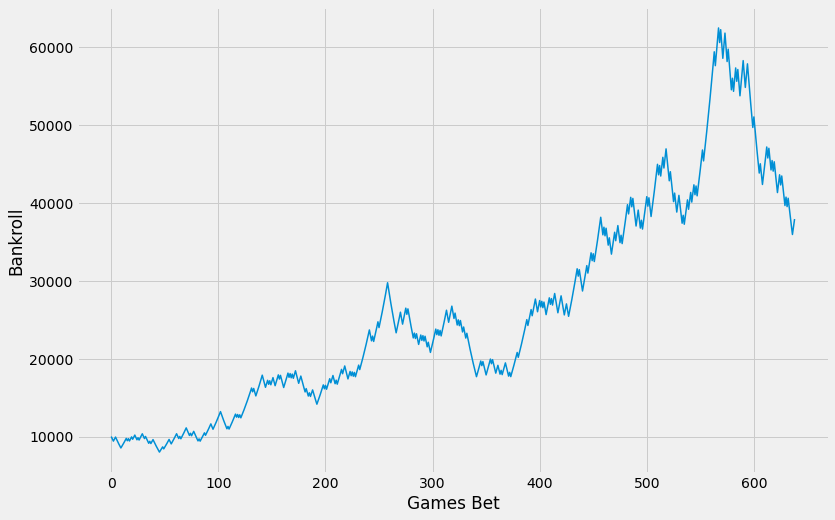

min balance: 7998.499521492193 
max balance: 62509.11361219223 
final balance: 38987.81795266722 
win percentage 56.81


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11772  2016-11-04 00:00:00     3.5            -14.0          2.386530   
1    11782  2016-11-06 00:00:00    -4.0             11.0         -3.780211   
2    11789  2016-11-08 00:00:00    -4.0            -12.0         -3.814030   
3    11793  2016-11-09 00:00:00     4.5              7.0          2.221264   
4    11804  2016-11-10 00:00:00     7.0            -24.0          3.120662   
..     ...                  ...     ...              ...               ...   
634  16437  2020-08-31 00:00:00     4.5              4.0         -2.626156   
635  16459  2020-09-11 00:00:00     3.5             -5.0          4.115481   
636  16461  2020-09-13 00:00:00     8.5             13.0          3.396245   
637  16469  2020-09-23 00:00:00     3.5              3.0          2.884804   
638  16473  2020-09-27 00:00:00     3.0             12.0          3.506472   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n     bet_size  
0             0         1        0  10000.000000   9700.000000   300.000000  
1             1         0        0   9700.000000   9409.000000   291.000000  
2             0         0        1   9409.000000   9665.609091   282.270000  
3             1         1        1   9665.609091   9929.216612   289.968273  
4             0         1        0   9929.216612   9631.340113   297.876498  
..          ...       ...      ...           ...           ...          ...  
634           1         0        0  38223.300613  37076.601595  1146.699018  
635           0         1        0  37076.601595  35964.303547  1112.298048  
636           1         1        1  35964.303547  36945.148189  1078.929106  
637           1         1        1  36945.148189  37952.743140  1108.354446  
638           1         1        1  37952.743140  38987.817953  1138.582294  

[639 rows x 11 columns]

In [171]:
betting_df_en = create_betting_df(final_df_ewm_19, en_preds_hd, en_preds_hf, test_indices)
betting_df_en

select_bets_en = betting_df_en.loc[((betting_df_en['spread'] >= 0) & (abs(betting_df_en['confidence_preds']) >= 2.01))
                                    | ((betting_df_en['spread'] < 0) & (abs(betting_df_en['confidence_preds']) >= 2.95))]


simulate_bets(select_bets_en)

In [176]:
feature_names = X_train_hd.columns
en_hf_coefs = best_en_hf.named_steps['en'].coef_
en_hd_coefs = best_en_hd.named_steps['en'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'en_home_fav_coef':en_hf_coefs,
                       'en_home_dog_coef':en_hd_coefs})
coef_df_sgd.sort_values('en_home_dog_coef', ascending=False)

feature  en_home_fav_coef  en_home_dog_coef
67        AST_2PM_opp_diff          0.000000          3.643572
80        EFG_PCT_opp_diff          0.000000          2.857592
68       UAST_2PM_opp_diff         -0.000000          2.041238
32     PTS_PAINT_team_diff          0.142951          1.889315
29    PTS_2PT_MR_team_diff         -0.260241          1.590480
77        TS_PCT_team_diff         -0.000000          1.580055
69        AST_3PM_opp_diff          0.100687          1.458559
89            elo_MOV_pred         -0.320091          1.209430
40           FG2A_opp_diff         -0.000000          1.135077
71      OREB_PCT_team_diff          0.087861          1.084455
24    DEF_RATING_team_diff         -0.000000          0.983623
56     OFF_RATING_opp_diff         -0.000000          0.927926
54     PLUS_MINUS_opp_diff          0.202458          0.868098
9            FTM_team_diff          0.000000          0.737695
12          DREB_team_diff          0.556063          0.724901
30        PTS_FB_team_diff         -0.087371          0.723699
46           DREB_opp_diff          0.225543          0.670113
65    PTS_OFF_TOV_opp_diff         -0.091122          0.637911
18            PF_team_diff          0.439897          0.590509
8           FG3A_team_diff         -0.000000          0.579608
17           TOV_team_diff         -0.054056          0.539755
47            REB_opp_diff          0.000000          0.474709
38         RECORD_opp_diff          0.390843          0.471327
58     DEF_RATING_opp_diff         -0.000000          0.406205
84        TOV_PCT_opp_diff          0.124987          0.373877
28           PIE_team_diff          0.437086          0.371590
81     AST_RATIO_team_diff         -0.000000          0.355412
22    OFF_RATING_team_diff         -0.000000          0.327745
4        team_covered_diff         -0.129300          0.320323
85               rest_diff          0.054473          0.316324
43            FTM_opp_diff         -0.000000          0.305071
76        REB_PCT_opp_diff         -0.014962          0.294522
27          POSS_team_diff         -0.285440          0.263596
70       UAST_3PM_opp_diff          0.139489          0.258499
39           FG2M_opp_diff          0.000000          0.247398
52             PF_opp_diff         -0.509738          0.220806
87           home_rating_i          0.000000          0.210397
35       AST_3PM_team_diff          0.583726          0.200009
16           BLK_team_diff         -0.055659          0.144096
0         home_spread_mode         -0.008422          0.141657
25  E_NET_RATING_team_diff         -0.125716          0.130696
72       OREB_PCT_opp_diff         -0.000000          0.071376
31   PTS_OFF_TOV_team_diff          0.656650          0.067370
34      UAST_2PM_team_diff         -0.000000          0.034588
49            STL_opp_diff          0.462834          0.023883
37     TEAM_SCORE_opp_diff         -0.000000         -0.000000
26    NET_RATING_team_diff          0.000000         -0.000000
88           away_rating_i          0.376696         -0.000000
7           FG3M_team_diff         -0.251914         -0.000000
79       EFG_PCT_team_diff         -0.034896         -0.000000
78         TS_PCT_opp_diff          0.024027         -0.000000
13           REB_team_diff          0.000000          0.000000
14           AST_team_diff         -0.000000          0.000000
60     NET_RATING_opp_diff         -0.000000          0.000000
45           OREB_opp_diff         -0.106057          0.000000
53            PTS_opp_diff         -0.000000         -0.000000
36      UAST_3PM_team_diff         -0.000000         -0.026357
6           FG2A_team_diff         -0.000000         -0.061968
73      DREB_PCT_team_diff          0.000000         -0.070522
1           WL_record_diff          0.358817         -0.149218
2          ATS_record_diff          0.088722         -0.253140
59   E_NET_RATING_opp_diff          0.113888         -0.263980
75       REB_PCT_team_diff          0.016120      

### One Model

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5223.139918279921, tolerance: 27.200078236493376
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20246.992723283533, tolerance: 54.457639162844025
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19250.860613869736, tolerance: 80.16018746177369
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.011288378916846888, max_iter=20000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.36
num_games_bet: 1363
win percetange at threshold: 0.5370506236243581


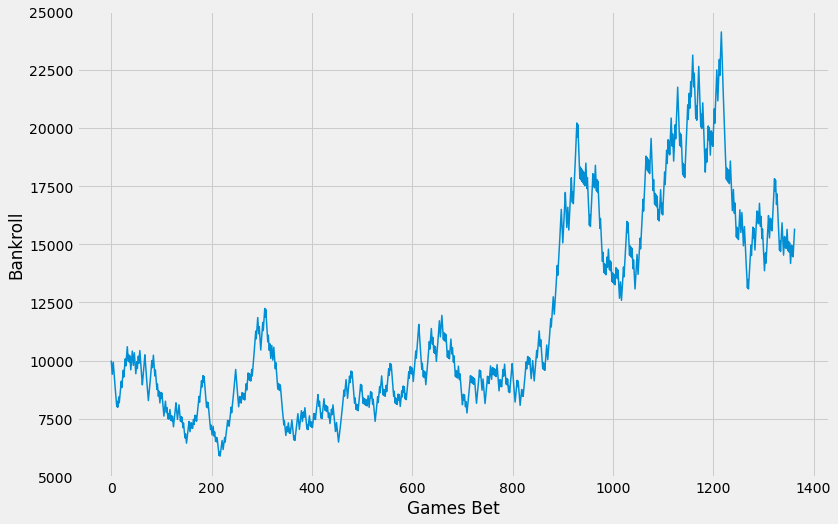

min balance: 5893.223147664728 
max balance: 24132.303062955994 
final balance: 16104.20966240188 
win percentage 53.71


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11782  2016-11-06 00:00:00    -4.0             11.0         -2.690701   
1     11784  2016-11-07 00:00:00    -5.5             12.0         -2.773301   
2     11786  2016-11-07 00:00:00   -16.5             10.0         -3.993966   
3     11789  2016-11-08 00:00:00    -4.0            -12.0         -4.353505   
4     11790  2016-11-08 00:00:00    -6.5              8.0         -2.799678   
...     ...                  ...     ...              ...               ...   
1358  16467  2020-09-20 00:00:00    -7.5              2.0          1.553063   
1359  16469  2020-09-23 00:00:00     3.5              3.0          1.519301   
1360  16473  2020-09-27 00:00:00     3.0             12.0          1.847648   
1361  16476  2020-10-04 00:00:00     9.5             11.0          2.114682   
1362  16477  2020-10-06 00:00:00     7.5             -6.0          1.699591   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1.0         0        0  10000.000000   9700.000000  300.000000  
1            1.0         0        0   9700.000000   9409.000000  291.000000  
2            0.0         0        1   9409.000000   9665.609091  282.270000  
3            0.0         0        1   9665.609091   9929.216612  289.968273  
4            1.0         0        0   9929.216612   9631.340113  297.876498  
...          ...       ...      ...           ...           ...         ...  
1358         0.0         1        0  14908.180712  14460.935290  447.245421  
1359         1.0         1        1  14460.935290  14855.324435  433.828059  
1360         1.0         1        1  14855.324435  15260.469646  445.659733  
1361         1.0         1        1  15260.469646  15676.664273  457.814089  
1362         1.0         1        1  15676.664273  16104.209662  470.299928  

[1363 rows x 11 columns]

In [172]:
en_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=20000))])


params = {"en__alpha":np.logspace(-3, 2, 20)}

en_cv = GridSearchCV(en_pipeline, params, scoring=bet_accuracy, cv=tscv)

en_cv.fit(X_train_ewm_19, y_train)

best_en = en_cv.best_estimator_

print(best_en)

en_preds = best_en.predict(X_test_ewm_19)

select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(en_preds, test_indices)
simulate_bets(select_bets_en)



In [177]:
feature_names = X_train_hd.columns
en_coefs = best_en.named_steps['en'].coef_

coef_df_en = pd.DataFrame({'feature':feature_names,
                       'en_coef':en_coefs})
coef_df_en.sort_values('en_coef', ascending=False)

feature   en_coef
0         home_spread_mode  0.940826
38         RECORD_opp_diff  0.497929
31   PTS_OFF_TOV_team_diff  0.496372
18            PF_team_diff  0.492828
12          DREB_team_diff  0.469172
28           PIE_team_diff  0.404902
89            elo_MOV_pred  0.379032
35       AST_3PM_team_diff  0.358902
87           home_rating_i  0.325134
49            STL_opp_diff  0.312933
69        AST_3PM_opp_diff  0.302355
10           FTA_team_diff  0.256607
46           DREB_opp_diff  0.246697
54     PLUS_MINUS_opp_diff  0.241438
70       UAST_3PM_opp_diff  0.206717
1           WL_record_diff  0.204454
80        EFG_PCT_opp_diff  0.179979
24    DEF_RATING_team_diff  0.153799
56     OFF_RATING_opp_diff  0.139104
85               rest_diff  0.138812
30        PTS_FB_team_diff  0.134793
78         TS_PCT_opp_diff  0.130670
32     PTS_PAINT_team_diff  0.129989
71      OREB_PCT_team_diff  0.122726
9            FTM_team_diff  0.111253
84        TOV_PCT_opp_diff  0.104254
65    PTS_OFF_TOV_opp_diff  0.091415
33       AST_2PM_team_diff  0.040054
16           BLK_team_diff  0.033556
23  E_DEF_RATING_team_diff  0.019587
51            TOV_opp_diff  0.000000
8           FG3A_team_diff  0.000000
73      DREB_PCT_team_diff  0.000000
47            REB_opp_diff  0.000000
75       REB_PCT_team_diff  0.000000
7           FG3M_team_diff -0.000000
53            PTS_opp_diff  0.000000
55   E_OFF_RATING_opp_diff  0.000000
58     DEF_RATING_opp_diff  0.000000
59   E_NET_RATING_opp_diff  0.000000
60     NET_RATING_opp_diff  0.000000
72       OREB_PCT_opp_diff -0.000000
63     PTS_2PT_MR_opp_diff  0.000000
57   E_DEF_RATING_opp_diff  0.000000
37     TEAM_SCORE_opp_diff  0.000000
76        REB_PCT_opp_diff -0.000000
25  E_NET_RATING_team_diff -0.000000
11          OREB_team_diff -0.000000
88           away_rating_i -0.000000
13           REB_team_diff  0.000000
14           AST_team_diff  0.000000
86           home_elo_pred  0.000000
5           FG2M_team_diff -0.000000
19           PTS_team_diff -0.000000
21  E_OFF_RATING_team_diff  0.000000
22    OFF_RATING_team_diff  0.000000
26    NET_RATING_team_diff -0.000000
43            FTM_opp_diff  0.000000
81     AST_RATIO_team_diff  0.000000
79       EFG_PCT_team_diff -0.000000
34      UAST_2PM_team_diff -0.000000
68       UAST_2PM_opp_diff  0.000000
2          ATS_record_diff  0.000000
39           FG2M_opp_diff  0.000000
40           FG2A_opp_diff  0.000000
41           FG3M_opp_diff  0.000000
77        TS_PCT_team_diff -0.000000
67        AST_2PM_opp_diff  0.000000
45           OREB_opp_diff -0.003427
4        team_covered_diff -0.029086
15           STL_team_diff -0.055554
36      UAST_3PM_team_diff -0.072314
61           POSS_opp_diff -0.076211
17           TOV_team_diff -0.097239
74       DREB_PCT_opp_diff -0.122647
29    PTS_2PT_MR_team_diff -0.129950
50            BLK_opp_diff -0.147003
48            AST_opp_diff -0.161937
6           FG2A_team_diff -0.193518
52             PF_opp_diff -0.228444
27          POSS_team_diff -0.238470
20    PLUS_MINUS_team_diff -0.267065
66      PTS_PAINT_opp_diff -0.300752
82      AST_RATIO_opp_diff -0.313353
83       TOV_PCT_team_diff -0.336921
64         PTS_FB_opp_diff -0.379575
62            PIE_opp_diff -0.417851
3         RECORD_team_diff -0.513437
44            FTA_opp_diff -0.613416
42           FG3A_opp_diff -0.705921

In [205]:

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.05298, max_iter=10000))])
en_pipe.fit(features_ewm_19, spread_point_diff_ewm_19)

filename = '../models/en_ewm_19.pkl'
with open(filename, 'wb') as file:
    pickle.dump(en_pipe, file)

### Ridge Regression

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.73
num_games_bet: 32
win percetange at threshold: 0.53125


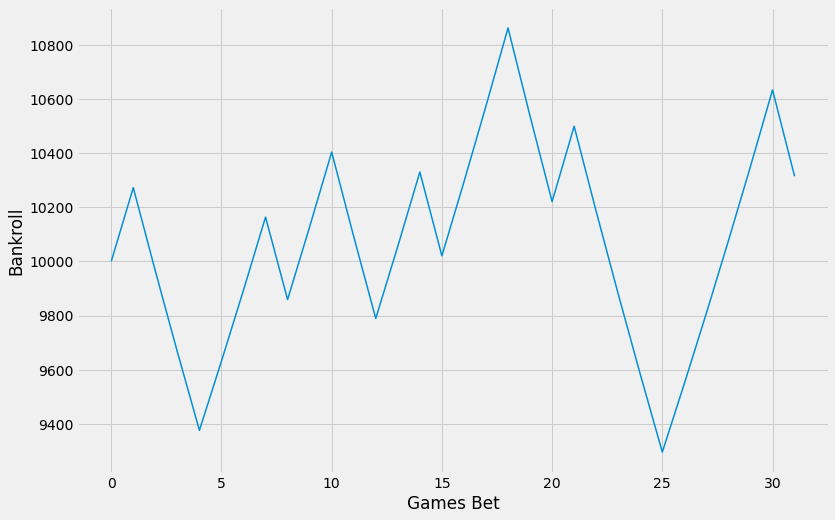

min balance: 9295.262211544856 
max balance: 10862.892492339222 
final balance: 10005.387324323043 
win percentage 53.12


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11792 2016-11-08    -4.0              -12         -3.920766         0.0   
1   12248 2017-01-08    -2.5                9         -3.908965         1.0   
2   12901 2017-04-11    -4.5               25         -3.989045         1.0   
3   13015 2017-10-30    -7.0               -8          4.762303         0.0   
4   13047 2017-11-03    -6.5               -7         -3.872146         0.0   
5   13109 2017-11-13    -4.0                7          4.138794         1.0   
6   13128 2017-11-15    -2.0               -9         -3.953735         0.0   
7   13252 2017-12-03    -8.5                3          4.718330         0.0   
8   13591 2018-01-20    -7.5               22          3.731737         1.0   
9   13644 2018-01-27   -11.0                4         -3.805375         0.0   
10  13838 2018-03-01     2.5                5         -4.379504         1.0   
11  13861 2018-03-04     1.5                8         -6.039290         1.0   
12  13888 2018-03-08   -11.0                3         -4.033642         0.0   
13  14085 2018-04-04     6.0               10          3.854107         1.0   
14  14610 2018-12-19   -12.0               -8          4.173551         0.0   
15  14758 2019-01-09     2.0               -7         -4.529224         0.0   
16  15380 2019-04-13    -9.5               -3         -3.792133         0.0   
17  15397 2019-04-19    -7.0               12          3.797223         1.0   
18  15406 2019-04-21    -5.0              -13          4.025346         0.0   
19  15413 2019-04-23    -9.0               22         -4.069464         1.0   
20  15469 2019-11-03     1.5               -7         -4.643912         0.0   
21  15473 2019-11-04     6.0               -7          3.908372         0.0   
22  15501 2019-11-08    -7.5               32         -4.283975         1.0   
23  15549 2019-11-15     8.0                1         -3.922240         1.0   
24  16086 2020-02-01     6.0               17         -4.293045         1.0   
25  16133 2020-02-08     2.5               20          4.428887         1.0   
26  16200 2020-02-23    -7.5                2         -4.506994         0.0   
27  16205 2020-02-24    -4.0               -2         -3.999710         0.0   
28  16275 2020-03-04     4.0               -6         -4.358985         0.0   
29  16388 2020-08-10    -4.0               22          3.810002         1.0   
30  16409 2020-08-14     2.0               17         -3.806691         1.0   
31  16437 2020-08-23    14.0              -28          4.249111         0.0   

    bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0          0        1  10000.000000  10272.727273  300.000000  
1          0        0  10272.727273   9964.545455  308.181818  
2          0        0   9964.545455   9665.609091  298.936364  
3          1        0   9665.609091   9375.640818  289.968273  
4          0        1   9375.640818   9631.340113  281.269225  
5          1        1   9631.340113   9894.013025  288.940203  
6          0        1   9894.013025  10163.849744  296.820391  
7          1        0  10163.849744   9858.934252  304.915492  
8          1        1   9858.934252  10127.814277  295.768028  
9          0        1  10127.814277  10404.027394  303.834428  
10         0        0  10404.027394  10091.906572  312.120822  
11         0        0  10091.906572   9789.149375  302.757197  
12         0        1   9789.149375  10056.126176  293.674481  
13         1        1  10056.126176  10330.384162  301.683785  
14         1        0  10330.384162  10020.472638  309.911525  
15         0        1  10020.472638  10293.758255  300.614179  
16         0        1  10293.758255  10574.497116  308.812748  
17         1        1  10574.497116  10862.892492  317.234913  
18         1        0  10862.892492  10537.005718  325.886775  
19         0        0  10537.005718  10220.895546  316.110172  
20         0        1  10220.895546  10499.647243  3

In [113]:
tscv = TimeSeriesSplit()
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge(max_iter=10000))])
ridge_pipeline.fit(X_train_spread, spread_point_diff_train)

params = {"ridge__alpha":np.logspace(-3, 2, 15)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
ridge_cv.fit(X_train_spread, spread_point_diff_train)

print(ridge_cv.best_estimator_)
best_ridge = ridge_cv.best_estimator_
ridge_preds = best_ridge.predict(X_test_spread)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)

<AxesSubplot:ylabel='feature'>

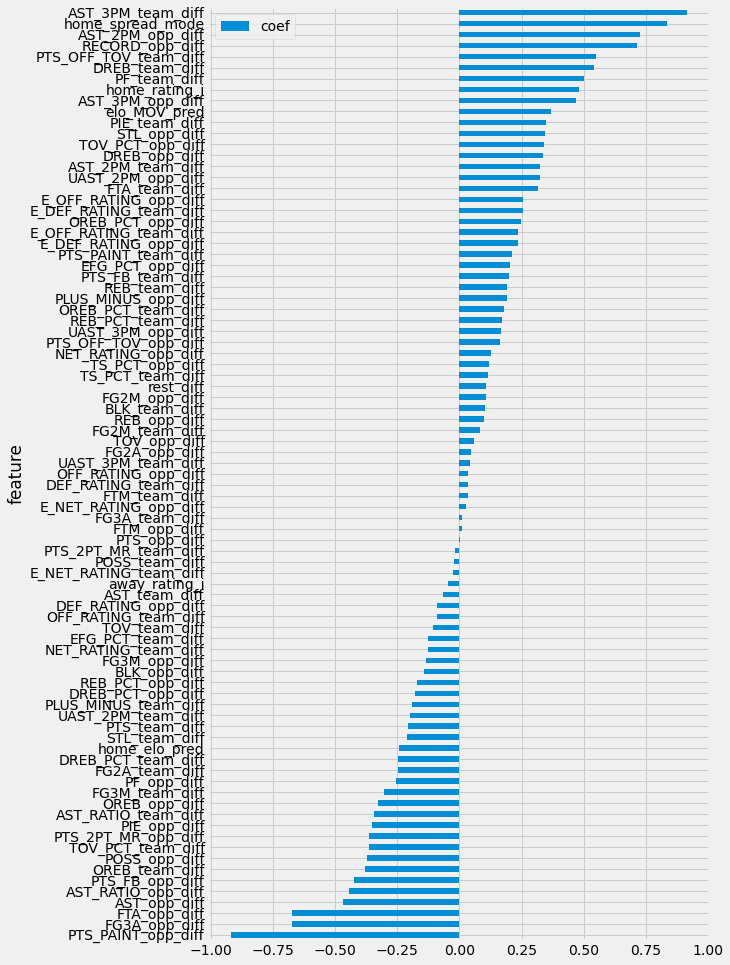

In [458]:
best_ridge
feature_names = X_train_spread.columns
ridge_coefficients = best_ridge.named_steps['ridge'].coef_

ridge_coefs = pd.DataFrame({'feature':feature_names, 'coef':ridge_coefficients})
ridge_coefs.loc[ridge_coefs['coef'] !=0].sort_values('coef').plot(x='feature',kind='barh', figsize=(8,16))

#### Ridge EWM 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=1389.4954943731375, max_iter=10000))])
0.5260958205912334


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.96
num_games_bet: 1922
win percetange at threshold: 0.5369406867845994


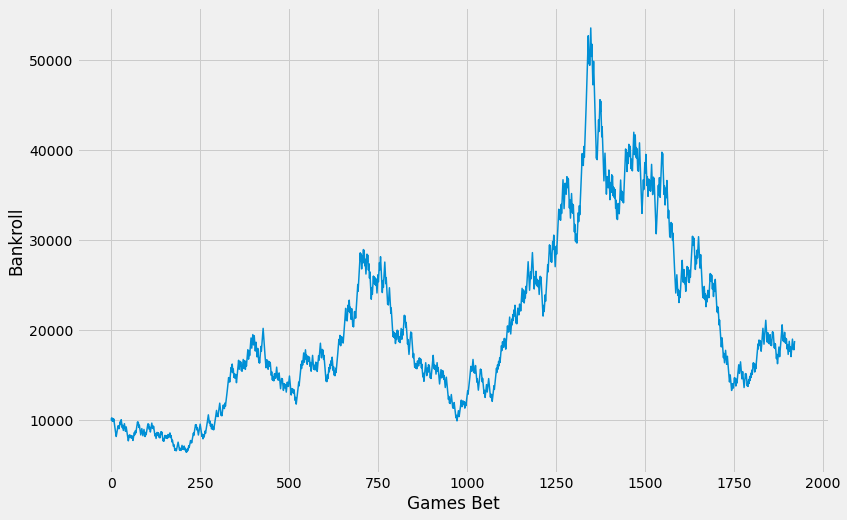

min balance: 6480.077361022287 
max balance: 53609.98859281073 
final balance: 19343.991316343454 
win percentage 53.690000000000005


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11781 2016-11-06    -7.5               -5         -1.429059         0.0   
1     11782 2016-11-06    -4.0               11         -2.283051         1.0   
2     11783 2016-11-06    -7.0              -16         -1.527394         0.0   
3     11785 2016-11-07    -5.5               12         -2.104421         1.0   
4     11786 2016-11-07   -16.5               10         -2.772723         0.0   
...     ...        ...     ...              ...               ...         ...   
1917  16483 2020-09-23     3.5                3          2.978193         1.0   
1918  16485 2020-09-25    -3.5               13         -0.985718         1.0   
1919  16486 2020-09-26    -5.5               10          1.522973         1.0   
1920  16487 2020-09-27     3.0               12          2.104211         1.0   
1921  16488 2020-09-30    -4.5               18          1.042958         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            0        1  10000.000000  10272.727273  300.000000  
1            0        0  10272.727273   9964.545455  308.181818  
2            0        1   9964.545455  10236.305785  298.936364  
3            0        0  10236.305785   9929.216612  307.089174  
4            0        1   9929.216612  10200.013428  297.876498  
...        ...      ...           ...           ...         ...  
1917         1        1  17907.349958  18395.732230  537.220499  
1918         0        0  18395.732230  17843.860263  551.871967  
1919         1        1  17843.860263  18330.510998  535.315808  
1920         1        1  18330.510998  18830.434025  549.915330  
1921         1        1  18830.434025  19343.991316  564.913021  

[1922 rows x 11 columns]

In [126]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge(max_iter=10000))])
ridge_pipeline.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

params = {"ridge__alpha":np.logspace(1, 4, 15)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring=bet_accuracy, cv=tscv)
ridge_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(ridge_cv.best_estimator_)
print(ridge_cv.best_score_)
best_ridge = ridge_cv.best_estimator_
ridge_preds = best_ridge.predict(X_test_ewm_19)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
for season_idx in [test_indices_16, test_indices_17, test_indices_18, test_indices_19]:
    simulate_bets(select_bets_ridge.loc[select_bets_ridge.index.isin(season_idx)])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.1
num_games_bet: 2099
win percetange at threshold: 0.533587422582182


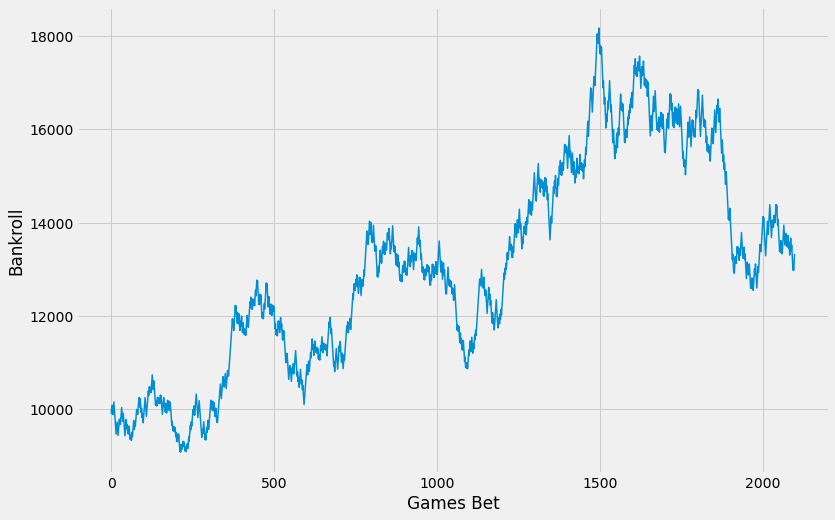

min balance: 9075.531021039647 
max balance: 18179.101682646793 
final balance: 13451.92306616265 
win percentage 53.36


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11776 2016-11-04     3.5              -14          1.475442         0.0   
1     11782 2016-11-06    -7.0              -16         -1.938461         0.0   
2     11783 2016-11-06    -7.5               -5         -1.681917         0.0   
3     11784 2016-11-06    -4.0               11         -3.417908         1.0   
4     11787 2016-11-07    -5.5               12         -2.764069         1.0   
...     ...        ...     ...              ...               ...         ...   
2094  16480 2020-09-19     3.5              -11          2.902472         0.0   
2095  16483 2020-09-23     3.5                3          3.274354         1.0   
2096  16486 2020-09-26    -5.5               10          1.395873         1.0   
2097  16487 2020-09-27     3.0               12          2.500971         1.0   
2098  16490 2020-10-04     9.5               11          1.539464         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        0  10000.000000   9900.000000  100.000000  
1            0        1   9900.000000   9990.000000   99.000000  
2            0        1   9990.000000  10080.818182   99.900000  
3            0        0  10080.818182   9980.010000  100.808182  
4            0        0   9980.010000   9880.209900   99.800100  
...        ...      ...           ...           ...         ...  
2094         1        0  13104.727835  12973.680556  131.047278  
2095         1        1  12973.680556  13091.623107  129.736806  
2096         1        1  13091.623107  13210.637862  130.916231  
2097         1        1  13210.637862  13330.734570  132.106379  
2098         1        1  13330.734570  13451.923066  133.307346  

[2099 rows x 11 columns]

In [89]:
ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

ridge_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

ridge_preds = ridge_pipe.predict(X_test_ewm_19)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)


#### Windsor Outliers

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=100.0))])
best thresholds: (7, 13)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 254
win percetange at threshold: 0.531496062992126


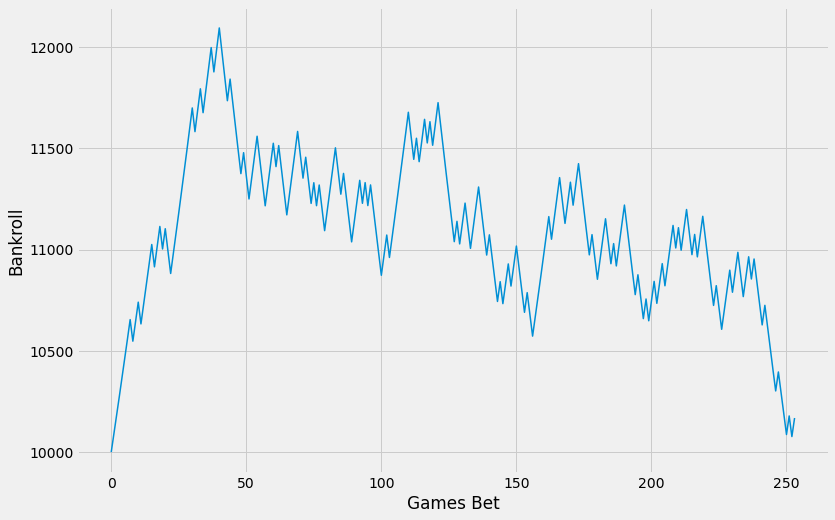

min balance: 10076.67402720275 
max balance: 12093.607067231336 
final balance: 10260.719065220253 
win percentage 53.15


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.637812         1.0   
1    18135 2015-11-11   -13.0                8  5.212560         0.0   
2    18305 2015-12-05     2.5               15  5.465413         1.0   
3    18467 2015-12-27   -16.5               10  8.768078         0.0   
4    18476 2015-12-28     9.5               -4 -1.420319         1.0   
..     ...        ...     ...              ...       ...         ...   
249  24068 2020-09-11     3.5               -5  3.960602         0.0   
250  24070 2020-09-13     8.5               13 -0.520397         1.0   
251  24075 2020-09-19     3.5              -11  3.815575         0.0   
252  24085 2020-10-04     9.5               11 -0.496515         1.0   
253  24086 2020-10-06     7.5               -6  0.252272         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.137812  
1           0        1  10090.909091  10182.644628  100.909091   -7.787440  
2           1        1  10182.644628  10275.214125  101.826446    7.965413  
3           0        1  10275.214125  10368.625162  102.752141   -7.731922  
4           1        1  10368.625162  10462.885391  103.686252    8.079681  
..        ...      ...           ...           ...         ...         ...  
249         1        0  10188.647261  10086.760788  101.886473    7.460602  
250         1        1  10086.760788  10178.458613  100.867608    7.979603  
251         1        0  10178.458613  10076.674027  101.784586    7.315575  
252         1        1  10076.674027  10168.280155  100.766740    9.003485  
253         1        1  10168.280155  10260.719065  101.682802    7.752272  

[254 rows x 12 columns]

In [405]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge())])


params = {"ridge__alpha":np.logspace(-3, 2, 30)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_cv.fit(X_train, point_diff_train_windsor)

print(ridge_cv.best_estimator_)

best_ridge = ridge_cv.best_estimator_

ridge_preds = best_ridge.predict(X_test)

select_bets_ridge, bet_thresholds_ridge = find_optimal_threshold(ridge_preds, test_indices)

simulate_bets(select_bets_ridge)

### Lasso Regression

In [519]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
lasso_cv.fit(X_train, point_diff_train)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test)

select_bets_lasso, bet_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)

simulate_bets(select_bets_lasso)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258.6725481300382, tolerance: 49.18794522546418
  positive)


KeyboardInterrupt: 

<AxesSubplot:ylabel='feature'>

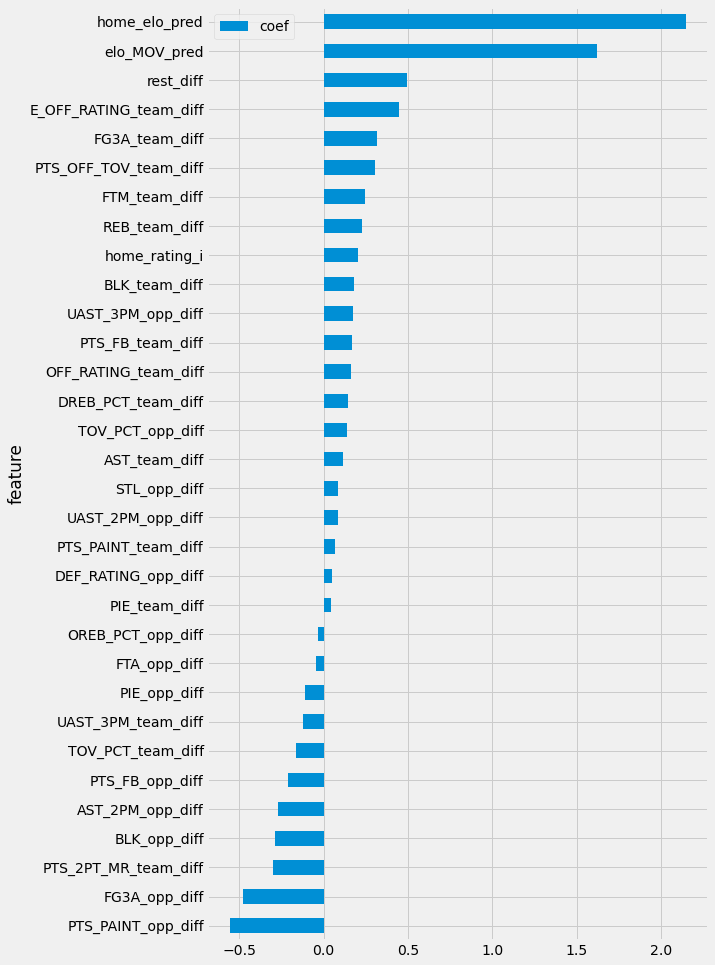

In [342]:
feature_names = X_train.columns
lasso_coefficients = best_lasso.named_steps['lasso'].coef_

lasso_coefs = pd.DataFrame({'feature':feature_names, 'coef':lasso_coefficients})
lasso_coefs.loc[lasso_coefs['coef'] !=0].sort_values('coef').plot(x='feature',kind='barh', figsize=(8,16))

#### Predicting Spread + Actual Point Diff

In [520]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
lasso_cv.fit(X_train_spread, spread_point_diff_train)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test_spread)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2105.8663179949217, tolerance: 27.21964898167006
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.39100485484232, tolerance: 27.21964898167006
  positive)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.8
num_games_bet: 1807
win percetange at threshold: 0.5329275041505257


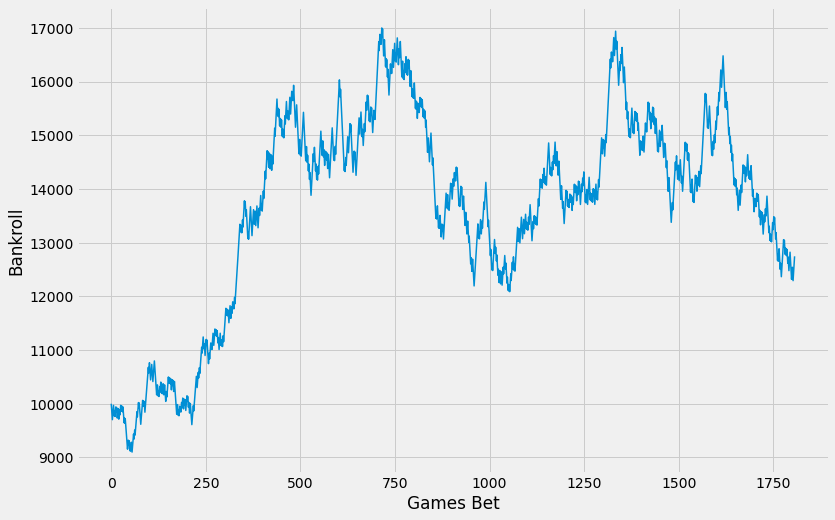

min balance: 9099.511529576148 
max balance: 16997.46461436011 
final balance: 12617.607237692144 
win percentage 53.290000000000006


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11776 2016-11-04     3.5              -14          1.194684         0.0   
1     11778 2016-11-05    -3.5               26         -1.360325         1.0   
2     11781 2016-11-06    -4.0               11         -1.404474         1.0   
3     11782 2016-11-06    -7.5               -5         -1.153785         0.0   
4     11783 2016-11-06    -3.0               11          0.818949         1.0   
...     ...        ...     ...              ...               ...         ...   
1802  16483 2020-09-23     3.5                3          1.646878         1.0   
1803  16486 2020-09-26    -5.5               10          1.427627         1.0   
1804  16487 2020-09-27     3.0               12          0.969972         1.0   
1805  16488 2020-09-30    -4.5               18          0.862366         1.0   
1806  16492 2020-10-09    -7.5               -3          0.822936         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        0  10000.000000   9900.000000  100.000000  
1            0        0   9900.000000   9801.000000   99.000000  
2            0        0   9801.000000   9702.990000   98.010000  
3            0        1   9702.990000   9791.199000   97.029900  
4            1        1   9791.199000   9880.209900   97.911990  
...        ...      ...           ...           ...         ...  
1802         1        1  12291.945766  12403.690727  122.919458  
1803         1        1  12403.690727  12516.451552  124.036907  
1804         1        1  12516.451552  12630.237475  125.164516  
1805         1        1  12630.237475  12745.057816  126.302375  
1806         1        0  12745.057816  12617.607238  127.450578  

[1807 rows x 11 columns]

In [521]:
select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

#### Lasso EWM

In [144]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring=bet_accuracy, cv=tscv)
lasso_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test_ewm_19)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1370.9306001221412, tolerance: 27.223920812118124
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.69415319891414, tolerance: 54.489167957208366
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.23481687461026, tolerance: 80.16299938858697
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.02807216203941177, max_iter=20000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.1
num_games_bet: 1699
win percetange at threshold: 0.5367863449087699


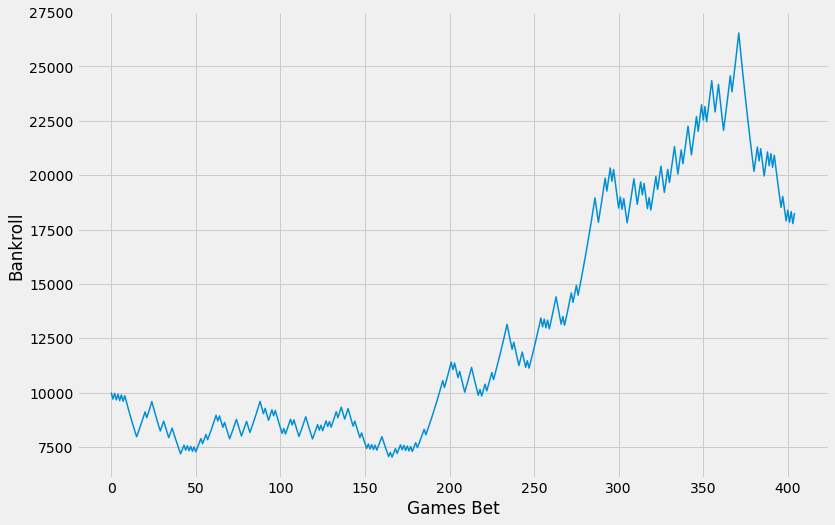

min balance: 7031.659964114249 
max balance: 26540.833736795186 
final balance: 17709.560814000022 
win percentage 55.559999999999995


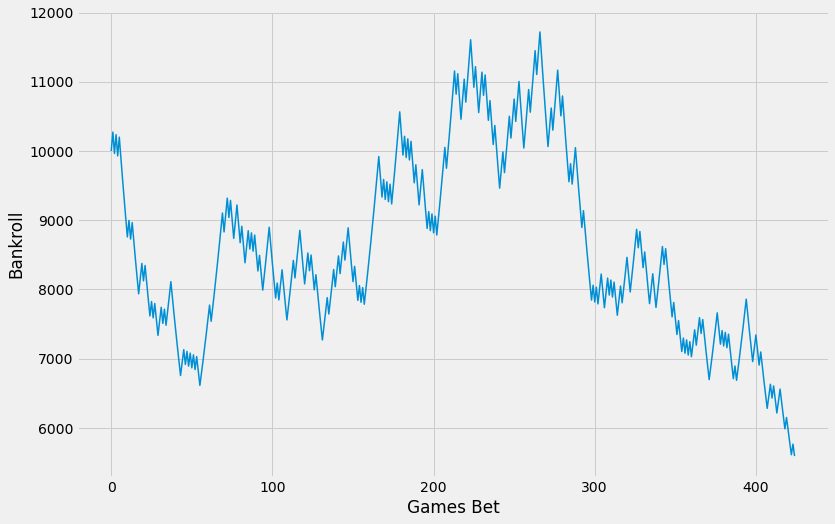

min balance: 5426.280448713076 
max balance: 11719.275915996317 
final balance: 5426.280448713076 
win percentage 50.59


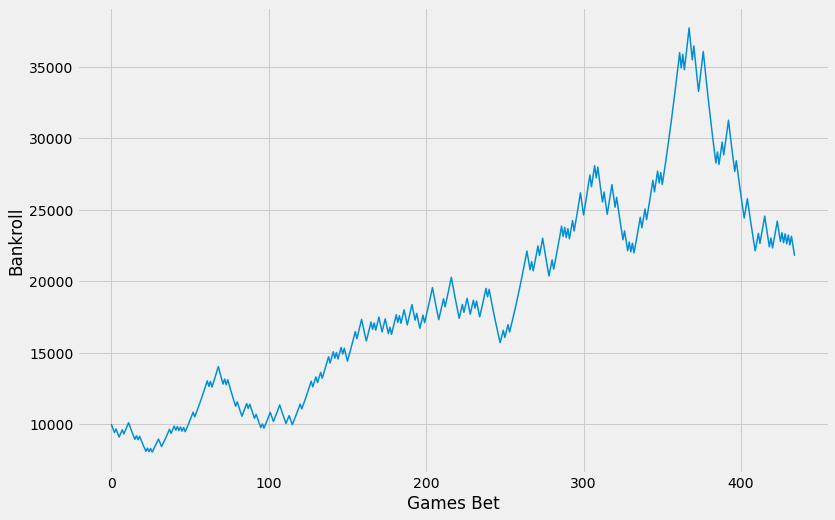

min balance: 8039.061137568101 
max balance: 37712.360834750754 
final balance: 21121.57385848549 
win percentage 56.089999999999996


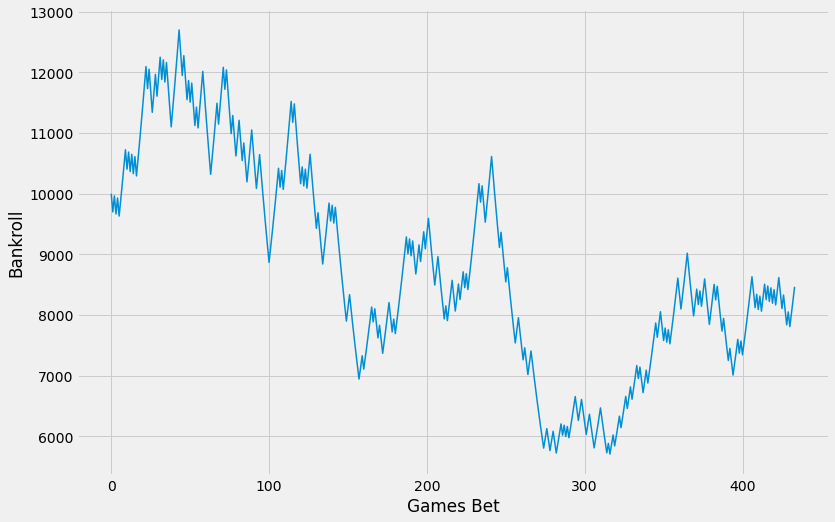

min balance: 5705.3702005843425 
max balance: 12701.74012857751 
final balance: 8696.212768225585 
win percentage 52.53


In [145]:
select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
for season_idx in [test_indices_16, test_indices_17, test_indices_18, test_indices_19]:
    simulate_bets(select_bets_lasso.loc[select_bets_lasso.index.isin(season_idx)])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.56
num_games_bet: 369
win percetange at threshold: 0.5772357723577236


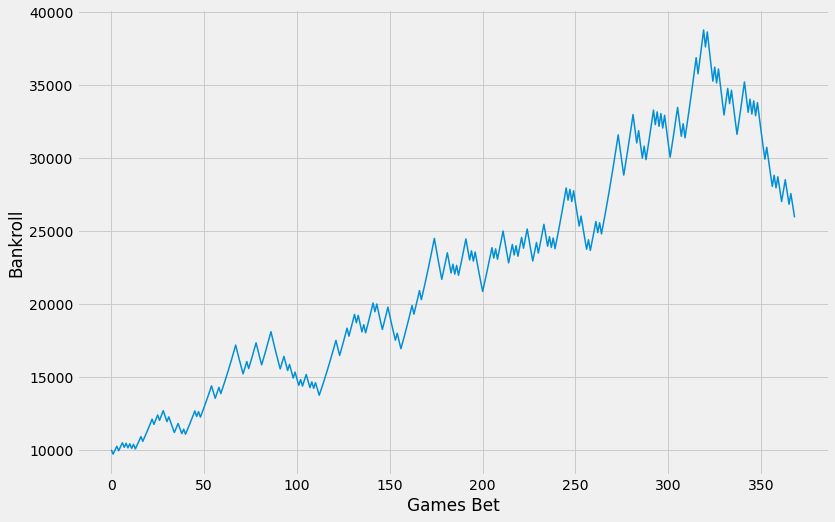

min balance: 9700.0 
max balance: 38778.398948462454 
final balance: 26635.26786832837 
win percentage 57.720000000000006


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11785 2016-11-07    -5.5               12         -1.696689         1.0   
1    11786 2016-11-07   -16.5               10         -1.889417         0.0   
2    11792 2016-11-08    -4.0              -12         -2.695271         0.0   
3    11804 2016-11-09   -18.5               21         -2.185632         1.0   
4    11834 2016-11-14   -11.0                4         -2.575753         0.0   
..     ...        ...     ...              ...               ...         ...   
364  16437 2020-08-23    14.0              -28          2.432234         0.0   
365  16445 2020-08-29    -5.0               34          1.886138         1.0   
366  16455 2020-09-02    -5.5                2          2.110410         0.0   
367  16480 2020-09-19     3.5              -11          1.774772         0.0   
368  16483 2020-09-23     3.5                3          1.964461         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9700.000000  300.000000  
1           0        1   9700.000000   9964.545455  291.000000  
2           0        1   9964.545455  10236.305785  298.936364  
3           0        0  10236.305785   9929.216612  307.089174  
4           0        1   9929.216612  10200.013428  297.876498  
..        ...      ...           ...           ...         ...  
364         1        0  27654.789007  26825.145337  829.643670  
365         1        1  26825.145337  27556.740209  804.754360  
366         1        0  27556.740209  26730.038003  826.702206  
367         1        0  26730.038003  25928.136863  801.901140  
368         1        1  25928.136863  26635.267868  777.844106  

[369 rows x 11 columns]

In [198]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])


lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

lasso_preds = lasso_pipe.predict(X_test_ewm_19)

select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

In [200]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.02807216203941177, max_iter=20000))])


lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)


with open("../models/lasso_ewm_19.pkl", 'wb') as file:
    pickle.dump(lasso_pipe, file)
    


#### Windsor Outliers

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.17532778484747, tolerance: 112.39359464956888
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.31433380930685, tolerance: 112.39359464956888
  positive)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.02807216203941177, max_iter=20000))])
best thresholds: (6, 16)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 465
win percetange at threshold: 0.5311827956989247


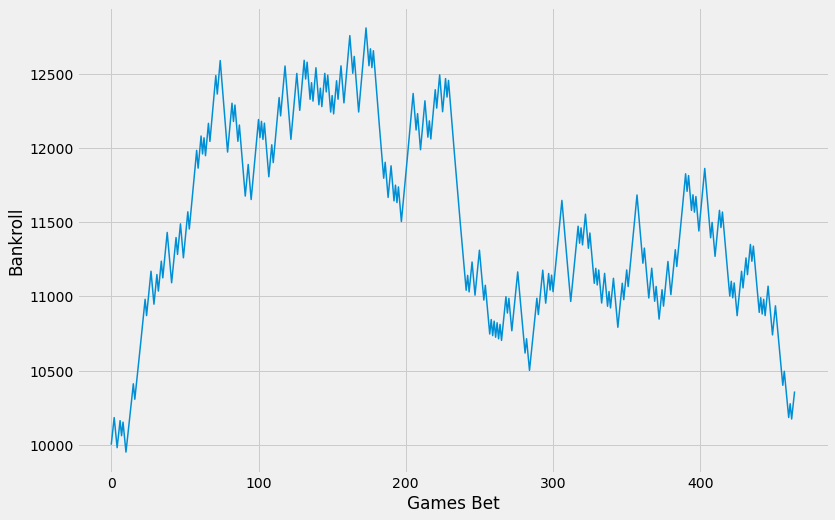

min balance: 9950.09990004999 
max balance: 12810.88004219596 
final balance: 10453.336924433996 
win percentage 53.12


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.996029         1.0   
1    18101 2015-11-07    14.0               -9 -7.310992         1.0   
2    18117 2015-11-09    10.5              -23 -4.056153         0.0   
3    18120 2015-11-10     6.5              -24  0.147166         0.0   
4    18129 2015-11-11     7.0               10 -0.599000         1.0   
..     ...        ...     ...              ...       ...         ...   
460  24070 2020-09-13     8.5               13 -0.781263         1.0   
461  24075 2020-09-19     3.5              -11  3.811741         0.0   
462  24078 2020-09-23     3.5                3  3.284565         1.0   
463  24085 2020-10-04     9.5               11 -0.555985         1.0   
464  24086 2020-10-06     7.5               -6  0.291481         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.496029  
1           1        1  10090.909091  10182.644628  100.909091    6.689008  
2           1        0  10182.644628  10080.818182  101.826446    6.443847  
3           1        0  10080.818182   9980.010000  100.808182    6.647166  
4           1        1   9980.010000  10070.737364   99.800100    6.401000  
..        ...      ...           ...           ...         ...         ...  
460         1        1  10183.535446  10276.113041  101.835354    7.718737  
461         1        0  10276.113041  10173.351910  102.761130    7.311741  
462         1        1  10173.351910  10265.836928  101.733519    6.784565  
463         1        1  10265.836928  10359.162718  102.658369    8.944015  
464         1        1  10359.162718  10453.336924  103.591627    7.791481  

[465 rows x 12 columns]

In [406]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])

params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
lasso_cv.fit(X_train, point_diff_train_windsor)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test)

select_bets_lasso, bet_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)

simulate_bets(select_bets_lasso)

### Light GBM

In [195]:
lgbr = lgb.LGBMClassifier()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMClassifier(objective='binary', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train_ewm_19, cover_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test_ewm_19)

print("score:", best_lgbr.score(X_test_ewm_19, cover_test))
print("best_lgbr:", best_lgbr)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


[LightGBM] [Warning] feature_fraction is set=0.36080331572739516, colsample_bytree=0.6947455051497893 will be ignored. Current value: feature_fraction=0.36080331572739516
score: 0.5195412064570943
best_lgbr: LGBMClassifier(colsample_bytree=0.6947455051497893,
               feature_fraction=0.36080331572739516, max_depth=28,
               min_child_weight=7, num_leaves=2, objective='binary',
               reg_alpha=0, reg_lambda=5, subsample=0.6256846823308025,
               subsample_freq=1)


In [199]:
lgbr_probs = best_lgbr.predict_proba(X_test_ewm_19)
lgbr_probs[:, 1]

array([0.53194702, 0.38957906, 0.48288096, ..., 0.49839439, 0.51081371,
       0.50611594])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


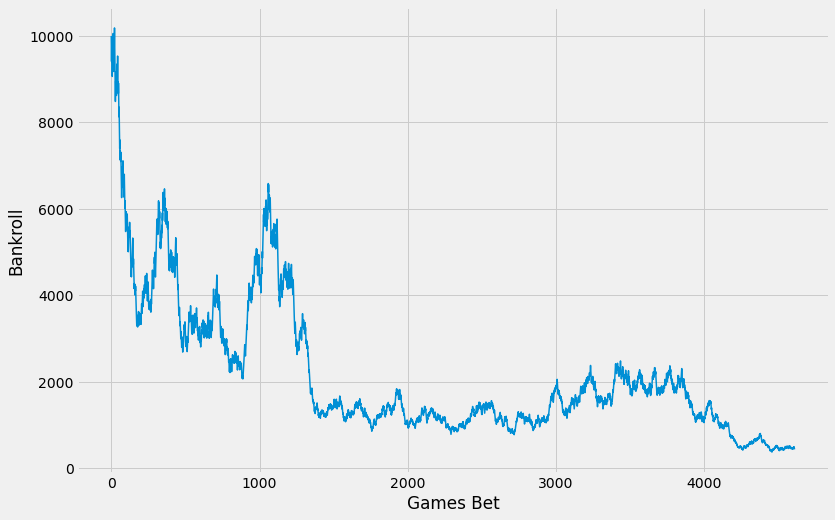

min balance: 371.230528958736 
max balance: 10184.657825469643 
final balance: 421.95756952699793 
win percentage 51.9


index            GAME_DATE  spread  point_diff_team      prob  \
0     11772  2016-11-04 00:00:00     3.5            -14.0  0.531947   
1     11773  2016-11-04 00:00:00    11.5             20.0  0.389579   
2     11774  2016-11-04 00:00:00    -2.5             -1.0  0.482881   
3     11775  2016-11-05 00:00:00    -3.5             17.0  0.548355   
4     11776  2016-11-05 00:00:00    -3.0             15.0  0.483019   
...     ...                  ...     ...              ...       ...   
4604  16475  2020-10-02 00:00:00   -11.0             10.0  0.521878   
4605  16476  2020-10-04 00:00:00     9.5             11.0  0.497057   
4606  16477  2020-10-06 00:00:00     7.5             -6.0  0.498394   
4607  16478  2020-10-09 00:00:00    -7.5             -3.0  0.510814   
4608  16479  2020-10-11 00:00:00     5.5            -13.0  0.506116   

      home_cover  bet_home  bet_won    bankroll_i   bankroll_n    bet_size  
0              0         1        0  10000.000000  9700.000000  300.000000  
1              1         0        0   9700.000000  9409.000000  291.000000  
2              0         0        1   9409.000000  9665.609091  282.270000  
3              1         1        1   9665.609091  9929.216612  289.968273  
4              1         0        0   9929.216612  9631.340113  297.876498  
...          ...       ...      ...           ...          ...         ...  
4604           0         1        0    491.371667   476.630517   14.741150  
4605           1         0        0    476.630517   462.331601   14.298916  
4606           1         0        0    462.331601   448.461653   13.869948  
4607           0         1        0    448.461653   435.007804   13.453850  
4608           0         1        0    435.007804   421.957570   13.050234  

[4609 rows x 11 columns]

In [204]:
lgbr_probs = best_lgbr.predict_proba(X_test_ewm_19)

select_bets_lgbr, confidence_thresholds_lgbr = find_optimal_threshold(final_df_ewm_19, lgbr_probs, test_indices)

simulate_bets(select_bets_lgbr)

In [205]:
lgbr_hd = lgb.LGBMClassifier()
lgbr_hf = lgb.LGBMClassifier()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs_hd = BayesSearchCV(lgb.LGBMClassifier(objective='binary', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs_hf = BayesSearchCV(lgb.LGBMClassifier(objective='binary', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs_hd.fit(X_train_hd, cover_train_hd)

lgbr_bs_hf.fit(X_train_hf, cover_train_hf)


best_lgbr_hd = lgbr_bs_hd.best_estimator_
best_lgbr_hf = lgbr_bs_hf.best_estimator_


lgbr_preds_hd = best_lgbr.predict(X_test_hd)
lgbr_preds_hf = best_lgbr.predict(X_test_hf)

print("home_dog_accuracy:", best_lgbr.score(X_test_hd, cover_test_hd))
print("home_fav_accuracy:", best_lgbr.score(X_test_hf, cover_test_hf))

print("best_lgbr_hd:", best_lgbr_hd)
print("best_lgbr_hd:", best_lgbr_hf)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


[LightGBM] [Warning] feature_fraction is set=0.9716619830559009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9716619830559009
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


home_dog_accuracy: 0.5225334957369062
home_fav_accuracy: 0.5150032615786041
best_lgbr_hd: LGBMClassifier(feature_fraction=0.9716619830559009, max_depth=26,
               min_child_weight=1, num_leaves=307, objective='binary',
               reg_alpha=0, reg_lambda=1, subsample=0.8768603074390553,
               subsample_freq=1)
best_lgbr_hd: LGBMClassifier(colsample_bytree=0.8484383577643959,
               feature_fraction=0.5535190724568329, max_depth=3,
               min_child_weight=6, num_leaves=2, objective='binary',
               reg_alpha=10, reg_lambda=1, subsample=0.8691676537039074,
               subsample_freq=1)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


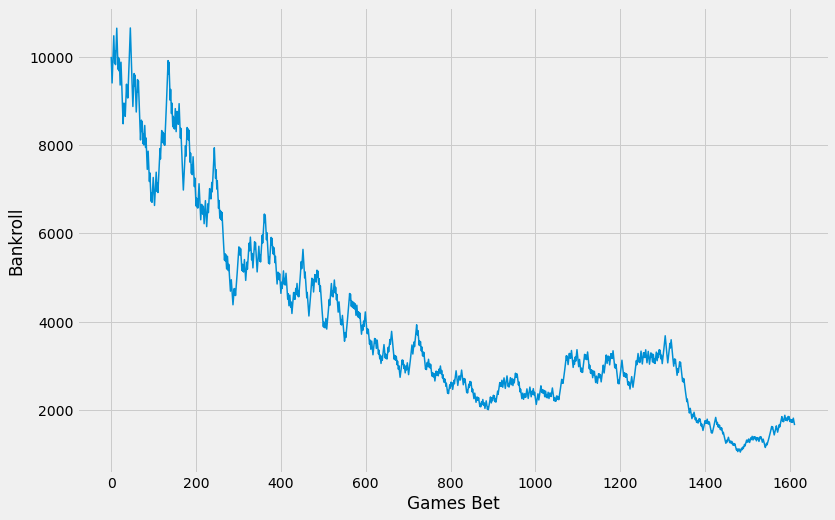

min balance: 1042.730106335981 
max balance: 10655.618015886093 
final balance: 1603.952348461566 
win percentage 51.12


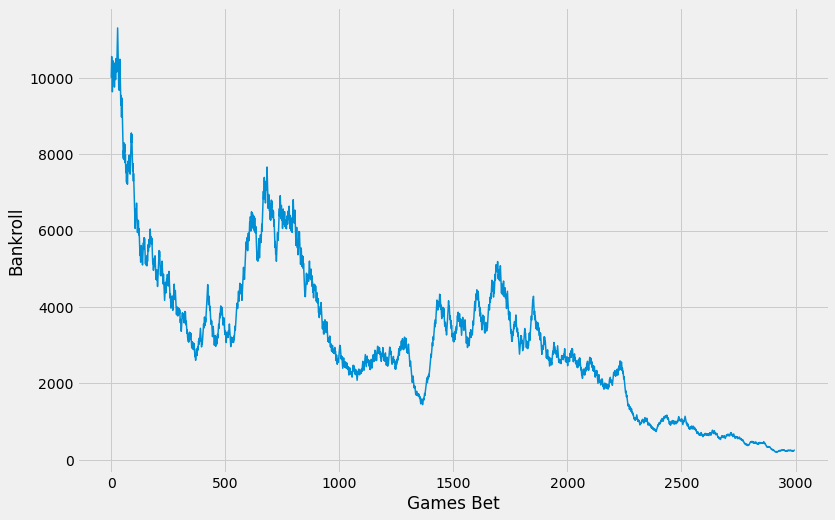

min balance: 200.54772624442307 
max balance: 11301.783106453828 
final balance: 236.4222302672948 
win percentage 50.92


index            GAME_DATE  spread  point_diff_team      prob  \
0     11774  2016-11-04 00:00:00    -2.5             -1.0  0.482881   
1     11775  2016-11-05 00:00:00    -3.5             17.0  0.548355   
2     11776  2016-11-05 00:00:00    -3.0             15.0  0.483019   
3     11777  2016-11-05 00:00:00    -3.5             26.0  0.478323   
4     11778  2016-11-05 00:00:00    -4.5            -24.0  0.547059   
...     ...                  ...     ...              ...       ...   
2992  16471  2020-09-25 00:00:00    -3.5             13.0  0.505999   
2993  16472  2020-09-26 00:00:00    -5.5             10.0  0.509285   
2994  16474  2020-09-30 00:00:00    -4.5             18.0  0.501672   
2995  16475  2020-10-02 00:00:00   -11.0             10.0  0.521878   
2996  16478  2020-10-09 00:00:00    -7.5             -3.0  0.510814   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0              0         0        1  10000.000000  10272.727273  300.000000  
1              1         1        1  10272.727273  10552.892562  308.181818  
2              1         0        0  10552.892562  10236.305785  316.586777  
3              1         0        0  10236.305785   9929.216612  307.089174  
4              0         1        0   9929.216612   9631.340113  297.876498  
...          ...       ...      ...           ...           ...         ...  
2992           1         1        1    231.786195    238.107637    6.953586  
2993           1         1        1    238.107637    244.601481    7.143229  
2994           1         1        1    244.601481    251.272431    7.338044  
2995           0         1        0    251.272431    243.734258    7.538173  
2996           0         1        0    243.734258    236.422230    7.312028  

[2997 rows x 11 columns]

In [206]:
lgbr_probs_hd = best_lgbr.predict_proba(X_test_hd)
lgbr_probs_hf = best_lgbr.predict_proba(X_test_hf)

select_bets_lgbr_hd, confidence_thresholds_lgbr_hd = find_optimal_threshold(final_df_ewm_19, lgbr_probs_hd, test_indices_hd)
select_bets_lgbr_hf, confidence_thresholds_lgbr_hf = find_optimal_threshold(final_df_ewm_19, lgbr_probs_hf, test_indices_hf)

simulate_bets(select_bets_lgbr_hd)
simulate_bets(select_bets_lgbr_hf)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 9)
num_games_bet: 436
win percetange at threshold: 0.5389908256880734


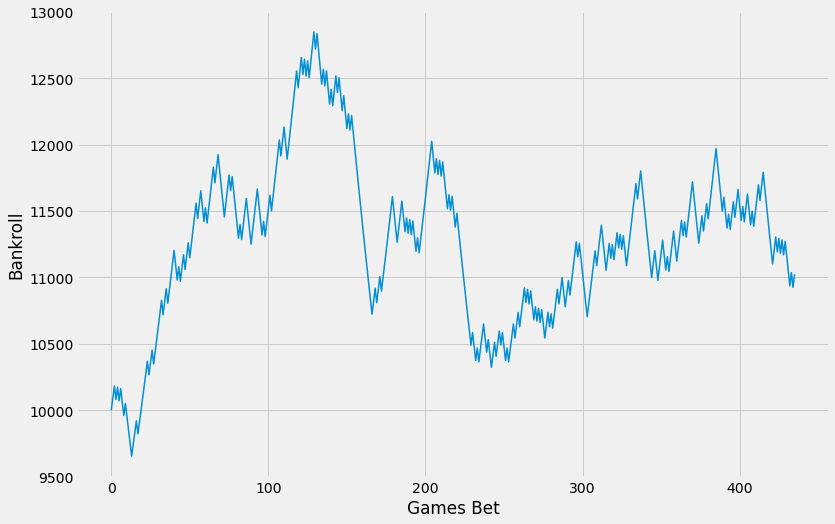

min balance: 9654.571982918605 
max balance: 12848.224738345409 
final balance: 11124.823175856578 
win percentage 53.900000000000006


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  3.271399         1.0   
1    18101 2015-11-07    14.0               -9 -7.818927         1.0   
2    18120 2015-11-10     6.5              -24 -0.227890         0.0   
3    18129 2015-11-11     7.0               10 -0.279020         1.0   
4    18134 2015-11-11     6.5              -12  0.083887         0.0   
..     ...        ...     ...              ...       ...         ...   
431  24068 2020-09-11     3.5               -5  3.730549         0.0   
432  24070 2020-09-13     8.5               13 -1.993378         1.0   
433  24075 2020-09-19     3.5              -11  2.722971         0.0   
434  24078 2020-09-23     3.5                3  2.983505         1.0   
435  24086 2020-10-06     7.5               -6  0.759078         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.771399  
1           1        1  10090.909091  10182.644628  100.909091    6.181073  
2           1        0  10182.644628  10080.818182  101.826446    6.272110  
3           1        1  10080.818182  10172.461983  100.808182    6.720980  
4           1        0  10172.461983  10070.737364  101.724620    6.583887  
..        ...      ...           ...           ...         ...         ...  
431         1        0  11046.681861  10936.215042  110.466819    7.230549  
432         1        1  10936.215042  11035.635179  109.362150    6.506622  
433         1        0  11035.635179  10925.278827  110.356352    6.222971  
434         1        1  10925.278827  11024.599544  109.252788    6.483505  
435         1        1  11024.599544  11124.823176  110.245995    8.259078  

[436 rows x 12 columns]

In [176]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.1883400819365125,
              max_depth=3, min_child_weight=1, num_leaf=2048,
              objective='regression', reg_alpha=10, reg_lambda=9,
              subsample_freq=1)

best_lgbr.fit(X_train, point_diff_train)
lgbr_preds = best_lgbr.predict(X_test)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

#### LGB EWM

y_pred                 grad hess
40    -2.0                 -8.0   -2
41    -1.8   -7.599999999999998   -2
42    -1.6   -7.199999999999999   -2
43    -1.4   -6.800000000000001   -2
44    -1.2   -6.399999999999999   -2
45    -1.0                 -6.0   -2
46    -0.8   -5.599999999999998   -2
47    -0.6   -5.199999999999999   -2
48    -0.4   -4.799999999999997   -2
49    -0.2   -4.399999999999999   -2
50     0.0                 -4.0   -2
51     0.2   -3.599999999999998   -2
52     0.4  -3.1999999999999993   -2
53     0.6   -2.799999999999997   -2
54     0.8  -2.3999999999999986   -2
55     1.0                 -2.0   -2
56     1.2  -1.5999999999999979   -2
57     1.4  -1.1999999999999993   -2
58     1.6  -0.7999999999999972   -2
59     1.8  -0.3999999999999986   -2
60     2.0                 -0.0  -20

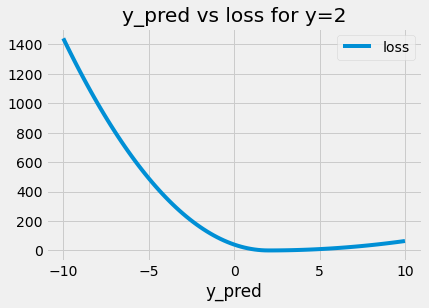

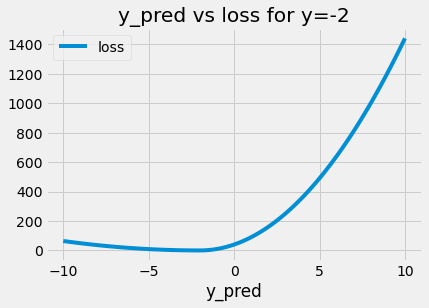

In [106]:
def custom_loss(y_true, y_pred):
    
    residual = (y_true - y_pred).astype(float)
    condlist = [y_true<0, y_true>0]
    choicelist_grad = [np.where(residual<0, 2*10*residual, 2*residual), np.where(residual>0, -2*residual, -10*2*residual)]
    choicelist_hess = [np.where(residual<0, 2*10, 2), np.where(residual>0, -2, -2*10)]

    grad = np.select(condlist, choicelist_grad)
    hess = np.select(condlist, choicelist_hess)

    return grad, hess
    

def custom_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype(float)
    condlist = [y_true<0, y_true>0]
    choicelist = [np.where(residual<0, 10*residual**2, residual**2), np.where(residual<0, residual**2, 10*residual**2)]
    loss = np.select(condlist, choicelist)
    return "custom_eval", loss, False 

df = pd.DataFrame(
[(y_pred, custom_eval(2, y_pred)[1]) for y_pred in np.linspace(-10, 10, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=2')

df = pd.DataFrame(
[(y_pred, custom_eval(-2, y_pred)[1]) for y_pred in np.linspace(-10, 10, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=-2')

df = pd.DataFrame(
[(y_pred, custom_loss(2, y_pred)[0], custom_loss(2, y_pred)[1]) for y_pred in np.linspace(-10, 10, 101)], columns=['y_pred', 'grad', 'hess'])
# df.plot(x='y_pred', y=['grad', 'hess'], title='y_pred vs grad, hess for y=2')

df.loc[40:60]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.01
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


best_metric_hd: 0.5195439739413681
best_metric_hf: 0.5083890126206384


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 4.34
num_games_bet: 65
win percetange at threshold: 0.6461538461538462


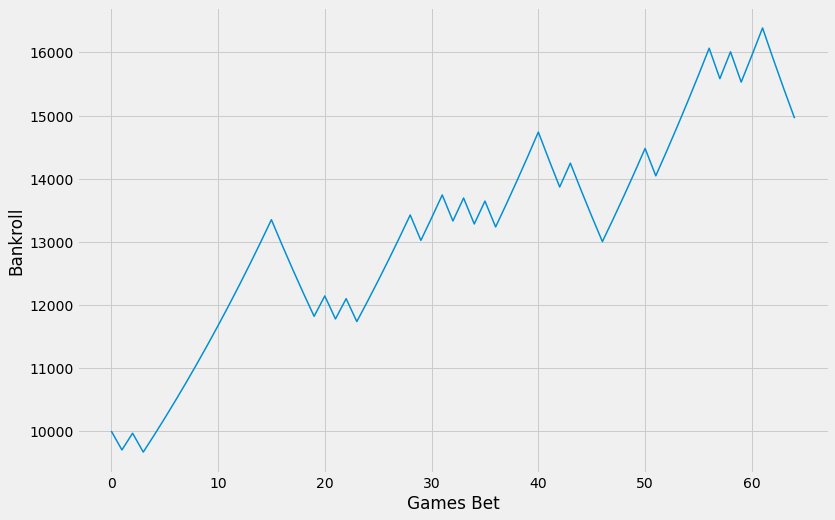

min balance: 9665.60909090909 
max balance: 16388.936655573478 
final balance: 15365.678347459092 
win percentage 64.62


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.74
num_games_bet: 284
win percetange at threshold: 0.5669014084507042


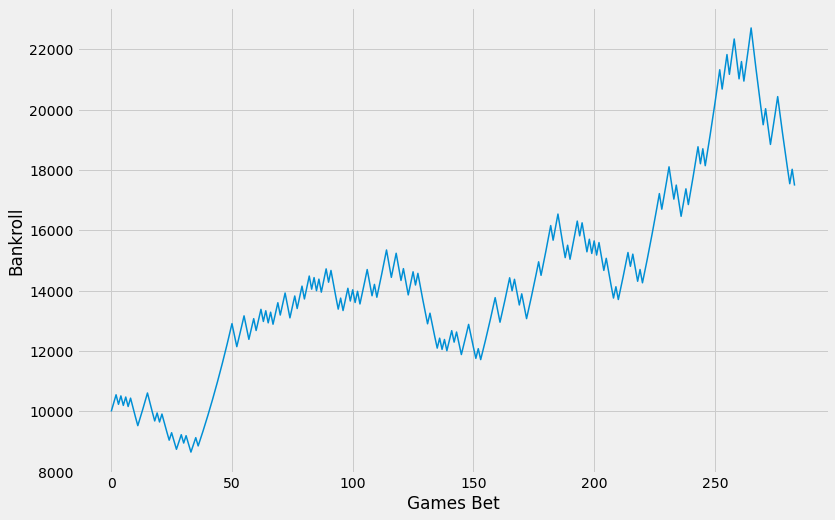

min balance: 8653.216937267427 
max balance: 22708.231326572786 
final balance: 17960.995543362555 
win percentage 56.69


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11789  2016-11-08 00:00:00    -4.0            -12.0         -2.252701   
1    11796  2016-11-09 00:00:00    -3.0            -16.0         -2.092044   
2    11816  2016-11-12 00:00:00   -10.0             11.0         -1.946789   
3    11831  2016-11-14 00:00:00   -11.0              4.0         -2.295050   
4    11856  2016-11-17 00:00:00    -5.5              7.0         -1.970031   
..     ...                  ...     ...              ...               ...   
279  16307  2020-03-09 00:00:00    -7.5             14.0         -2.224083   
280  16319  2020-03-11 00:00:00   -12.0             18.0         -1.771514   
281  16359  2020-08-08 00:00:00    -4.5             -5.0         -1.783918   
282  16360  2020-08-08 00:00:00    -1.5              2.0         -1.864686   
283  16405  2020-08-19 00:00:00    -3.5            -19.0         -2.383480   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0.0         0        1  10000.000000  10272.727273  300.000000  
1           0.0         0        1  10272.727273  10552.892562  308.181818  
2           1.0         0        0  10552.892562  10236.305785  316.586777  
3           0.0         0        1  10236.305785  10515.477761  307.089174  
4           1.0         0        0  10515.477761  10200.013428  315.464333  
..          ...       ...      ...           ...           ...         ...  
279         1.0         0        0  18648.490586  18089.035869  559.454718  
280         1.0         0        0  18089.035869  17546.364793  542.671076  
281         0.0         0        1  17546.364793  18024.902014  526.390944  
282         1.0         0        0  18024.902014  17484.154954  540.747060  
283         0.0         0        1  17484.154954  17960.995543  524.524649  

[284 rows x 11 columns]

In [178]:
search_spaces = {'min_child_weight':Integer(6,12),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(12, 20),
              'reg_alpha': Integer(12, 20),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'feature_fraction':Real(0.01, 1),
                'num_leaves':Integer(2, 2048)}
 
lgb_custom_hd = lgb.LGBMRegressor()   
# lgb_custom_hd.set_params(**{'objective':custom_loss}, metrics=['mse','mae'])
   
    
lgb_custom_hf = lgb.LGBMRegressor()   
# lgb_custom_hf.set_params(**{'objective':custom_loss}, metrics=['mse','mae'])

lgbr_bs_hd = BayesSearchCV(lgb_custom_hd,
                        search_spaces=search_spaces, 
                        cv=tscv, scoring=bet_accuracy, verbose=1, n_jobs=-1)

lgbr_bs_hf = BayesSearchCV(lgb_custom_hf,
                        search_spaces=search_spaces, 
                        cv=tscv, scoring=bet_accuracy, verbose=1, n_jobs=-1)

lgbr_bs_hd.fit(X_train_hd, 
               y_train_hd)

lgbr_bs_hf.fit(X_train_hf, 
               y_train_hf)

best_lgbr_hd = lgbr_bs_hd.best_estimator_
best_lgbr_hf = lgbr_bs_hf.best_estimator_

print("best_metric_hd:", lgbr_bs_hd.best_score_)
print("best_metric_hf:", lgbr_bs_hf.best_score_)


lgbr_preds_hd = best_lgbr_hd.predict(X_test_hd)
lgbr_preds_hf = best_lgbr_hf.predict(X_test_hf)

select_bets_lgbr_hd, bet_thresholds_lgb_hd = find_optimal_confidence_thresholds(lgbr_preds_hd, test_indices_hd)
simulate_bets(select_bets_lgbr_hd)

select_bets_lgbr_hf, bet_thresholds_lgb_hf = find_optimal_confidence_thresholds(lgbr_preds_hf, test_indices_hf)
simulate_bets(select_bets_lgbr_hf)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


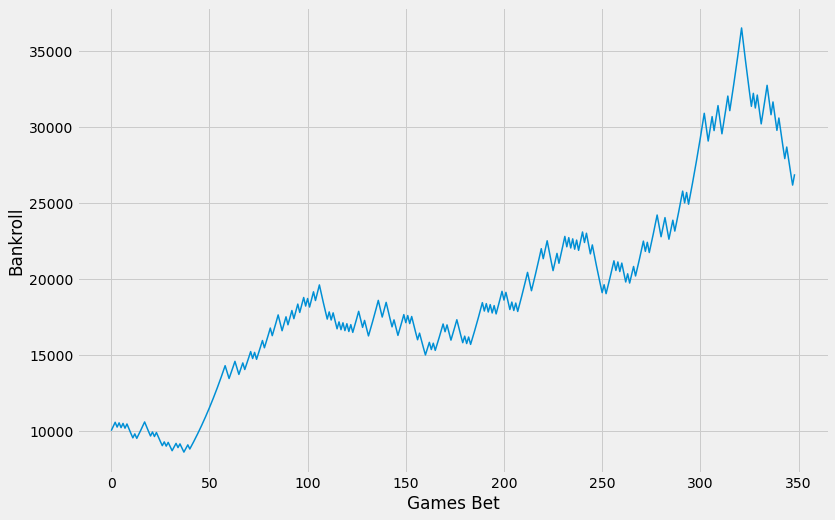

min balance: 8591.966535703676 
max balance: 36486.595570608246 
final balance: 27598.28803194551 
win percentage 58.17


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11789  2016-11-08 00:00:00    -4.0            -12.0         -2.252701   
1    11796  2016-11-09 00:00:00    -3.0            -16.0         -2.092044   
2    11816  2016-11-12 00:00:00   -10.0             11.0         -1.946789   
3    11831  2016-11-14 00:00:00   -11.0              4.0         -2.295050   
4    11856  2016-11-17 00:00:00    -5.5              7.0         -1.970031   
..     ...                  ...     ...              ...               ...   
344  16360  2020-08-08 00:00:00    -1.5              2.0         -1.864686   
345  16367  2020-08-09 00:00:00     4.5            -17.0          5.939129   
346  16383  2020-08-12 00:00:00     5.5            -13.0          5.632047   
347  16403  2020-08-18 00:00:00     1.0             15.0          4.499581   
348  16405  2020-08-19 00:00:00    -3.5            -19.0         -2.383480   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0             0         0        1  10000.000000  10272.727273  300.000000  
1             0         0        1  10272.727273  10552.892562  308.181818  
2             1         0        0  10552.892562  10236.305785  316.586777  
3             0         0        1  10236.305785  10515.477761  307.089174  
4             1         0        0  10515.477761  10200.013428  315.464333  
..          ...       ...      ...           ...           ...         ...  
344           1         0        0  28654.670801  27795.030677  859.640124  
345           0         1        0  27795.030677  26961.179757  833.850920  
346           0         1        0  26961.179757  26152.344364  808.835393  
347           1         1        1  26152.344364  26865.590120  784.570331  
348           0         0        1  26865.590120  27598.288032  805.967704  

[349 rows x 11 columns]

In [179]:
betting_df_lgbr = create_betting_df(final_df_ewm_19, lgbr_preds_hd, lgbr_preds_hf, test_indices)
betting_df_lgbr

select_bets_lgbr = betting_df_lgbr.loc[((betting_df_lgbr['spread'] >= 0) & (abs(betting_df_lgbr['confidence_preds']) >= 4.34))
                                    | ((betting_df_lgbr['spread'] < 0) & (abs(betting_df_lgbr['confidence_preds']) >= 1.74))]


simulate_bets(select_bets_lgbr)

In [120]:

# simulate_bets(select_bets)

In [654]:
spread_point_diff_test_ewm_19.median()

0.0

### One Model

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


[LightGBM] [Warning] feature_fraction is set=0.3414521698850995, colsample_bytree=0.6190591752351929 will be ignored. Current value: feature_fraction=0.3414521698850995
best_lgbr: LGBMRegressor(colsample_bytree=0.6190591752351929,
              feature_fraction=0.3414521698850995, max_depth=45,
              min_child_weight=12, num_leaves=577, objective='regression',
              reg_alpha=21, reg_lambda=30, subsample=0.6998090434957311,
              subsample_freq=1)
mae 9.982860210226953


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.36
num_games_bet: 2923
win percetange at threshold: 0.5302771125555936


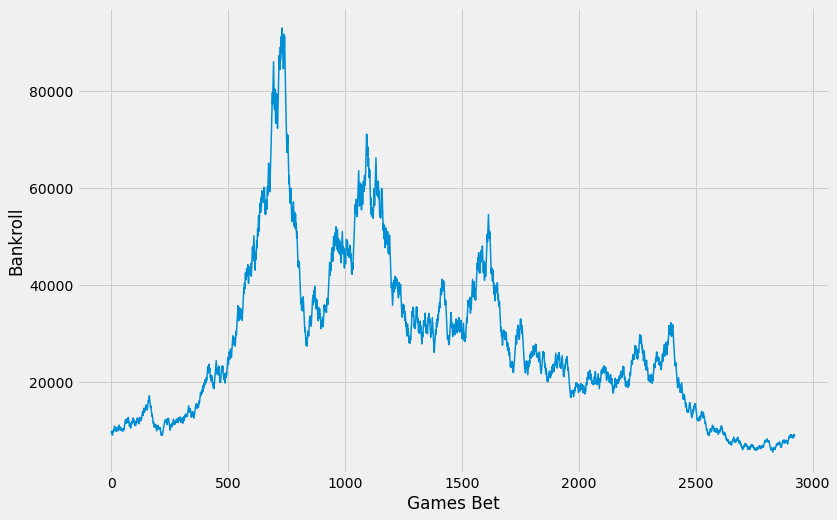

min balance: 5609.964785754719 
max balance: 92987.81047953945 
final balance: 8923.116262574784 
win percentage 53.03


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11774  2016-11-04 00:00:00    -2.5             -1.0          2.787636   
1     11777  2016-11-05 00:00:00    -3.5             26.0         -1.687180   
2     11778  2016-11-05 00:00:00    -4.5            -24.0         -1.468269   
3     11779  2016-11-06 00:00:00    -7.5             -5.0          3.402604   
4     11784  2016-11-07 00:00:00    -5.5             12.0         -3.230177   
...     ...                  ...     ...              ...               ...   
2918  16472  2020-09-26 00:00:00    -5.5             10.0          1.626350   
2919  16473  2020-09-27 00:00:00     3.0             12.0          2.005433   
2920  16475  2020-10-02 00:00:00   -11.0             10.0          2.219670   
2921  16476  2020-10-04 00:00:00     9.5             11.0          3.609924   
2922  16478  2020-10-09 00:00:00    -7.5             -3.0          4.314337   

      home_cover  bet_home  bet_won    bankroll_i   bankroll_n    bet_size  
0            0.0         1        0  10000.000000  9700.000000  300.000000  
1            1.0         0        0   9700.000000  9409.000000  291.000000  
2            0.0         0        1   9409.000000  9665.609091  282.270000  
3            0.0         1        0   9665.609091  9375.640818  289.968273  
4            1.0         0        0   9375.640818  9094.371594  281.269225  
...          ...       ...      ...           ...          ...         ...  
2918         1.0         1        1   8748.141682  8986.727364  262.444250  
2919         1.0         1        1   8986.727364  9231.819928  269.601821  
2920         0.0         1        0   9231.819928  8954.865331  276.954598  
2921         1.0         1        1   8954.865331  9199.088930  268.645960  
2922         0.0         1        0   9199.088930  8923.116263  275.972668  

[2923 rows x 11 columns]

In [180]:


search_spaces = {'min_child_weight':Integer(6,12),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(25, 45),
              'reg_lambda': Integer(15, 30),
              'reg_alpha': Integer(15, 30),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'feature_fraction':Real(0.01, 1),
                'num_leaves':Integer(2, 2048)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1),
                        search_spaces=search_spaces, scoring=bet_accuracy, 
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train_ewm_19, y_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test_ewm_19)

print("best_lgbr:", best_lgbr)
print("mae", mean_absolute_error(y_test, lgbr_preds))

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

[LightGBM] [Warning] feature_fraction is set=0.04173514655921379, colsample_bytree=0.6851825473172422 will be ignored. Current value: feature_fraction=0.04173514655921379


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.4
num_games_bet: 2288
win percetange at threshold: 0.5402097902097902


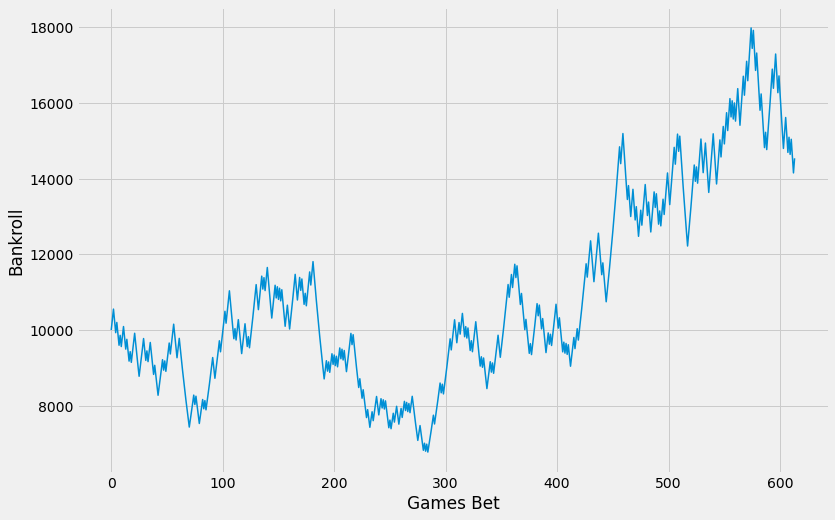

min balance: 6773.170311740314 
max balance: 17984.27966271569 
final balance: 14935.330970102628 
win percentage 54.230000000000004


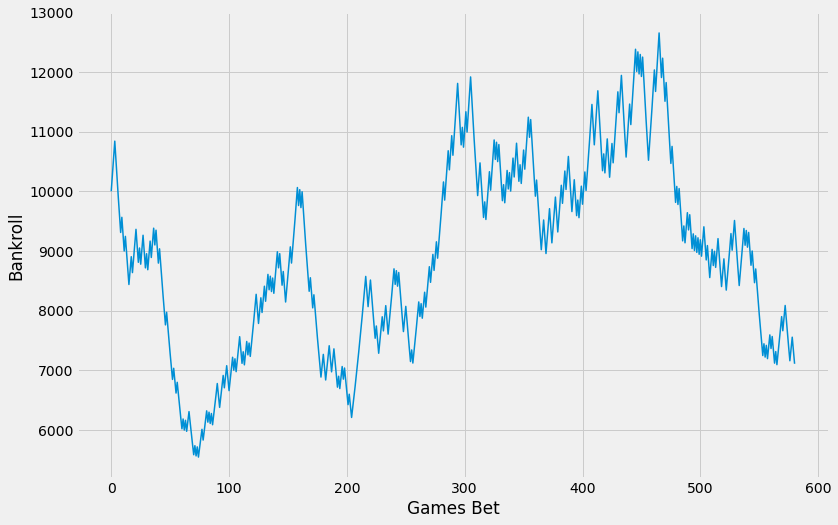

min balance: 5541.343003917143 
max balance: 12655.41737093809 
final balance: 6893.072946757851 
win percentage 51.980000000000004


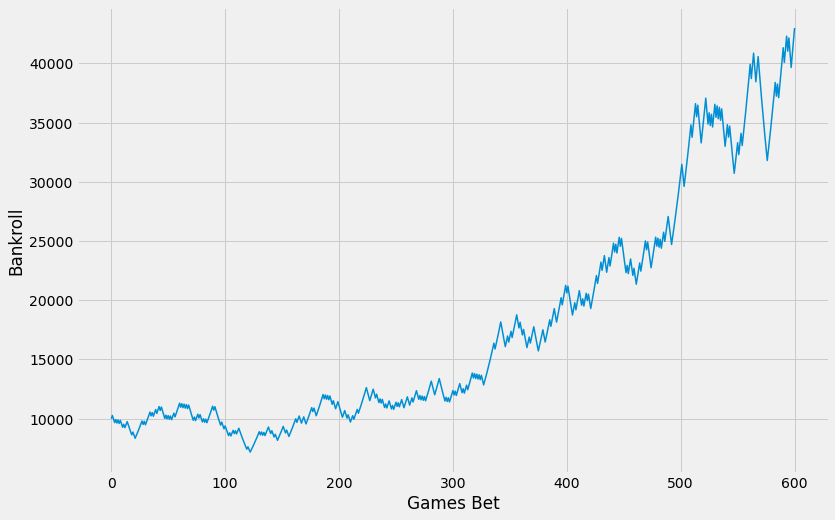

min balance: 7179.248728937713 
max balance: 44172.359124134186 
final balance: 44172.359124134186 
win percentage 57.4


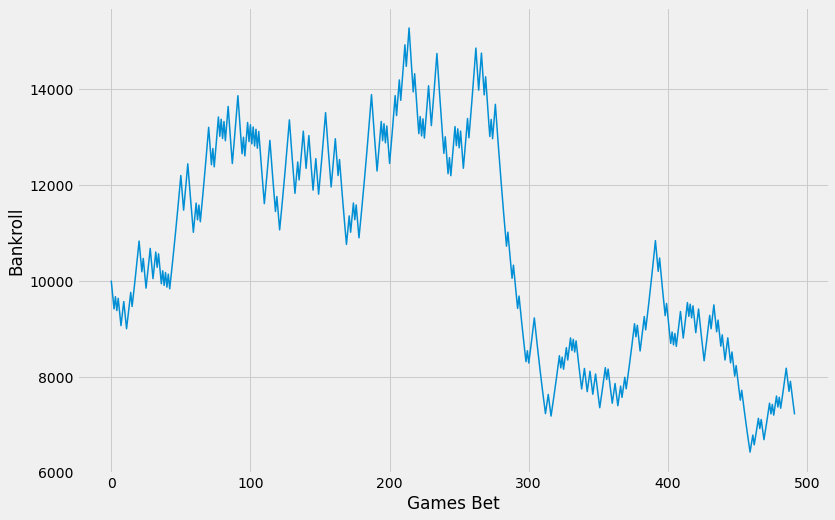

min balance: 6425.925794988701 
max balance: 15266.800979955337 
final balance: 7407.700550687393 
win percentage 52.03


In [140]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.6851825473172422,
              feature_fraction=0.04173514655921379, max_depth=30,
              min_child_weight=10, num_leaves=2, objective='regression',
              reg_alpha=20, reg_lambda=19, subsample=0.9620069228362871,
              subsample_freq=1)

best_lgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lgbr_preds = best_lgbr.predict(X_test_ewm_19)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)

for season_idx in [test_indices_16, test_indices_17, test_indices_18, test_indices_19]:
    simulate_bets(select_bets_lgbr.loc[select_bets_lgbr.index.isin(season_idx)])


In [257]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)


best_lgbr.fit(features_ewm_19, spread_point_diff_ewm_19)

with open("../models/lgbr_ewm_19.pkl", 'wb') as file:
    pickle.dump(best_lgbr, file)

#### Windsor Outliers

[LightGBM] [Warning] feature_fraction is set=0.1883400819365125, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.1883400819365125
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (8, 17)
num_games_bet: 171
win percetange at threshold: 0.5380116959064327


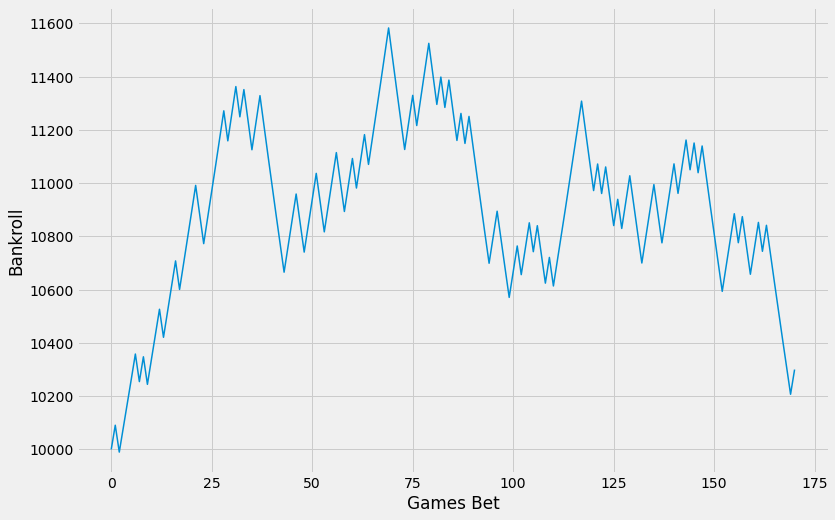

min balance: 9990.0 
max balance: 11582.779387449224 
final balance: 10393.633221062377 
win percentage 53.800000000000004


index  GAME_DATE  spread  point_diff_team      preds  home_cover  \
0    18092 2015-11-05     4.5               19   3.696667         1.0   
1    18149 2015-11-13   -10.5               19   2.493992         1.0   
2    18403 2015-12-18   -19.0                9  10.708798         0.0   
3    18467 2015-12-27   -16.5               10   8.320785         0.0   
4    18476 2015-12-28     9.5               -4  -1.305530         1.0   
..     ...        ...     ...              ...        ...         ...   
166  24032 2020-08-23    14.0              -28  -3.620051         0.0   
167  24037 2020-08-24    13.0              -15  -1.447412         0.0   
168  24044 2020-08-30     9.5              -14  -1.326969         0.0   
169  24085 2020-10-04     9.5               11   0.096549         1.0   
170  24086 2020-10-06     7.5               -6   0.688193         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    8.196667  
1           0        0  10090.909091   9990.000000  100.909091   -8.006008  
2           0        1   9990.000000  10080.818182   99.900000   -8.291202  
3           0        1  10080.818182  10172.461983  100.808182   -8.179215  
4           1        1  10172.461983  10264.938911  101.724620    8.194470  
..        ...      ...           ...           ...         ...         ...  
166         1        0  10519.648192  10414.451710  105.196482   10.379949  
167         1        0  10414.451710  10310.307193  104.144517   11.552588  
168         1        0  10310.307193  10207.204121  103.103072    8.173031  
169         1        1  10207.204121  10299.996886  102.072041    9.596549  
170         1        1  10299.996886  10393.633221  102.999969    8.188193  

[171 rows x 12 columns]

In [407]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.1883400819365125,
              max_depth=3, min_child_weight=1, num_leaf=2048,
              objective='regression', reg_alpha=10, reg_lambda=9,
              subsample_freq=1)

best_lgbr.fit(X_train, point_diff_train_windsor)
lgbr_preds = best_lgbr.predict(X_test)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

### ADA Boost

In [218]:
ada = AdaBoostRegressor()
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_bs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_bs.fit(X_train, point_diff_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


OrderedDict([('learning_rate', 0.020117684599365193), ('loss', 'exponential'), ('n_estimators', 245)])
AdaBoostRegressor(learning_rate=0.020117684599365193, loss='exponential',
                  n_estimators=245)


NameError: name 'best_ada' is not defined

OrderedDict([('learning_rate', 0.020117684599365193), ('loss', 'exponential'), ('n_estimators', 245)])
AdaBoostRegressor(learning_rate=0.020117684599365193, loss='exponential',
                  n_estimators=245)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 251
win percetange at threshold: 0.5378486055776892


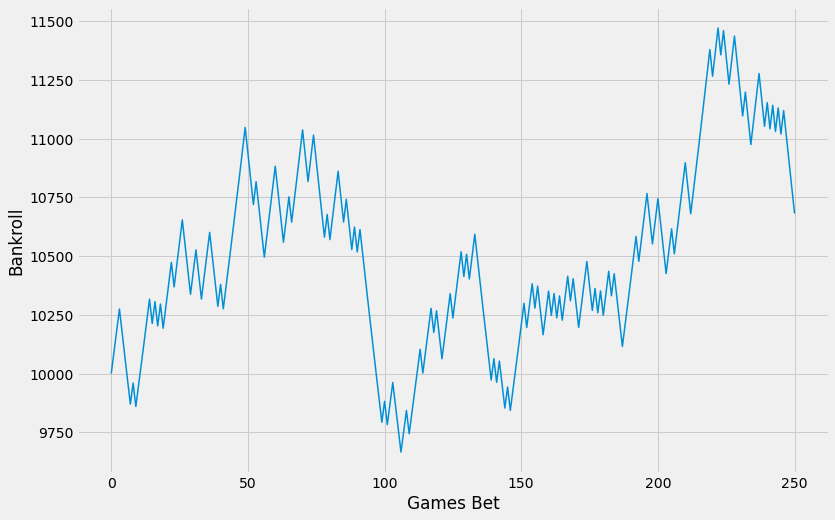

min balance: 9666.42698820673 
max balance: 11471.110954031808 
final balance: 10574.80123675306 
win percentage 53.779999999999994


index  GAME_DATE  spread  point_diff_team      preds  home_cover  \
0    18092 2015-11-05     4.5               19   1.699086         1.0   
1    18129 2015-11-11     7.0               10  -0.352165         1.0   
2    18146 2015-11-13     6.5                9  -0.224871         1.0   
3    18194 2015-11-20    -6.5               -3  12.524220         0.0   
4    18222 2015-11-24     7.0              -17  -0.367004         0.0   
..     ...        ...     ...              ...        ...         ...   
246  24060 2020-09-07     1.5              -22   4.563356         0.0   
247  24064 2020-09-09     8.0              -11  -1.760716         0.0   
248  24066 2020-09-10     5.5              -10   0.973437         0.0   
249  24068 2020-09-11     3.5               -5   3.114026         0.0   
250  24088 2020-10-11     5.5              -13   0.744810         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    6.199086  
1           1        1  10090.909091  10182.644628  100.909091    6.647835  
2           1        1  10182.644628  10275.214125  101.826446    6.275129  
3           1        0  10275.214125  10172.461983  102.752141    6.024220  
4           1        0  10172.461983  10070.737364  101.724620    6.632996  
..        ...      ...           ...           ...         ...         ...  
246         1        0  11119.781156  11008.583345  111.197812    6.063356  
247         1        0  11008.583345  10898.497511  110.085833    6.239284  
248         1        0  10898.497511  10789.512536  108.984975    6.473437  
249         1        0  10789.512536  10681.617411  107.895125    6.614026  
250         1        0  10681.617411  10574.801237  106.816174    6.244810  

[251 rows x 12 columns]

In [219]:
best_ada = ada_bs.best_estimator_
print(ada_bs.best_params_)
print(best_ada_)

ada_preds = best_ada.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_preds, test_indices)
simulate_bets(select_bets_ada)

#### Predicting Spread + Actual Point Diff

In [533]:
ada = AdaBoostRegressor()
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_bs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_bs.fit(X_train_spread, spread_point_diff_train)
best_ada = ada_bs.best_estimator_
ada_preds = best_ada.predict(X_test_spread)
print(best_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished


ValueError: Number of features of the model must match the input. Model n_features is 85 and input n_features is 84 

AdaBoostRegressor(learning_rate=0.010033907692549427, loss='exponential',
                  n_estimators=63)
best thresholds: 0.9
num_games_bet: 253
win percetange at threshold: 0.549407114624506


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


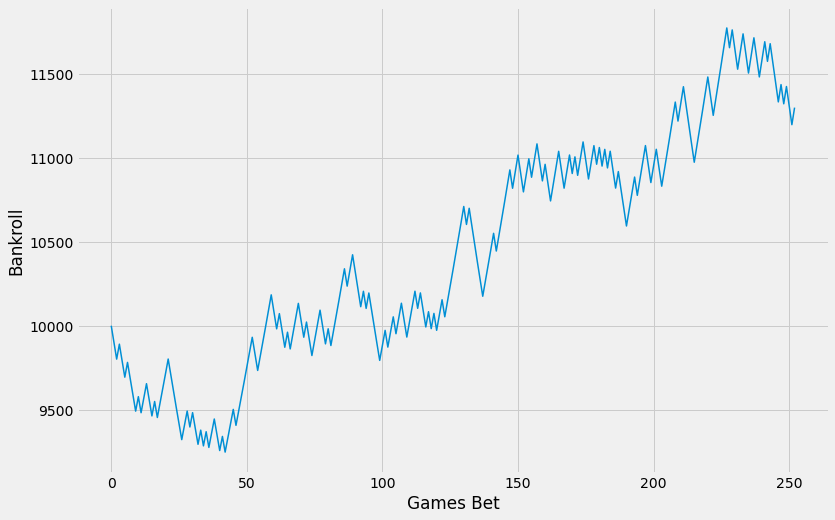

min balance: 9246.767877997183 
max balance: 11775.025317977676 
final balance: 11187.241117113286 
win percentage 54.94


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11779 2016-11-05    -3.0               15         -1.347784         1.0   
1    11786 2016-11-07    -7.0               32         -1.119785         1.0   
2    11792 2016-11-08    -4.0              -12         -1.392420         0.0   
3    11797 2016-11-09   -18.5               21         -0.942622         1.0   
4    11800 2016-11-09    -1.5               25         -1.119785         1.0   
..     ...        ...     ...              ...               ...         ...   
248  16377 2020-08-08    -4.5               -5         -1.251684         0.0   
249  16395 2020-08-11    -4.5               18         -1.055861         1.0   
250  16411 2020-08-17    -4.5               10         -1.055861         1.0   
251  16419 2020-08-19    -3.5              -19         -0.942622         0.0   
252  16464 2020-09-06    -6.0                8         -1.184279         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        0   9890.100000   9791.199000   98.901000  
4           0        0   9791.199000   9693.287010   97.911990  
..        ...      ...           ...           ...         ...  
248         0        1  11322.877986  11425.813240  113.228780  
249         0        0  11425.813240  11311.555108  114.258132  
250         0        0  11311.555108  11198.439557  113.115551  
251         0        1  11198.439557  11300.243553  111.984396  
252         0        0  11300.243553  11187.241117  113.002436  

[253 rows x 11 columns]

In [535]:
ada_preds = best_ada.predict(X_test_spread)
print(best_ada)
select_bets_ada, best_thresholds_ada= find_optimal_confidence_thresholds(ada_preds, test_indices)
simulate_bets(select_bets_ada)

### ADA EWM

In [268]:
ada = AdaBoostRegressor()
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_bs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
best_ada = ada_bs.best_estimator_
ada_preds = best_ada.predict(X_test_ewm_19)
print(best_ada)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.3s finished


AdaBoostRegressor(learning_rate=0.018299057468318947, n_estimators=55)


best thresholds: 0.6


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 604
win percetange at threshold: 0.5347682119205298


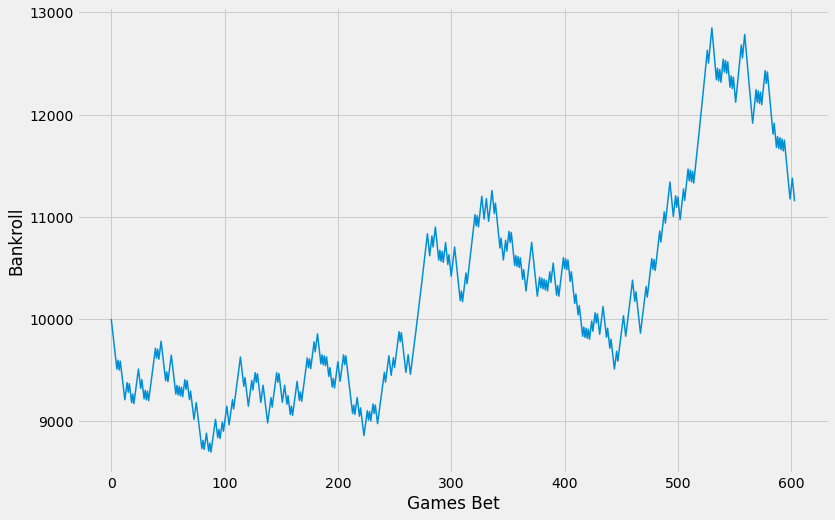

min balance: 8697.731299218214 
max balance: 12847.601390204 
final balance: 11040.138555570657 
win percentage 53.480000000000004


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11778 2016-11-05    -3.0               15         -0.678542         1.0   
1    11779 2016-11-05    -3.5               26         -0.678542         1.0   
2    11781 2016-11-06    -4.0               11         -0.788871         1.0   
3    11786 2016-11-07    -5.5               12         -0.791502         1.0   
4    11787 2016-11-07    -7.0               32         -0.791502         1.0   
..     ...        ...     ...              ...               ...         ...   
599  16419 2020-08-19    -3.5              -19         -0.791502         0.0   
600  16460 2020-09-04    -5.5              -15         -0.678542         0.0   
601  16464 2020-09-06    -6.0                8         -0.661128         1.0   
602  16468 2020-09-08     4.5              -10          0.859662         0.0   
603  16471 2020-09-10     5.5              -10          0.761373         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        0   9702.990000   9605.960100   97.029900  
4           0        0   9605.960100   9509.900499   96.059601  
..        ...      ...           ...           ...         ...  
599         0        1  11173.991916  11275.573661  111.739919  
600         0        1  11275.573661  11378.078876  112.755737  
601         0        0  11378.078876  11264.298088  113.780789  
602         1        0  11264.298088  11151.655107  112.642981  
603         1        0  11151.655107  11040.138556  111.516551  

[604 rows x 11 columns]

In [269]:
select_bets_ada, best_thresholds_ada= find_optimal_confidence_thresholds(ada_preds, test_indices)
simulate_bets(select_bets_ada)

In [271]:
ada = AdaBoostRegressor(learning_rate=0.018299057468318947, n_estimators=55)

ada.fit(features_ewm_19, spread_point_diff_ewm_19)

AdaBoostRegressor(learning_rate=0.018299057468318947, n_estimators=55)

In [272]:
with open('../models/ada_ewm_19.pkl', 'wb') as file:
    pickle.dump(ada, file)

### Linear SVR

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.4s remaining:   50.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.4s remaining:   56.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.6s remaining:   59.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   40.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.0s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.0012612108028070067,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.0012612108028070067), ('svr__loss', 'squared_epsilon_insensitive')])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 219
win percetange at threshold: 0.54337899543379


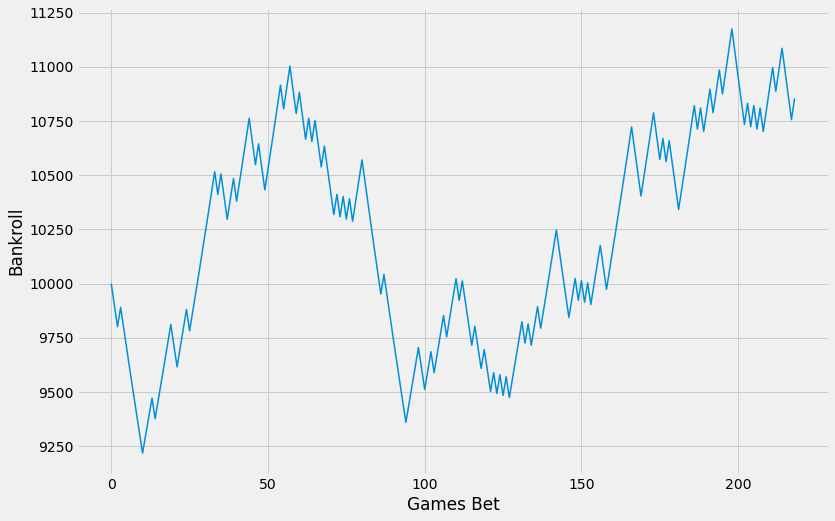

min balance: 9218.219497334923 
max balance: 11174.534063364625 
final balance: 10745.444899699582 
win percentage 54.339999999999996


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18117 2015-11-09    10.5              -23 -4.182974         0.0   
1    18120 2015-11-10     6.5              -24 -0.221833         0.0   
2    18129 2015-11-11     7.0               10 -0.633952         1.0   
3    18149 2015-11-13   -10.5               19  4.083691         1.0   
4    18282 2015-12-02     2.0              -12  4.181433         0.0   
..     ...        ...     ...              ...       ...         ...   
214  23994 2020-08-12     5.5              -13  0.817356         0.0   
215  23998 2020-08-13    -8.5               26  1.989913         1.0   
216  24022 2020-08-21     5.0               -8  1.272599         0.0   
217  24031 2020-08-23     7.0               -4 -0.837056         1.0   
218  24034 2020-08-24     7.0              -20 -0.563648         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        0  10000.000000   9900.000000  100.000000    6.317026  
1           1        0   9900.000000   9801.000000   99.000000    6.278167  
2           1        1   9801.000000   9890.100000   98.010000    6.366048  
3           0        0   9890.100000   9791.199000   98.901000   -6.416309  
4           1        0   9791.199000   9693.287010   97.911990    6.181433  
..        ...      ...           ...           ...         ...         ...  
214         1        0  11085.450053  10974.595552  110.854501    6.317356  
215         0        0  10974.595552  10864.849597  109.745956   -6.510087  
216         1        0  10864.849597  10756.201101  108.648496    6.272599  
217         1        1  10756.201101  10853.984747  107.562011    6.162944  
218         1        0  10853.984747  10745.444900  108.539847    6.436352  

[219 rows x 12 columns]

In [220]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
svr_bs.fit(X_train, point_diff_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [524]:
select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

ValueError: Length of values (4720) does not match length of index (5998)

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

In [186]:
pipeline_svr_hd = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


pipeline_svr_hf = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs_hd = BayesSearchCV(pipeline_svr_hd, search_spaces=search_spaces, 
                          scoring=bet_accuracy, n_jobs=-1, cv=tscv, verbose=1)
svr_bs_hf = BayesSearchCV(pipeline_svr_hf, search_spaces=search_spaces, 
                          scoring=bet_accuracy, n_jobs=-1, cv=tscv, verbose=1)

svr_bs_hd.fit(X_train_hd, y_train_hd)
svr_bs_hf.fit(X_train_hf, y_train_hf)

print("best home_dog estimator:", svr_bs_hd.best_estimator_)
print("best home_fav estimator:", svr_bs_hf.best_estimator_)
best_svr_hd = svr_bs_hd.best_estimator_
best_svr_hf = svr_bs_hf.best_estimator_





Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


best home_dog estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=1.0034001753684262e-06, max_iter=10000))])
best home_fav estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.015156348996403609,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


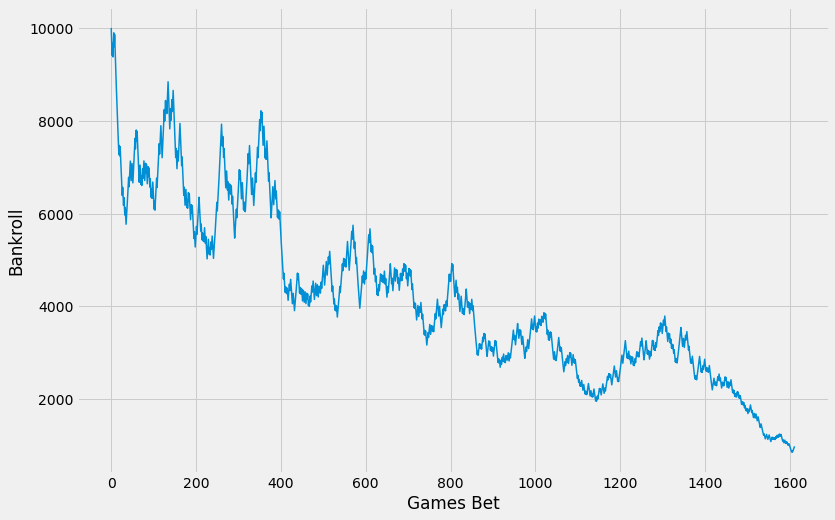

min balance: 862.5111525260419 
max balance: 9894.013025401953 
final balance: 957.1174741255818 
win percentage 50.56


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.66
num_games_bet: 207
win percetange at threshold: 0.5942028985507246


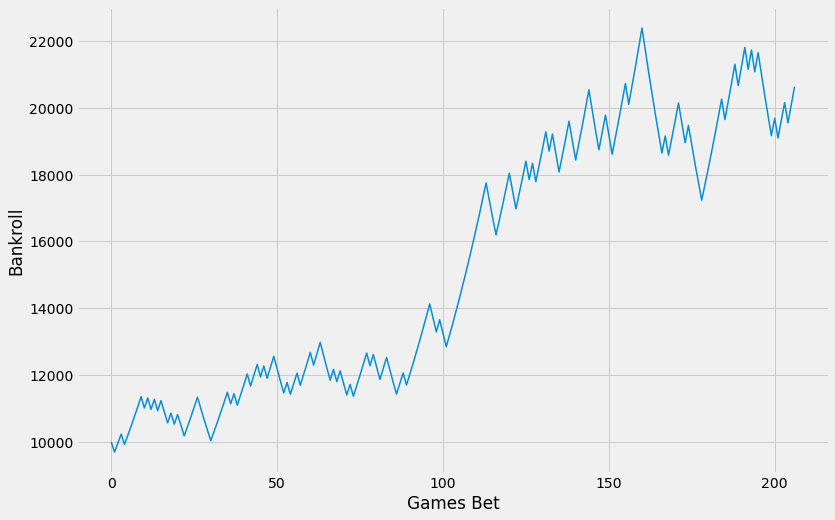

min balance: 9700.0 
max balance: 22385.451819066093 
final balance: 21192.097938195046 
win percentage 59.419999999999995


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


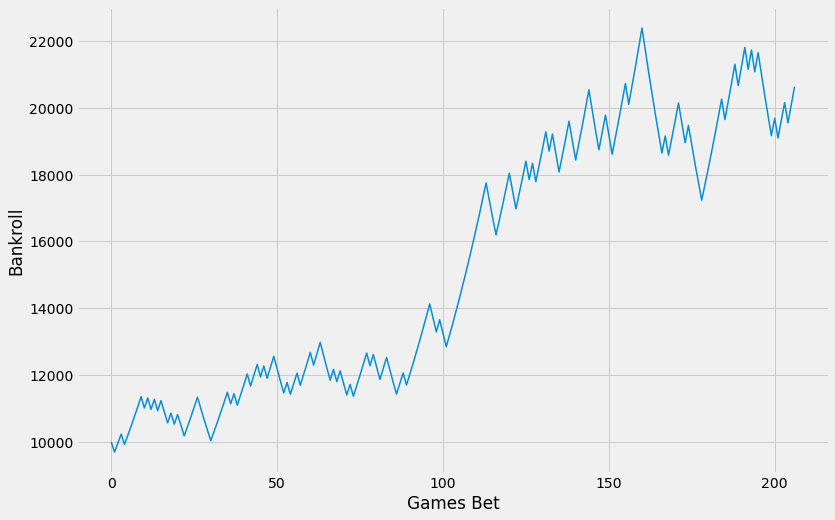

min balance: 9700.0 
max balance: 22385.451819066093 
final balance: 21192.097938195046 
win percentage 59.419999999999995


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0    11782  2016-11-06 00:00:00    -4.0             11.0         -4.382212   
1    11786  2016-11-07 00:00:00   -16.5             10.0         -3.367893   
2    11789  2016-11-08 00:00:00    -4.0            -12.0         -4.179664   
3    11790  2016-11-08 00:00:00    -6.5              8.0         -3.512741   
4    11827  2016-11-13 00:00:00   -16.5             13.0         -3.322987   
..     ...                  ...     ...              ...               ...   
202  16266  2020-03-03 00:00:00   -11.0             -5.0         -2.725492   
203  16268  2020-03-04 00:00:00    -8.0             21.0         -3.789251   
204  16359  2020-08-08 00:00:00    -4.5             -5.0         -3.720162   
205  16411  2020-08-20 00:00:00   -13.5             15.0          2.853190   
206  16436  2020-08-30 00:00:00    -2.0            -18.0         -2.779104   

     home_cover  bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0             1         0        0  10000.000000   9700.000000  300.000000  
1             0         0        1   9700.000000   9964.545455  291.000000  
2             0         0        1   9964.545455  10236.305785  298.936364  
3             1         0        0  10236.305785   9929.216612  307.089174  
4             0         0        1   9929.216612  10200.013428  297.876498  
..          ...       ...      ...           ...           ...         ...  
202           0         0        1  19618.201225  20153.243076  588.546037  
203           1         0        0  20153.243076  19548.645784  604.597292  
204           0         0        1  19548.645784  20081.790669  586.459374  
205           1         1        1  20081.790669  20629.475869  602.453720  
206           0         0        1  20629.475869  21192.097938  618.884276  

[207 rows x 11 columns]

In [189]:
svr_preds_hd = best_svr_hd.predict(X_test_hd)
svr_preds_hf = best_svr_hf.predict(X_test_hf)


select_bets_svr_hd, best_thresholds_svr_hd = find_optimal_confidence_thresholds(svr_preds_hd, test_indices_hd)

simulate_bets(select_bets_svr_hd)

select_bets_svr_hf, best_thresholds_svr_hf= find_optimal_confidence_thresholds(svr_preds_hf, test_indices_hf)
simulate_bets(select_bets_svr_hf)

svr_bets = create_betting_df(final_df_ewm_19, svr_preds_hd, svr_preds_hf, test_indices)

select_bets = svr_bets.loc[((svr_bets['spread'] <0) & (abs(svr_bets['confidence_preds']) >= 2.66))]

# # select_bets
# select_bets_svr_hd
simulate_bets(select_bets)

# # select_bets.shape[0]
# # svr_bets['b']

# # svr_bets['bet_won'].mean()
# # svr_bets['confidence_preds'].describe()
# select_bets

### XGB

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

In [220]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(8, 20),
              'reg_alpha': Integer(0, 20)}
    
    
xgb_bs_hd = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, 
                          verbose=1, n_jobs=-1, scoring=bet_accuracy)
xgb_bs_hf = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, 
                          verbose=1, n_jobs=-1, scoring=bet_accuracy)

xgb_bs_hd.fit(X_train_hd, y_train_hd)
xgb_bs_hf.fit(X_train_hf, y_train_hf)

print(xgb_bs_hd.best_estimator_)
print(xgb_bs_hf.best_estimator_)

best_xgb_hd = xgb_bs_hd.best_estimator_
best_xgb_hf = xgb_bs_hf.best_estimator_

xgb_preds_hd = best_xgb_hd.predict(X_test_hd)
xgb_preds_hf = best_xgb_hf.predict(X_test_hf)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5649680016477472,
             gamma=1.06248898882202, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=11, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=2, reg_lambda=14,
             scale_pos_weight=1, subsample=0.6993258418617195,
             tree_method='exact', validate_parameters=1, verbosity=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7074874699298258,
             gamma=2.1933900945262925, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=19, min_child_weight=7, missing=nan,
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0.5114406779661017
no best threshold


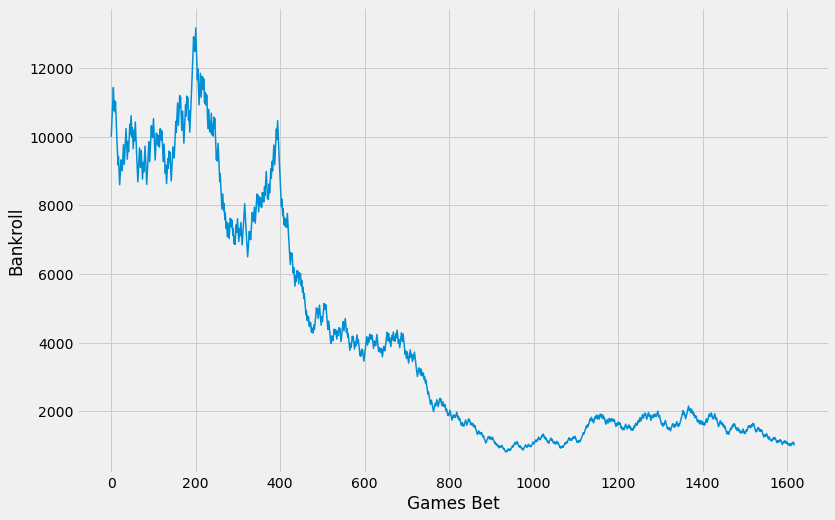

min balance: 805.264732941394 
max balance: 13176.604898895055 
final balance: 1030.2378594129668 
win percentage 50.64999999999999


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 7.48
num_games_bet: 458
win percetange at threshold: 0.5393013100436681


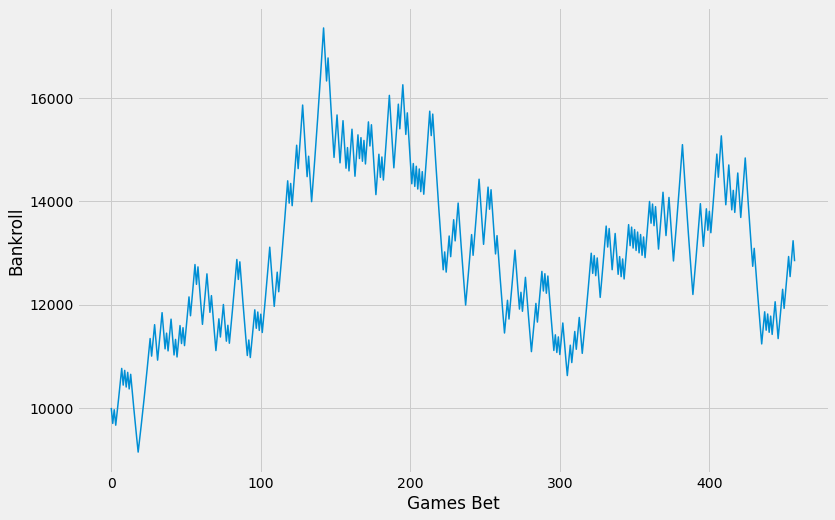

min balance: 9145.414823530999 
max balance: 17349.15434979576 
final balance: 12451.401476162671 
win percentage 53.93


GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
11774 2016-11-04    11.5               20         30.424097           1   
11775 2016-11-04    -2.5               -1         -3.692054           0   
11776 2016-11-04     3.5              -14         -0.653068           0   
11777 2016-11-05    -3.5               17          0.459552           1   
11778 2016-11-05    -3.0               15         -4.053969           1   
...          ...     ...              ...               ...         ...   
16489 2020-10-02   -11.0               10         -1.364440           0   
16490 2020-10-04     9.5               11         -2.266668           1   
16491 2020-10-06     7.5               -6         -3.668145           1   
16492 2020-10-09    -7.5               -3         -4.191771           0   
16493 2020-10-11     5.5              -13         -9.359966           0   

       bet_home  bet_won  bankroll_i  bankroll_n  bet_size  
11774         1        1     10000.0         NaN       NaN  
11775         0        1         NaN         NaN       NaN  
11776         0        1         NaN         NaN       NaN  
11777         1        1         NaN         NaN       NaN  
11778         0        0         NaN         NaN       NaN  
...         ...      ...         ...         ...       ...  
16489         0        1         NaN         NaN       NaN  
16490         0        0         NaN         NaN       NaN  
16491         0        0         NaN         NaN       NaN  
16492         0        1         NaN         NaN       NaN  
16493         0        1         NaN         NaN       NaN  

[4720 rows x 10 columns]

In [226]:
xgb_bets = create_betting_df(xgb_preds_hd, xgb_preds_hf, test_indices)
print(xgb_bets['bet_won'].mean())

select_bets_xgb_hd, best_thresholds_xgb_hd = find_optimal_confidence_thresholds(xgb_preds_hd, test_indices_hd)

simulate_bets(select_bets_xgb_hd)

select_bets_xgb_hf, best_thresholds_xgb_hf= find_optimal_confidence_thresholds(xgb_preds_hf, test_indices_hf)
simulate_bets(select_bets_xgb_hf)

# select_bets = xgb_bets.loc[((xgb_bets['spread'] >=0) & (abs(xgb_bets['confidence_preds']) >= 1.56))
#                           |((xgb_bets['spread'] <0) & (abs(xgb_bets['confidence_preds']) >= 0.69))]

# # select_bets
# select_bets_svr_hd
# simulate_bets(select_bets)

# # select_bets.shape[0]
# # svr_bets['b']

# # svr_bets['bet_won'].mean()
# # svr_bets['confidence_preds'].describe()
# select_bets
xgb_bets

In [224]:
xgb_bets['confidence_preds'].describe()

count    4720.000000
mean       -0.151033
std         5.328550
min       -20.681789
25%        -3.658302
50%        -0.109947
75%         3.353578
max        30.424097
Name: confidence_preds, dtype: float64

#### XGB EWM

In [62]:
tscv = TimeSeriesSplit()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9847739788199362,
             gamma=2.983944832543993, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=6, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=8,
             scale_pos_weight=1, subsample=0.8457999518907034,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold


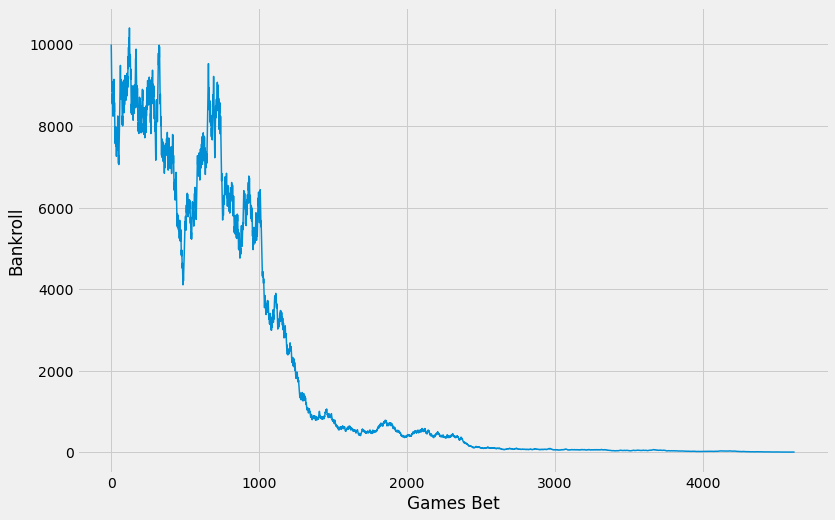

min balance: 5.76044843638713 
max balance: 10405.163351823114 
final balance: 7.250138370012476 
win percentage 50.370000000000005


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11774 2016-11-04    11.5               20         -2.987457         1.0   
1     11775 2016-11-04    -2.5               -1          2.961660         0.0   
2     11776 2016-11-04     3.5              -14          0.732119         0.0   
3     11777 2016-11-05    -3.5               17         -6.434264         1.0   
4     11778 2016-11-05    -3.0               15          4.751272         1.0   
...     ...        ...     ...              ...               ...         ...   
4615  16489 2020-10-02   -11.0               10         -0.119212         0.0   
4616  16490 2020-10-04     9.5               11         -0.190994         1.0   
4617  16491 2020-10-06     7.5               -6         -7.418568         1.0   
4618  16492 2020-10-09    -7.5               -3         -2.898040         0.0   
4619  16493 2020-10-11     5.5              -13         -4.846496         0.0   

      bet_home  bet_won    bankroll_i   bankroll_n    bet_size  
0            0        0  10000.000000  9700.000000  300.000000  
1            1        0   9700.000000  9409.000000  291.000000  
2            1        0   9409.000000  9126.730000  282.270000  
3            0        0   9126.730000  8852.928100  273.801900  
4            1        1   8852.928100  9094.371594  265.587843  
...        ...      ...           ...          ...         ...  
4615         0        1      7.107969     7.301823    0.213239  
4616         0        0      7.301823     7.082768    0.219055  
4617         0        0      7.082768     6.870285    0.212483  
4618         0        1      6.870285     7.057657    0.206109  
4619         0        1      7.057657     7.250138    0.211730  

[4620 rows x 11 columns]

In [148]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 5),
              'reg_lambda': Integer(8, 20),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, scoring = bet_accuracy, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test_ewm_19)


select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 4.43
num_games_bet: 326
win percetange at threshold: 0.5460122699386503


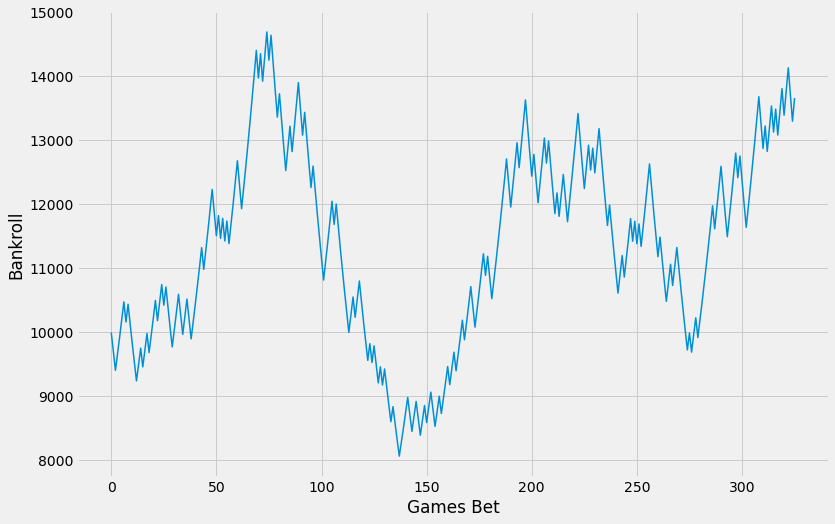

min balance: 8068.545539625003 
max balance: 14694.453618725862 
final balance: 13252.006898543277 
win percentage 54.6


GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   2016-11-06    -4.0               11         -5.389880         1.0   
1   2016-11-06    -3.0               11         -5.452116         1.0   
2   2016-11-08    -4.0              -12         -5.630734         0.0   
3   2016-11-09     4.5                7          4.669979         1.0   
4   2016-11-14   -11.0                4         -4.900041         0.0   
..         ...     ...              ...               ...         ...   
321 2020-09-06    -6.0                8          4.949677         1.0   
322 2020-09-08     4.5              -10          6.002094         0.0   
323 2020-09-10     5.5              -10          6.100047         0.0   
324 2020-09-12    -6.5               23          7.073978         1.0   
325 2020-10-04     9.5               11         -4.488081         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9700.000000  300.000000  
1           0        0   9700.000000   9409.000000  291.000000  
2           0        1   9409.000000   9665.609091  282.270000  
3           1        1   9665.609091   9929.216612  289.968273  
4           0        1   9929.216612  10200.013428  297.876498  
..        ...      ...           ...           ...         ...  
321         1        1  13759.255454  14134.507876  412.777664  
322         1        0  14134.507876  13710.472640  424.035236  
323         1        0  13710.472640  13299.158460  411.314179  
324         1        1  13299.158460  13661.862782  398.974754  
325         0        0  13661.862782  13252.006899  409.855883  

[326 rows x 10 columns]

In [227]:
xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, 
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)


xgb_preds = xgbr.predict(X_test_ewm_19)


select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.4
num_games_bet: 1360
win percetange at threshold: 0.5323529411764706


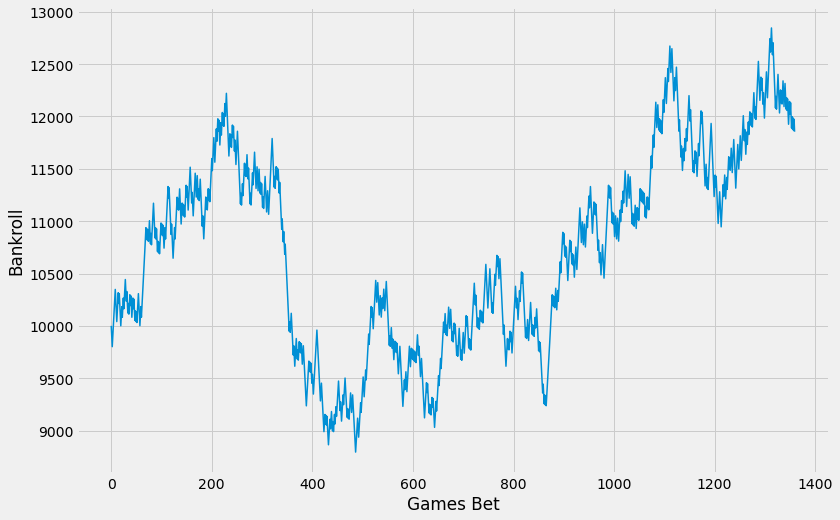

min balance: 8793.954881752543 
max balance: 12845.772440241844 
final balance: 11735.898668844451 
win percentage 53.239999999999995


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11774 2016-11-04    11.5               20         -4.696824         1.0   
1     11781 2016-11-06    -4.0               11         -2.468104         1.0   
2     11782 2016-11-06    -7.5               -5         -3.065332         0.0   
3     11789 2016-11-08     4.0                9          4.069438         1.0   
4     11791 2016-11-08    -8.5                3         -3.502422         0.0   
...     ...        ...     ...              ...               ...         ...   
1355  16474 2020-09-12    -6.5               23          3.603366         1.0   
1356  16476 2020-09-15    -7.5              -15          2.963645         0.0   
1357  16477 2020-09-15    -2.0               -3         -5.181109         0.0   
1358  16480 2020-09-19     3.5              -11          2.684426         0.0   
1359  16485 2020-09-25    -3.5               13         -5.120707         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            0        0  10000.000000   9900.000000  100.000000  
1            0        0   9900.000000   9801.000000   99.000000  
2            0        1   9801.000000   9890.100000   98.010000  
3            1        1   9890.100000   9980.010000   98.901000  
4            0        1   9980.010000  10070.737364   99.800100  
...        ...      ...           ...           ...         ...  
1355         1        1  11878.187597  11986.171120  118.781876  
1356         1        0  11986.171120  11866.309409  119.861711  
1357         0        1  11866.309409  11974.184949  118.663094  
1358         1        0  11974.184949  11854.443100  119.741849  
1359         0        0  11854.443100  11735.898669  118.544431  

[1360 rows x 11 columns]

In [168]:
xgbr.fit(features_ewm_19, spread_point_diff_ewm_19)

filename = '../models/xgb_ewm_19.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgbr, file)

### Random Forest

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

In [215]:
search_spaces = {'max_depth': Integer(3, 30, prior='log-uniform'),
                'max_features': Real(0.1, 1),
                 'min_samples_split': Real(0.1, 1),
                 'min_samples_leaf': Real(0.1, 0.5)}

rf_bs_hd = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=1)
rf_bs_hf = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)

rf_bs_hd.fit(X_train_hd, y_train_hd)
rf_bs_hf.fit(X_train_hf, y_train_hf)

best_rf_hd = rf_bs_hd.best_estimator_
best_rf_hf = rf_bs_hf.best_estimator_
        
rf_preds_hd = best_rf_hd.predict(X_test_hd)
rf_preds_hf = best_rf_hf.predict(X_test_hf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0.5114406779661017
best thresholds: 0.99
num_games_bet: 93
win percetange at threshold: 0.5698924731182796


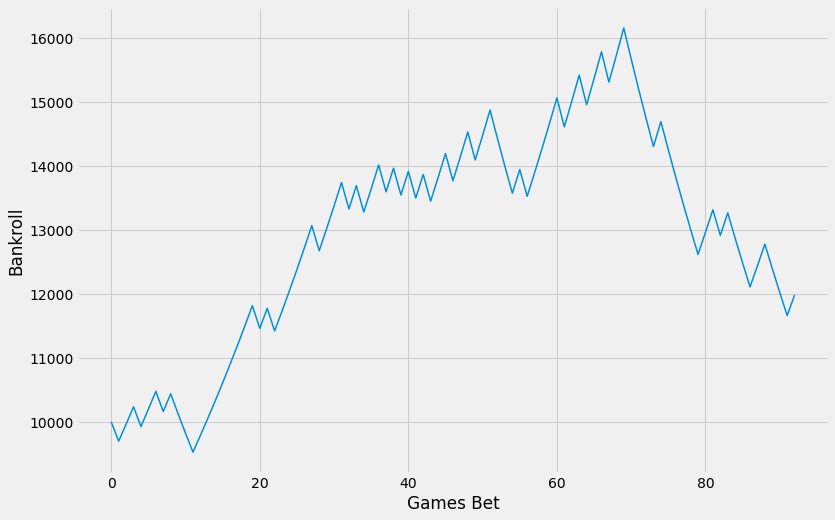

min balance: 9529.260453230609 
max balance: 16157.744894664376 
final balance: 12308.767315737905 
win percentage 56.989999999999995


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.56
num_games_bet: 1
win percetange at threshold: 1.0


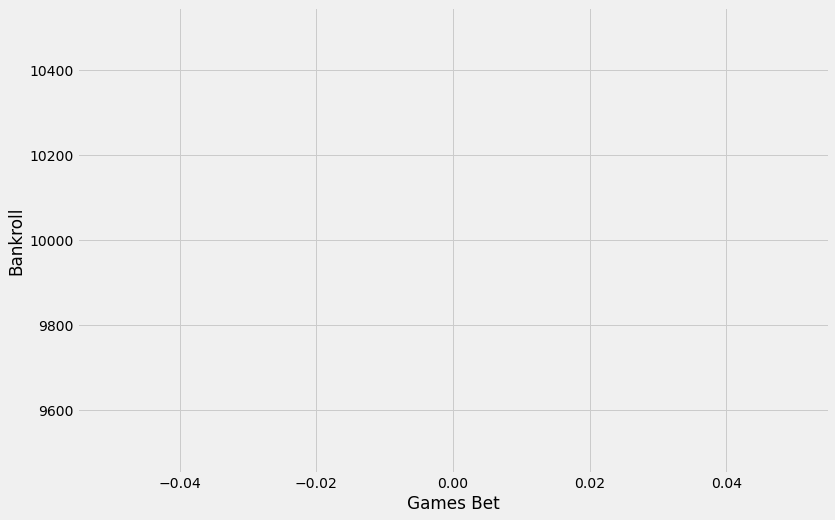

min balance: 10272.727272727272 
max balance: 10272.727272727272 
final balance: 10272.727272727272 
win percentage 100.0


GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  bet_home  \
0 2019-01-16    -1.0              -20         -1.610092         0.0         0   

   bet_won  bankroll_i    bankroll_n  bet_size  
0        1     10000.0  10272.727273     300.0

In [228]:
rf_bets = create_betting_df(rf_preds_hd, rf_preds_hf, test_indices)
print(xgb_bets['bet_won'].mean())

select_bets_rf_hd, best_thresholds_rf_hd = find_optimal_confidence_thresholds(rf_preds_hd, test_indices_hd)

simulate_bets(select_bets_rf_hd)

select_bets_rf_hf, best_thresholds_rf_hf= find_optimal_confidence_thresholds(rf_preds_hf, test_indices_hf)
simulate_bets(select_bets_rf_hf)

# select_bets = xgb_bets.loc[((xgb_bets['spread'] >=0) & (abs(xgb_bets['confidence_preds']) >= 1.56))
#                           |((xgb_bets['spread'] <0) & (abs(xgb_bets['confidence_preds']) >= 0.69))]

# # select_bets
# select_bets_svr_hd
# simulate_bets(select_bets)

# # select_bets.shape[0]
# # svr_bets['b']

# # svr_bets['bet_won'].mean()
# # svr_bets['confidence_preds'].describe()
# select_bets

In [638]:
abs(rf_preds).mean()
abs(spread_point_diff_train).mean()

9.167020553762528

#### RF EWM

In [153]:
search_spaces = {'max_depth': Integer(3, 30, prior='log-uniform'),
                'max_features': Real(0.1, 1),
                 'min_samples_split': Real(0.1, 1),
                 'min_samples_leaf': Real(0.1, 0.5)}

rf_bs = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, scoring=bet_accuracy, cv=tscv, verbose=3)
rf_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
                 
best_rf = rf_bs.best_estimator_
print(best_rf)
rf_preds = best_rf.predict(X_test_ewm_19)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


RandomForestRegressor(max_depth=25, max_features=0.9590649718640116,
                      min_samples_leaf=0.214778242199718,
                      min_samples_split=0.23621920056350376)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.93
num_games_bet: 628
win percetange at threshold: 0.5334394904458599


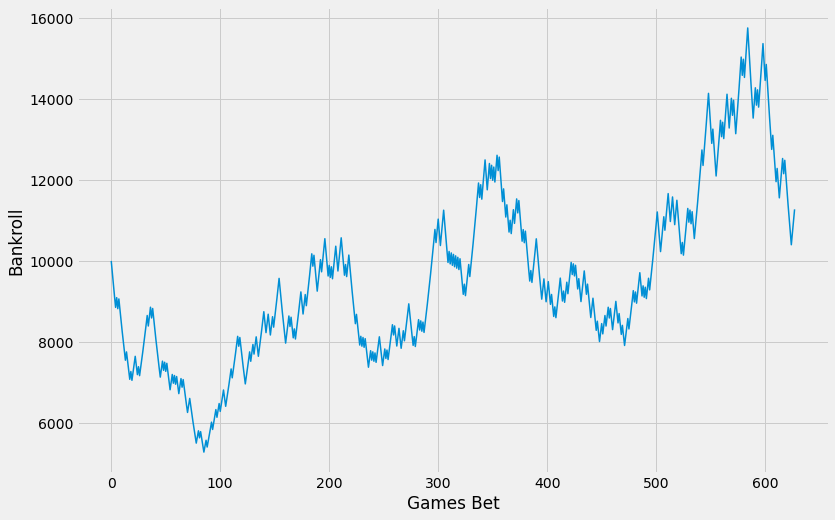

min balance: 5280.490074501376 
max balance: 15752.607869762927 
final balance: 10935.714888280007 
win percentage 53.339999999999996


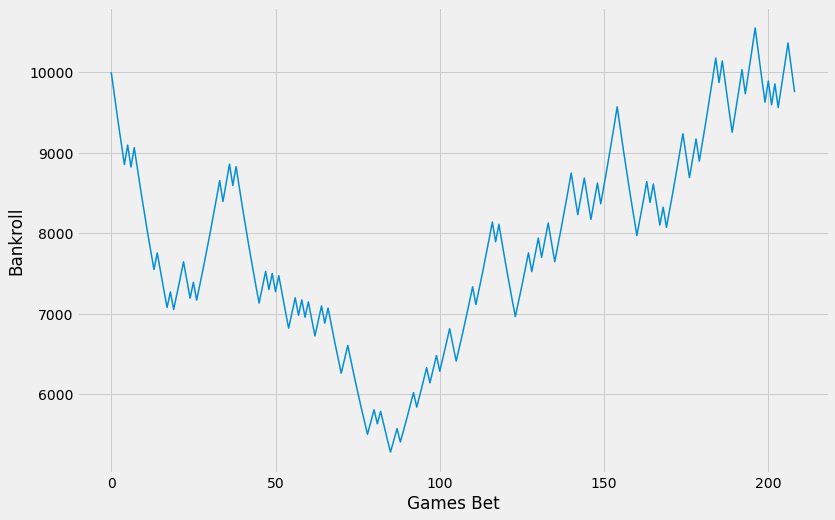

min balance: 5280.490074501376 
max balance: 10549.513746467188 
final balance: 10017.264291759922 
win percentage 53.11


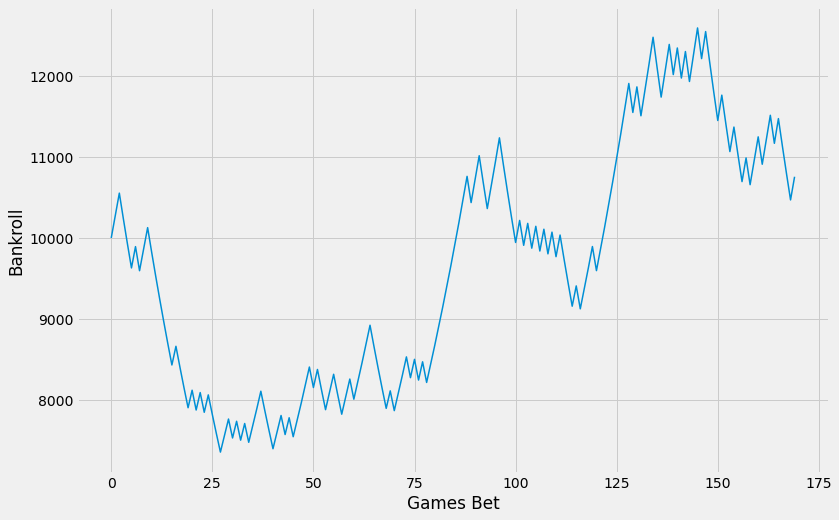

min balance: 7363.13972280673 
max balance: 12587.440114379733 
final balance: 10432.082540719162 
win percentage 53.53


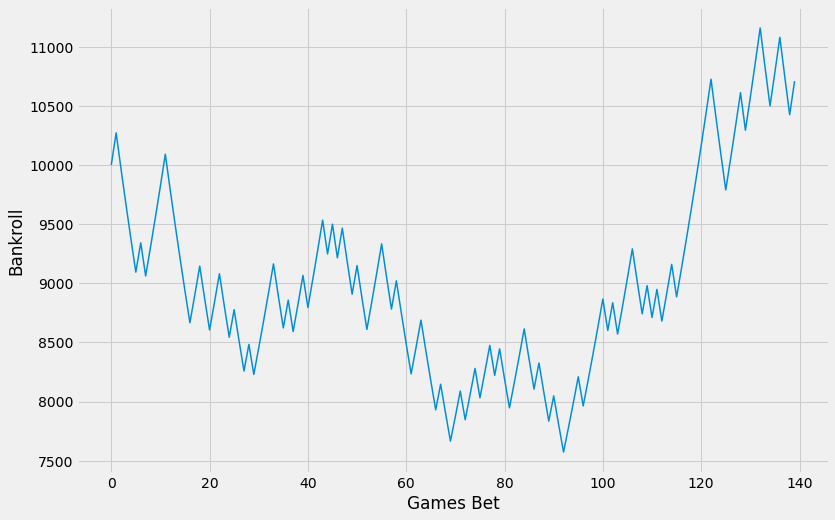

min balance: 7572.104712834004 
max balance: 11160.371602859625 
final balance: 11002.936985990342 
win percentage 54.290000000000006


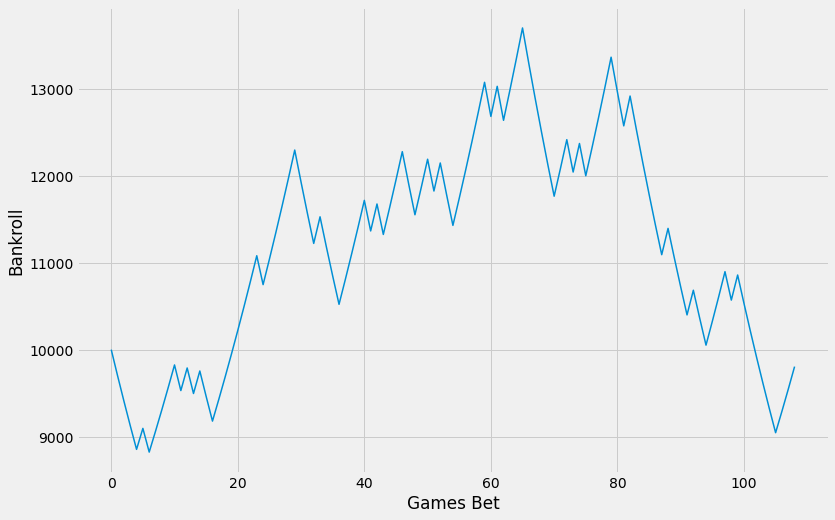

min balance: 8821.540445827271 
max balance: 13700.098501151506 
final balance: 9510.829723472314 
win percentage 52.290000000000006


In [154]:
rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

rf_preds = rf.predict(X_test_ewm_19)

select_bets_rf, best_thresholds_rf = find_optimal_confidence_thresholds(rf_preds, test_indices)
simulate_bets(select_bets_rf)

for season_idx in [test_indices_16, test_indices_17, test_indices_18, test_indices_19]:
    simulate_bets(select_bets_rf.loc[select_bets_rf.index.isin(season_idx)])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.34
num_games_bet: 1410
win percetange at threshold: 0.5375886524822695


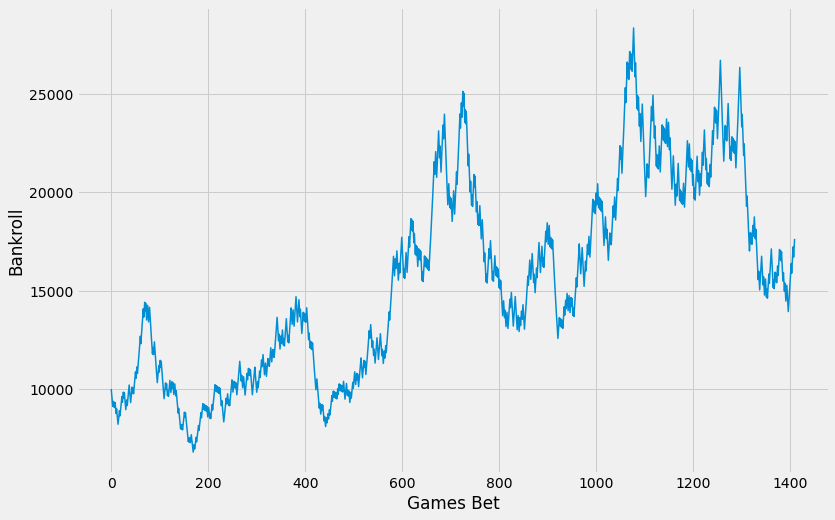

min balance: 6796.527647332414 
max balance: 28342.098270207396 
final balance: 17099.190552322292 
win percentage 53.76


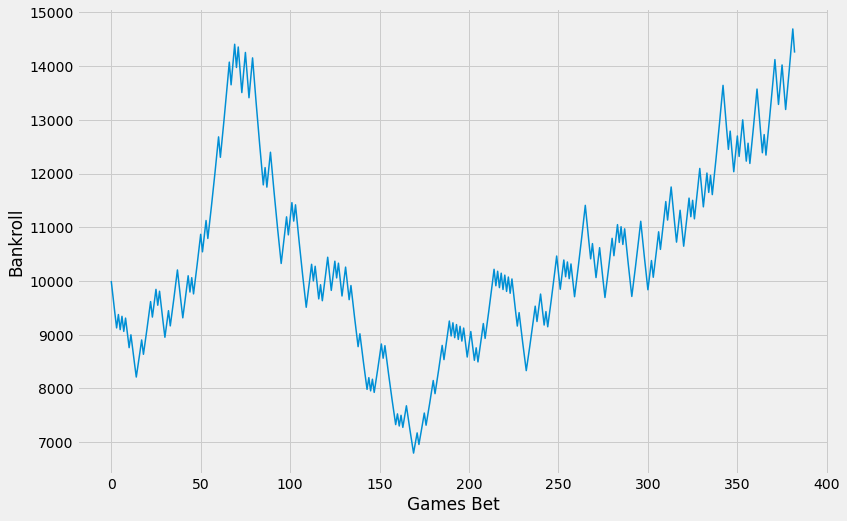

min balance: 6796.527647332414 
max balance: 14691.352654343178 
final balance: 13823.093712471496 
win percentage 54.56999999999999


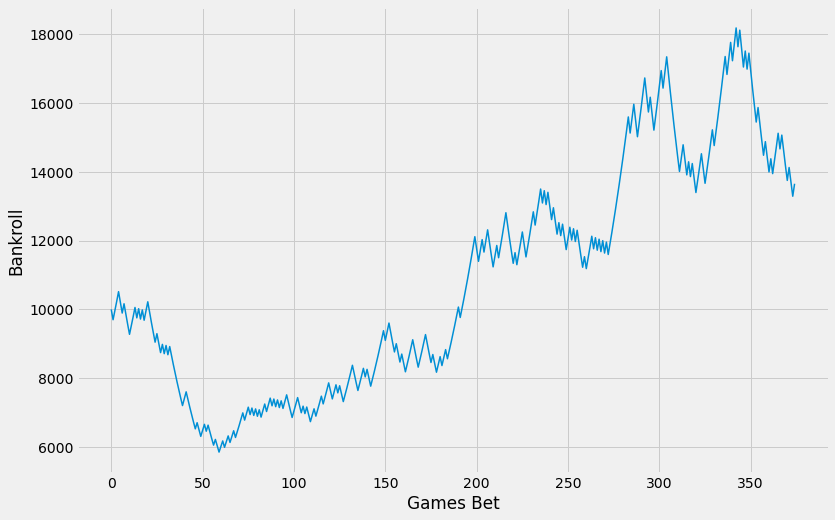

min balance: 5856.536455481147 
max balance: 18172.962832874873 
final balance: 13239.18521249511 
win percentage 54.400000000000006


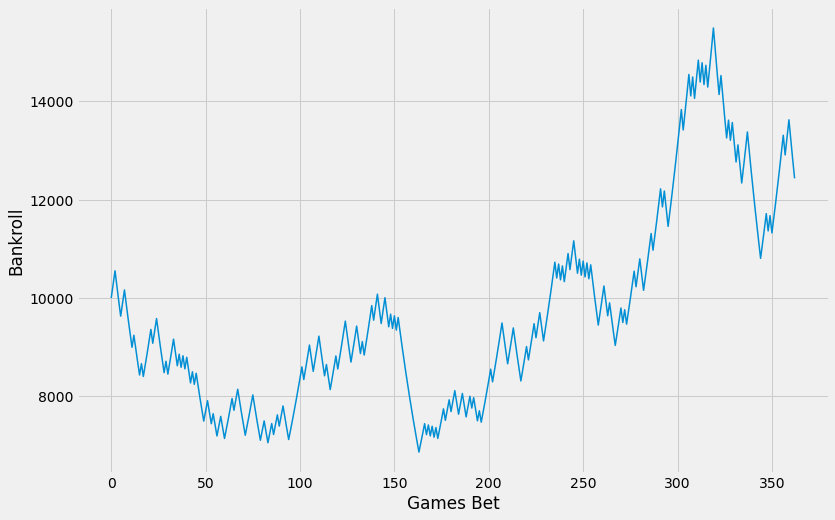

min balance: 6869.333636293959 
max balance: 15486.935491482858 
final balance: 12770.334651340836 
win percentage 54.269999999999996


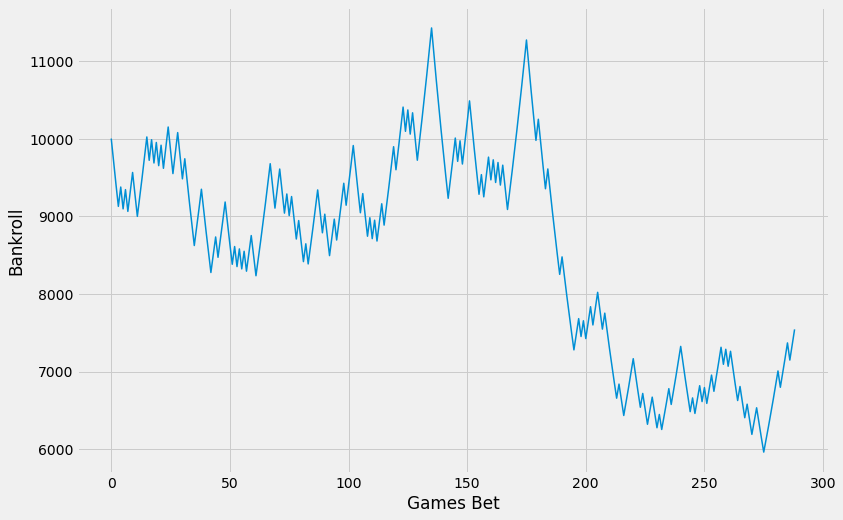

min balance: 5962.772217708529 
max balance: 11424.09764024853 
final balance: 7316.5570561083505 
win percentage 51.21


In [155]:
rf = RandomForestRegressor(max_depth=25, max_features=0.9590649718640116,
                      min_samples_leaf=0.214778242199718,
                      min_samples_split=0.23621920056350376)

rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

rf_preds = rf.predict(X_test_ewm_19)

select_bets_rf, best_thresholds_rf = find_optimal_confidence_thresholds(rf_preds, test_indices)
simulate_bets(select_bets_rf)

for season_idx in [test_indices_16, test_indices_17, test_indices_18, test_indices_19]:
    simulate_bets(select_bets_rf.loc[select_bets_rf.index.isin(season_idx)])

In [156]:
rf = RandomForestRegressor(max_depth=25, max_features=0.9590649718640116,
                      min_samples_leaf=0.214778242199718,
                      min_samples_split=0.23621920056350376)

rf.fit(features_ewm_19, spread_point_diff_ewm_19)

with open("../models/rf_ewm_19.pkl", 'wb') as file:
    pickle.dump(rf, file)
    

### Stacked Regressor for Spread + Actual Point Diff

In [531]:
lasso_pipe = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])

lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1,
                    random_state=0, reg_alpha=10, reg_lambda=10)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.000307628104,
                loss='squared_epsilon_insensitive',
                max_iter=10000))])


rf = RandomForestRegressor(max_depth=8, max_features=1.0, min_samples_leaf=0.1,
                      min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(feature_fraction=0.01, max_depth=3, min_child_weight=8,
              num_leaf=2048, objective='regression', reg_alpha=10,
              reg_lambda=10, subsample=0.6, subsample_freq=1)

estimators = [('lasso', lasso_pipe), ('lr', lr_pipe),
              ('sgd', sgd_pipe), ('xgbr', xgbr),
              ('svr', linear_svr), ('rf', rf),
              ('lgbr', lgbr)]

stacked_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stacked_reg.fit(X_train_spread, spread_point_diff_train)

stacked_preds = stacked_reg.predict(X_test_spread)




[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be igno

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.1
num_games_bet: 265
win percetange at threshold: 0.569811320754717


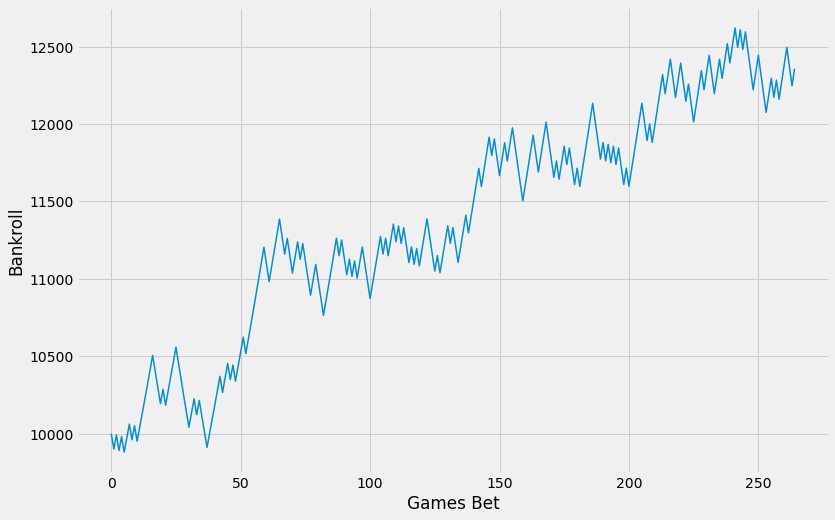

min balance: 9880.2099 
max balance: 12621.200422175167 
final balance: 12470.576245910346 
win percentage 56.98


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11781 2016-11-06    -4.0               11         -2.101167         1.0   
1    11785 2016-11-07   -16.5               10         -2.280885         0.0   
2    11788 2016-11-07    -5.5               12         -2.423314         1.0   
3    11792 2016-11-08    -4.0              -12         -2.984580         0.0   
4    11797 2016-11-09   -18.5               21         -2.543383         1.0   
..     ...        ...     ...              ...               ...         ...   
260  16424 2020-08-20     4.0               -9         -2.158518         0.0   
261  16427 2020-08-21    11.0              -25          2.961695         0.0   
262  16437 2020-08-23    14.0              -28          3.185883         0.0   
263  16465 2020-09-07     9.0               -6          2.345374         1.0   
264  16483 2020-09-23     3.5                3          2.117217         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        0   9990.000000   9890.100000   99.900000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        0   9980.010000   9880.209900   99.800100  
..        ...      ...           ...           ...         ...  
260         0        1  12382.982294  12495.554860  123.829823  
261         1        0  12495.554860  12370.599311  124.955549  
262         1        0  12370.599311  12246.893318  123.705993  
263         1        1  12246.893318  12358.228712  122.468933  
264         1        1  12358.228712  12470.576246  123.582287  

[265 rows x 11 columns]

In [532]:
select_bets_stacked, best_thresholds_stacked = find_optimal_confidence_thresholds(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

In [544]:
betting_df = final_df_spread[['GAME_DATE', 'HOME_GAME', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
betting_df['confidence_preds'] = stacked_preds
betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
betting_df['bet_home'] = (betting_df['confidence_preds'] > 0).astype(int)

betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

betting_df.loc[((betting_df['bet_home'] == 0) & (betting_df['spread'] > 0)), 'bet_won']

11810    1
11816    0
11875    0
11888    1
11891    0
        ..
16424    1
16431    0
16441    0
16451    0
16482    0
Name: bet_won, Length: 434, dtype: int32

#### Stacked EWM 

In [700]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])

ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823,
                              epsilon=0.19144819761699575, l1_ratio=0.25,
                              loss='huber', penalty='elasticnet'))])

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                    ('svr',
                     LinearSVR(C=0.00018877550822240589,
                               loss='squared_epsilon_insensitive',
                               max_iter=10000))])


rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(feature_fraction=1.0, max_depth=3, min_child_weight=8,
              num_leaves=2, objective='regression', reg_alpha=10, reg_lambda=10,
              subsample=0.6, subsample_freq=1)

estimators = [('lasso', lasso_pipe), ('en', en_pipe),
              ('sgd', sgd_pipe), ('xgbr', xgbr),
              ('svr', linear_svr), ('rf', rf),
              ('lgbr', lgbr), ('ridge', ridge_pipe)]

stacked_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stacked_reg.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

stacked_preds = stacked_reg.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.5
num_games_bet: 16
win percetange at threshold: 0.625


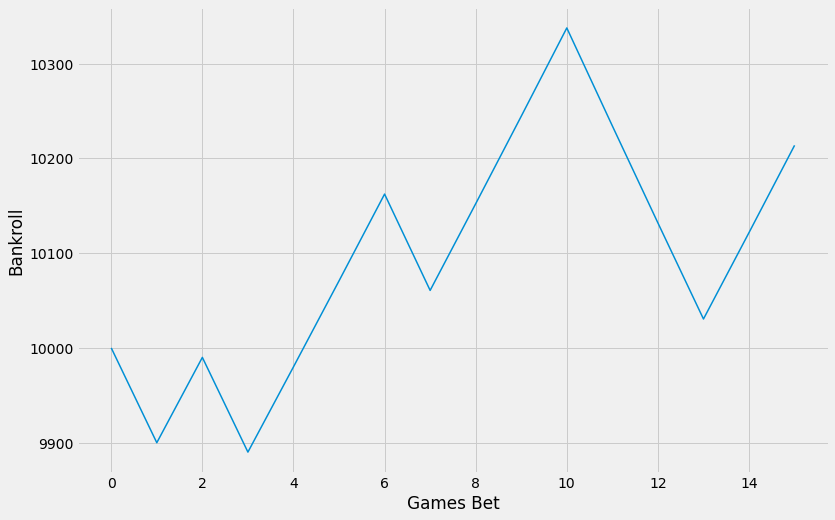

min balance: 9890.1 
max balance: 10337.550382235911 
final balance: 10306.568733402799 
win percentage 62.5


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11786 2016-11-07    -7.0               32         -4.136365         1.0   
1   11792 2016-11-08    -4.0              -12         -3.719210         0.0   
2   12248 2017-01-08    -9.5               12         -3.615359         1.0   
3   13014 2017-10-30    -4.0               14          3.835894         1.0   
4   13314 2017-12-12    -5.0               -6         -3.808488         0.0   
5   13859 2018-03-04     3.5              -17         -4.117492         0.0   
6   14227 2018-10-26    11.5              -28          4.051480         0.0   
7   14233 2018-10-28     9.5               -6          3.847959         1.0   
8   14610 2018-12-19     2.0                5          3.590901         1.0   
9   15412 2019-04-23    -4.5                3         -3.666035         0.0   
10  15467 2019-11-03     3.0               29         -4.634694         1.0   
11  15474 2019-11-04     0.0                5         -3.633738         1.0   
12  15502 2019-11-08     2.0                3         -4.098998         1.0   
13  16200 2020-02-23   -14.5               12         -3.620715         0.0   
14  16332 2020-08-01     6.0                6         12.095107         1.0   
15  16336 2020-08-01    -5.0               23         14.213478         1.0   

    bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0          0        0  10000.000000   9900.000000  100.000000  
1          0        1   9900.000000   9990.000000   99.000000  
2          0        0   9990.000000   9890.100000   99.900000  
3          1        1   9890.100000   9980.010000   98.901000  
4          0        1   9980.010000  10070.737364   99.800100  
5          0        1  10070.737364  10162.289521  100.707374  
6          1        0  10162.289521  10060.666626  101.622895  
7          1        1  10060.666626  10152.127232  100.606666  
8          1        1  10152.127232  10244.419298  101.521272  
9          0        1  10244.419298  10337.550382  102.444193  
10         0        0  10337.550382  10234.174878  103.375504  
11         0        0  10234.174878  10131.833130  102.341749  
12         0        0  10131.833130  10030.514798  101.318331  
13         0        1  10030.514798  10121.701296  100.305148  
14         1        1  10121.701296  10213.716763  101.217013  
15         1        1  10213.716763  10306.568733  102.137168

In [701]:
select_bets_stacked, best_thresholds_stacked = find_optimal_confidence_thresholds(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

#### All Models Voting EWM

In [675]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])


ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1,
                    random_state=0, reg_alpha=10, reg_lambda=10)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.000307628104,
                loss='squared_epsilon_insensitive',
                max_iter=10000))])




rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)

lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
en_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
ridge_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
sgd_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
xgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
linear_svr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

lasso_preds = lasso_pipe.predict(X_test_ewm_19)
en_preds = en_pipe.predict(X_test_ewm_19)
ridge_preds = ridge_pipe.predict(X_test_ewm_19)
sgd_preds = sgd_pipe.predict(X_test_ewm_19)
xgbr_preds = xgbr.predict(X_test_ewm_19)
svr_preds = linear_svr.predict(X_test_ewm_19)
rf_preds = rf.predict(X_test_ewm_19)
lgbr_preds = lgbr.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.8678435885410023 will be ignored. Current value: feature_fraction=0.01


In [698]:
betting_df = final_df_spread[['GAME_DATE', 'HOME_GAME', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
betting_df['lasso_preds'] = lasso_preds
betting_df['en_preds'] = en_preds
betting_df['ridge_preds'] = ridge_preds
betting_df['sgd_preds'] = sgd_preds
betting_df['xgbr_preds'] = xgbr_preds
betting_df['svr_preds'] = svr_preds
betting_df['rf_preds'] = rf_preds
betting_df['lgbr_preds'] = lgbr_preds


betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)

betting_df['bet_home_lasso'] = np.select([betting_df['lasso_preds']>1.6, betting_df['lasso_preds'] <-1.6], [1, -1], 0)
betting_df['bet_home_en'] = np.select([betting_df['en_preds']>1.5, betting_df['en_preds'] <-1.5], [1, -1], 0)
betting_df['bet_home_ridge'] = np.select([betting_df['ridge_preds']>2.5, betting_df['ridge_preds'] <-2.5], [1, -1], 0)
betting_df['bet_home_sgd'] = np.select([betting_df['sgd_preds']>1.3, betting_df['sgd_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_xgbr'] = np.select([betting_df['xgbr_preds']>2.4, betting_df['xgbr_preds'] <-2.4], [1, -1], 0)
betting_df['bet_home_svr'] = np.select([betting_df['svr_preds']>1.9, betting_df['svr_preds'] <-1.9], [1, -1], 0)
betting_df['bet_home_rf'] = np.select([betting_df['rf_preds']>1.3, betting_df['rf_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_lgbr'] = np.select([betting_df['lgbr_preds']>0.6, betting_df['lgbr_preds'] <-0.6], [1, -1], 0)

betting_df['bet_consensus'] = (betting_df.iloc[:, 15:22] > 0).sum(axis=1)
betting_df['bet_home'] = (betting_df['bet_consensus'] > 0).astype(int)

betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)


select_bets = betting_df.loc[((abs(betting_df['lasso_preds']) > 1.6) 
                            | (abs(betting_df['en_preds']) > 1.5)
                             |(abs(betting_df['ridge_preds']) > 2.5)
                            | (abs(betting_df['sgd_preds']) > 1.3) 
                            | (abs(betting_df['xgbr_preds']) > 2.4) 
                             | (abs(betting_df['svr_preds']) > 1.9) 
                             | (abs(betting_df['rf_preds']) > 1.3) 
                             | (abs(betting_df['lgbr_preds']) > 0.6))]

select_bets = select_bets.loc[select_bets['bet_consensus'] != 0]

# hf = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].mean()
# hd = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# af = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# ad = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].mean()

# hf_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]
# hd_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# af_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# ad_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]

# print("HF:", hf, "HD:", hd, 'AF:', af, 'AD:', ad)
# print("HF_games:", hf_games, 'HD_games:', hd_games, 'AF_games:', af_games, 'AD_games:', ad_games)

# print("overall win_pct:", select_bets['bet_won'].mean())

select_bets


GAME_DATE  HOME_GAME  spread  point_diff_team  lasso_preds  en_preds  \
11777 2016-11-05          1    -4.5              -24     0.213260  0.231837   
11779 2016-11-05          1    -3.0               15     0.195331  0.162509   
11789 2016-11-08          1     4.0                9    -0.607457 -0.495325   
11790 2016-11-08          1    -4.0                1     0.084697  0.160411   
11795 2016-11-09          1   -11.5                7     0.323475  0.327824   
...          ...        ...     ...              ...          ...       ...   
16481 2020-09-20          1    -7.5                2     0.714325  0.763663   
16483 2020-09-23          1     3.5                3     1.897914  1.962849   
16486 2020-09-26          1    -5.5               10     1.075247  1.129537   
16487 2020-09-27          1     3.0               12     1.199596  1.228001   
16489 2020-10-02          1   -11.0               10     0.247355  0.277335   

       ridge_preds  sgd_preds  xgbr_preds  svr_preds  rf_preds  lgbr_preds  \
11777     0.834546   1.326378   -1.478675   0.830264 -0.271166    0.168603   
11779     0.667753  -0.329578    2.498864   0.268550 -1.286166   -0.470707   
11789     0.339221  -0.028548    2.597501  -0.017647  0.478733   -0.228526   
11790     0.538093   1.366422    0.565771   0.814663 -0.098503    0.284730   
11795    -0.290948   0.640929    2.914597  -0.017273  0.150087   -0.287823   
...            ...        ...         ...        ...       ...         ...   
16481     0.754744   1.475856    0.197554   1.094332  0.239277    0.049296   
16483     3.287159   2.543345    1.510496   2.880407  0.543966   -0.230455   
16486     1.408192   1.906490   -1.029127   1.561461  0.313621   -0.164972   
16487     2.517299   1.562851    0.782514   2.012982  0.308588   -0.456948   
16489     0.104642   0.923484    3.117330   0.498303 -0.043740    0.120913   

       home_cover  bet_home_lasso  bet_home_en  bet_home_ridge  bet_home_sgd  \
11777         0.0               0            0               0             1   
11779         1.0               0            0               0             0   
11789         1.0               0            0               0             0   
11790         0.0               0            0               0             1   
11795         0.0               0            0               0             0   
...           ...             ...          ...             ...           ...   
16481         0.0               0            0               0             1   
16483         1.0               1            1               1             1   
16486         1.0               0            0               0             1   
16487         1.0               0            0               1             1   
16489         0.0               0            0               0             0   

       bet_home_xgbr  bet_home_svr  bet_home_rf  bet_home_lgbr  bet_consensus  \
11777              0             0            0              0              1   
11779              1             0            0              0              1   
11789              1             0            0              0              1   
11790              0             0            0              0              1   
11795              1             0            0              0              1   
...              ...           ...          ...            ...            ...   
16481              0             0            0              0              1   
16483              0             1            0              0              3   
16486              0             0            0              0              1   
16487              0             1            0              0              3   
16489              1             0            0              0              1   

       bet_home  bet_won  
11777         1        0  
11779         1        1  
11789         1        1  
11790         1        0  
11795         1        0  
...         ...      ... 

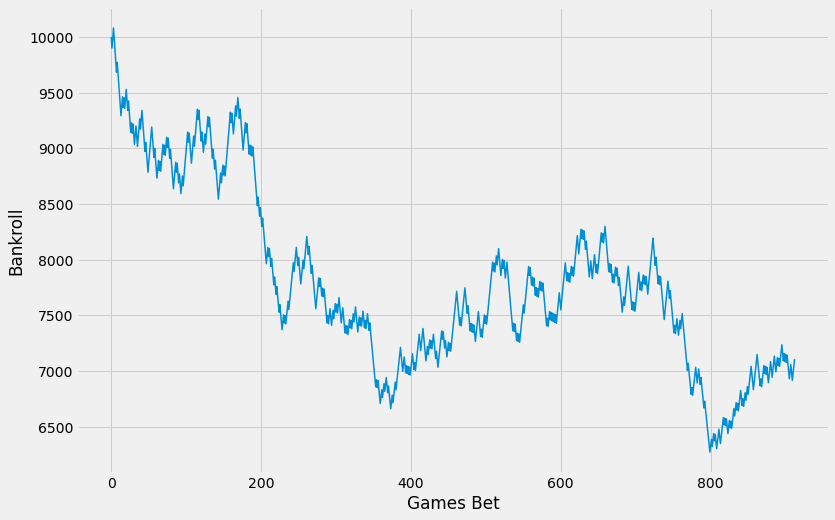

min balance: 6271.61946968746 
max balance: 10080.818181818182 
final balance: 7035.069947246549 
win percentage 50.6


index  GAME_DATE  HOME_GAME  spread  point_diff_team  lasso_preds  \
0    11777 2016-11-05          1    -4.5              -24     0.213260   
1    11779 2016-11-05          1    -3.0               15     0.195331   
2    11789 2016-11-08          1     4.0                9    -0.607457   
3    11790 2016-11-08          1    -4.0                1     0.084697   
4    11795 2016-11-09          1   -11.5                7     0.323475   
..     ...        ...        ...     ...              ...          ...   
908  16481 2020-09-20          1    -7.5                2     0.714325   
909  16483 2020-09-23          1     3.5                3     1.897914   
910  16486 2020-09-26          1    -5.5               10     1.075247   
911  16487 2020-09-27          1     3.0               12     1.199596   
912  16489 2020-10-02          1   -11.0               10     0.247355   

     en_preds  ridge_preds  sgd_preds  xgbr_preds  svr_preds  rf_preds  \
0    0.231837     0.834546   1.326378   -1.478675   0.830264 -0.271166   
1    0.162509     0.667753  -0.329578    2.498864   0.268550 -1.286166   
2   -0.495325     0.339221  -0.028548    2.597501  -0.017647  0.478733   
3    0.160411     0.538093   1.366422    0.565771   0.814663 -0.098503   
4    0.327824    -0.290948   0.640929    2.914597  -0.017273  0.150087   
..        ...          ...        ...         ...        ...       ...   
908  0.763663     0.754744   1.475856    0.197554   1.094332  0.239277   
909  1.962849     3.287159   2.543345    1.510496   2.880407  0.543966   
910  1.129537     1.408192   1.906490   -1.029127   1.561461  0.313621   
911  1.228001     2.517299   1.562851    0.782514   2.012982  0.308588   
912  0.277335     0.104642   0.923484    3.117330   0.498303 -0.043740   

     lgbr_preds  home_cover  bet_home_lasso  bet_home_en  bet_home_ridge  \
0      0.168603         0.0               0            0               0   
1     -0.470707         1.0               0            0               0   
2     -0.228526         1.0               0            0               0   
3      0.284730         0.0               0            0               0   
4     -0.287823         0.0               0            0               0   
..          ...         ...             ...          ...             ...   
908    0.049296         0.0               0            0               0   
909   -0.230455         1.0               1            1               1   
910   -0.164972         1.0               0            0               0   
911   -0.456948         1.0               0            0               1   
912    0.120913         0.0               0            0               0   

     bet_home_sgd  bet_home_xgbr  bet_home_svr  bet_home_rf  bet_home_lgbr  \
0               1              0             0            0              0   
1               0              1             0            0              0   
2               0              1             0            0              0   
3               1              0             0            0              0   
4               0              1             0            0              0   
..            ...            ...           ...          ...            ...   
908             1              0             0            0              0   
909             1              0             1            0              0   
910             1              0             0            0              0   
911             1              0             1            0              0   
912             0              1             0            0              0   

     bet_consensus  bet_home  bet_won    bankroll_i    bet_size    bankroll_n  
0                1         1        0  10000.000000  100.000000   9900.000000  
1                1         1        1   9900.000000   99.000000   9990.000000  
2                1         1        1   9990.000000   99.900000  10080.818182  
3                1         1        0  10080.818182  100.

In [699]:
simulate_bets(select_bets)

### Custom Loss Function LR

In [410]:
import autograd.numpy as np
from autograd import grad

In [438]:
X_train_ewm_19
# spread_point_diff_train_ewm_19

FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0           -0.575810        7.261337        1.148934        6.622988   
1           -4.323655      -10.223951        1.990916        4.518327   
2           -2.149081       -9.286709       -0.488364        1.207028   
3            3.092239       -3.338606        0.840770        1.863964   
4            1.954923        5.820057       -1.362323        1.428139   
...               ...             ...             ...             ...   
11769       -2.448634       -3.195063       -0.942144       -1.725156   
11770       -0.903728       -0.575488       -0.547921       -2.352658   
11771       -0.786681       -0.582086        1.593153        3.217412   
11772        2.308044        1.923904       -1.833843       -4.795702   
11773       -3.277257       -2.431520        2.150465        5.516144   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0          -0.816903      -4.248272        4.494689        1.648116   
1          -3.477449      -5.215013       -0.176992       -1.397329   
2          -0.154331      -2.195258       -5.292423       -1.873117   
3          -1.172882       0.353975        0.096077       -1.606446   
4          -2.701524      -9.112958       -0.676793        0.954472   
...              ...            ...             ...             ...   
11769       0.651848       0.892143       -0.250303       -1.537547   
11770       0.086648      -0.097096        0.674753       -0.283763   
11771       0.922036       0.587392       -0.807284        0.755402   
11772      -1.329841      -0.828656        0.226543       -0.379854   
11773       0.696841       0.445778       -0.103885       -0.758152   

       REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
0           6.142805       4.424190       0.493932       1.449000   
1          -1.574321       3.763937       2.460282      -0.158091   
2          -7.165539      -3.111133       1.586774       0.779029   
3          -1.510369       3.047261       1.152555      -0.571463   
4           0.277679       3.270133      -0.412463      -0.971038   
...              ...            ...            ...            ...   
11769      -1.787850      -3.530306      -0.638479      -1.398334   
11770       0.390990      -2.977262      -0.274623      -1.358500   
11771      -0.051882       3.479550       0.447166       1.222646   
11772      -0.153312      -3.431598       0.097563      -1.100376   
11773      -0.862037       2.588423      -0.787820       0.590329   

       TOV_team_diff  PF_team_diff  PTS_team_diff  PLUS_MINUS_team_diff  \
0          -3.451833     -1.093185       1.478279             -2.022368   
1          -1.194403     -4.265342      -6.152011             11.563063   
2          -0.666626      0.873971      -5.917584             -4.536641   
3           6.557348     -1.924089       7.533905              0.654376   
4          -3.102747     -2.496974      -2.878648             -0.930448   
...              ...           ...            ...                   ...   
11769      -1.065006     -2.117128      -7.071850             -3.194041   
11770      -1.358511     -1.705401      -3.364571              3.125519   
11771       1.022656      1.334851       4.128134             -0.612905   
11772      -1.020388     -1.101360      -2.215282              3.551672   
11773       1.118352      0.991219       0.593722             -5.996547   

       E_OFF_RATING_team_diff  OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
0                   -2.621902             -2.350827               -0.945064   
1                    3.340881              2.512285               -7.198786   
2                   -1.555112             -3.289102                3.172780   
3                    2.001702              1.307293                4.631014   
4                   -3.957861             -2.499636               -3.134364   
...                       ...                   ...                     .

In [1025]:
scaler = StandardScaler()
# X_train_ewm_19_scaled = scaler.fit_transform(X_train_ewm_19)
# spread_point_diff_train_ewm_19

scaled_features = scaler.fit_transform(features_ewm_19)


weights = np.random.random(features_ewm_19.shape[1])

weights.shape

eps = 1e-15

def wTx(w, x):
    return np.dot(x, w)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(y_true, y_pred):
    residual = (y_pred-y_true).astype(float)
    choicelist = [np.where(y_pred<0, residual**2, 10*residual**2), np.where(y_pred<=0, 10*residual**2, residual**2)]
    loss = np.where(y_true<=0, choicelist[0], choicelist[1])
    #    loss = torch.mean(-torch.log(torch.sigmoid((torch.sign(target) * (output - target)))))
    return loss

#     return np.mean(-np.log(sigmoid(np.sign(y_true) * (y_pred - y_true))))


def custom_loss_given_weights(w):
    y_predicted = wTx(w, scaled_features)
    return custom_loss(spread_point_diff_ewm_19.values, y_predicted)


gradient = grad(custom_loss_given_weights)


In [1026]:
custom_loss(np.array([2]), np.array([1]))

array([1.])

<AxesSubplot:title={'center':'y_pred vs loss for y=-2'}, xlabel='y_pred'>

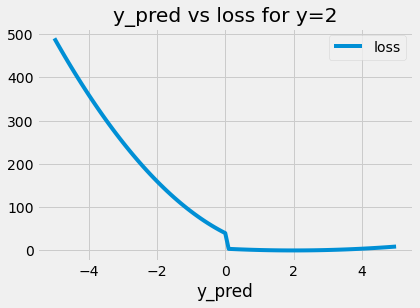

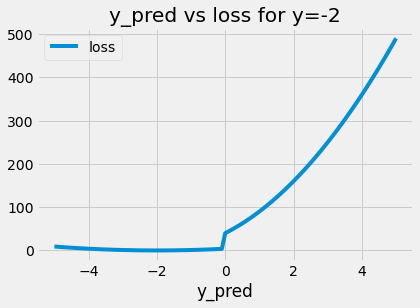

In [1029]:
df = pd.DataFrame(
[(y_pred, custom_loss(2, y_pred)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=2')


df = pd.DataFrame(
[(y_pred, custom_loss(-2, y_pred)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=-2')

In [715]:
for i in range(8000):
    if i%1000 == 0:
        print("iteration {}".format(i), "Loss: {}".format(custom_loss_given_weights(weights)))
    weights -= gradient(weights)*0.005

iteration 0 Loss: 10.906324947342886
iteration 1000 Loss: 9.505871626038724
iteration 2000 Loss: 9.38094503890166
iteration 3000 Loss: 9.357031429089956
iteration 4000 Loss: 9.344954190693745
iteration 5000 Loss: 9.336921786261058
iteration 6000 Loss: 9.331057131028587
iteration 7000 Loss: 9.3265852308836


In [716]:
X_test_ewm_19_scaled = scaler.transform(X_test_ewm_19)
test_preds_custom = wTx(weights, X_test_ewm_19_scaled)
test_preds_custom

array([-2.28919523e-01, -8.65964493e-01,  1.36274241e+00, ...,
       -1.35744142e-03,  3.50963761e+00, -6.83631823e-01])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.2
num_games_bet: 1294
win percetange at threshold: 0.5548686244204019


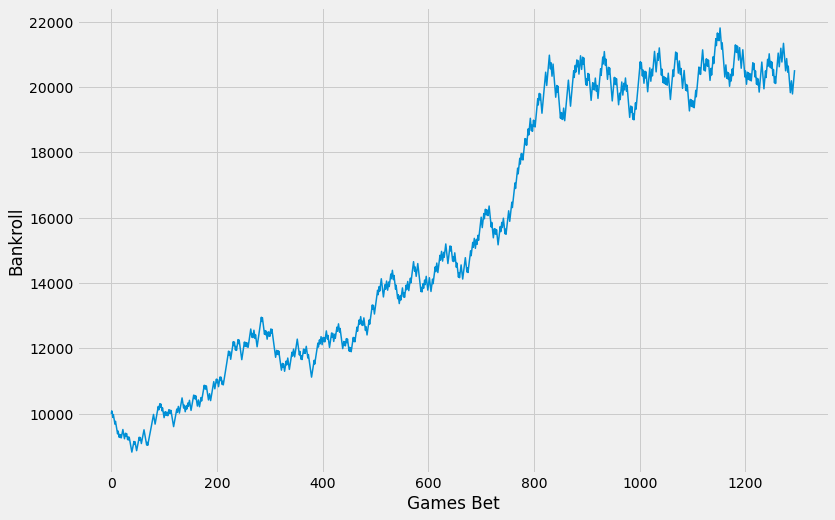

min balance: 8828.84669471551 
max balance: 21810.883064409983 
final balance: 20315.28472156701 
win percentage 55.489999999999995


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11777 2016-11-05    -3.5               17          3.157805         1.0   
1     11780 2016-11-05    -4.5              -24          4.544154         0.0   
2     11781 2016-11-06    -4.0               11         -2.989369         1.0   
3     11782 2016-11-06    -7.5               -5         -2.394538         0.0   
4     11786 2016-11-07    -5.5               12         -2.799149         1.0   
...     ...        ...     ...              ...               ...         ...   
1289  16483 2020-09-23     3.5                3          4.655065         1.0   
1290  16486 2020-09-26    -5.5               10          3.713941         1.0   
1291  16487 2020-09-27     3.0               12          3.500975         1.0   
1292  16488 2020-09-30    -4.5               18          3.110749         1.0   
1293  16492 2020-10-09    -7.5               -3          3.509638         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        1  10000.000000  10090.909091  100.000000  
1            1        0  10090.909091   9990.000000  100.909091  
2            0        0   9990.000000   9890.100000   99.900000  
3            0        1   9890.100000   9980.010000   98.901000  
4            0        0   9980.010000   9880.209900   99.800100  
...        ...      ...           ...           ...         ...  
1289         1        1  19790.945566  19970.863253  197.909456  
1290         1        1  19970.863253  20152.416555  199.708633  
1291         1        1  20152.416555  20335.620342  201.524166  
1292         1        1  20335.620342  20520.489618  203.356203  
1293         1        0  20520.489618  20315.284722  205.204896  

[1294 rows x 11 columns]

In [717]:
select_bets_custom, best_thresholds_custom = find_optimal_confidence_thresholds(test_preds_custom, X_test_ewm_19.index)
simulate_bets(select_bets_custom)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

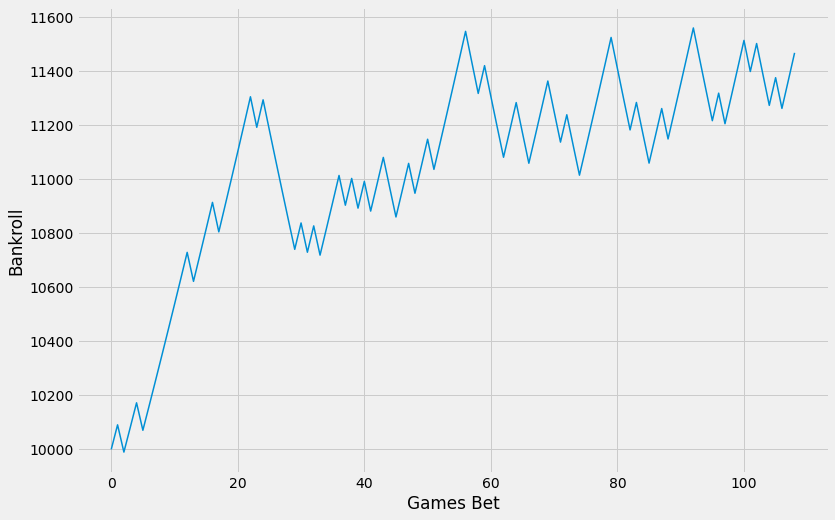

min balance: 9990.0 
max balance: 11572.245758571004 
final balance: 11572.245758571004 
win percentage 59.63


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        0               MIL               30  MIL vs. CHI             -14.5   
1        1               IND               -4  IND vs. NYK              -9.5   
2        3               ATL               -5  ATL vs. CLE              -5.5   
3        6               BKN               -1  BKN vs. WAS              -7.5   
4        7               MEM              -14  MEM vs. LAL              10.0   
..     ...               ...              ...          ...               ...   
104    513               DET                4  DET vs. TOR               6.5   
105    519               POR                8  POR vs. NOP              -1.5   
106    534               LAC               27  LAC vs. CHA              -9.5   
107    540               DEN               -5  DEN vs. NOP              -6.5   
108    544               POR              -40  POR vs. DAL               2.0   

     custom_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0        4.043642           1         1        1  10000.000000  100.000000   
1        3.905899           0         1        0  10090.909091  100.909091   
2       -4.245147           0         0        1   9990.000000   99.900000   
3       -9.037124           0         0        1  10080.818182  100.808182   
4        5.211821           0         1        0  10172.461983  101.724620   
..            ...         ...       ...      ...           ...         ...   
104      3.953408           1         1        1  11273.565152  112.735652   
105     -4.217931           1         0        0  11376.052108  113.760521   
106      3.445899           1         1        1  11262.291586  112.622916   
107     -4.166171           0         0        1  11364.676055  113.646761   
108     -3.341481           0         0        1  11467.991292  114.679913   

       bankroll_n  
0    10090.909091  
1     9990.000000  
2    10080.818182  
3    10172.461983  
4    10070.737364  
..            ...  
104  11376.052108  
105  11262.291586  
106  11364.676055  
107  11467.991292  
108  11572.245759  

[109 rows x 12 columns]

In [523]:
test_preds_custom = wTx(weights, scaler.transform(full_df_2020[X_train_ewm_19.columns]))


betting_df_2020 = full_df_2020[['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['custom_preds'] = test_preds_custom
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['custom_preds'] > 0).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[(abs(betting_df_2020['custom_preds']) >3.3)]

simulate_bets(select_bets_2020)

### Custom Loss NN Pytorch

In [225]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [227]:
torch_scaler = StandardScaler()

X_train_scaled = torch_scaler.fit_transform(X_train_ewm_19)
X_test_scaled = torch_scaler.transform(X_test_ewm_19)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 32

training_set = MatchupDataset(X_train_scaled, spread_point_diff_ewm_19.values)
validation_set = MatchupDataset(X_test_scaled, spread_point_diff_ewm_19.values)

train_loader = DataLoader(training_set, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(validation_set, batch_size = batch_size, shuffle=False)


In [411]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train_ewm_19.shape[1], 128)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 64)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(64, 32)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=90, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [259]:
data, target = next(iter(train_loader))

data.shape, target.shape

(torch.Size([32, 85]), torch.Size([32]))

In [490]:
net =Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = torch.clamp(net(data.float()), -10, 10)
            loss = my_loss(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 0.288551..  Test Loss: 0.293453..  Training Accuracy 0.494.. Validation Accuracy 0.502..
Epoch: 11/500..  Training Loss: 0.288493..  Test Loss: 0.293407..  Training Accuracy 0.505.. Validation Accuracy 0.504..
Epoch: 21/500..  Training Loss: 0.288437..  Test Loss: 0.293364..  Training Accuracy 0.502.. Validation Accuracy 0.501..
Epoch: 31/500..  Training Loss: 0.288372..  Test Loss: 0.293309..  Training Accuracy 0.504.. Validation Accuracy 0.502..
Epoch: 41/500..  Training Loss: 0.288234..  Test Loss: 0.293237..  Training Accuracy 0.505.. Validation Accuracy 0.501..
Epoch: 51/500..  Training Loss: 0.288075..  Test Loss: 0.293147..  Training Accuracy 0.505.. Validation Accuracy 0.500..
Epoch: 61/500..  Training Loss: 0.287989..  Test Loss: 0.293049..  Training Accuracy 0.506.. Validation Accuracy 0.497..
Epoch: 71/500..  Training Loss: 0.287755..  Test Loss: 0.292942..  Training Accuracy 0.507.. Validation Accuracy 0.498..
Epoch: 81/500..  Training Loss: 0

KeyboardInterrupt: 

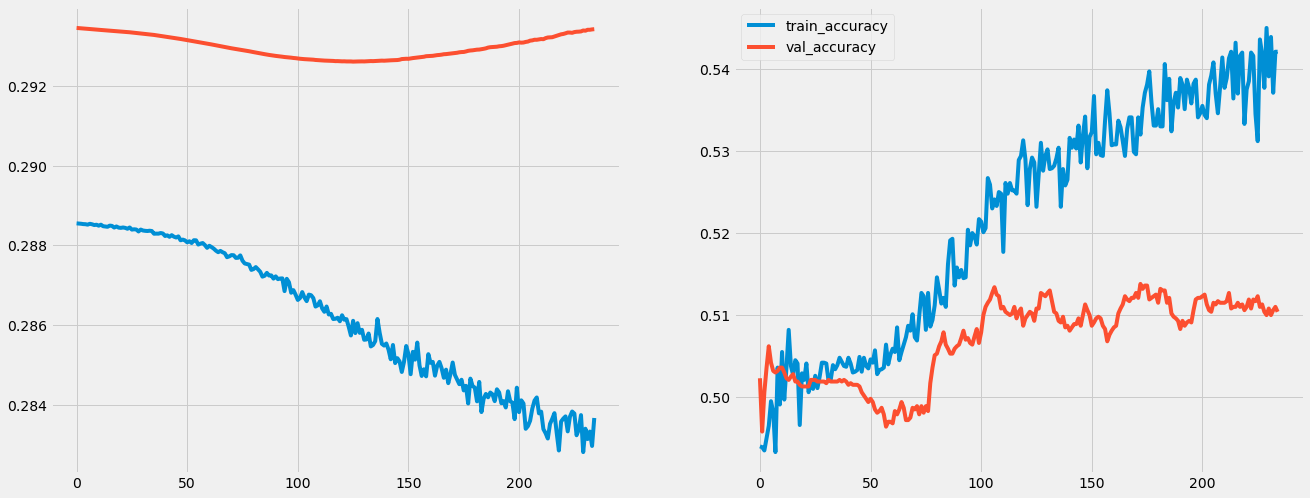

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')

axs[1].plot(train_accuracies, label='train_accuracy')
axs[1].plot(val_accuracies, label='val_accuracy')
plt.legend()
plt.show()

In [482]:
net2 =Net()

learning_rate = 0.000001
def my_loss(output, target):
    residual = (output-target).float()
    choicelist = [torch.where(output<=0, residual**2, 3*residual**2), torch.where(output<=0, 3*residual**2, residual**2)]
    loss = torch.where(target<=0, choicelist[0], choicelist[1])
#     loss = -torch.log(torch.sigmoid((torch.sign(target) * torch.clamp((output - target), -20, 20))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net2.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net2.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net2(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net2.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = net2(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 20 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 4.285663..  Test Loss: 4.377806..  Training Accuracy 0.510.. Validation Accuracy 0.503..
Epoch: 21/500..  Training Loss: 4.285192..  Test Loss: 4.377680..  Training Accuracy 0.512.. Validation Accuracy 0.501..
Epoch: 41/500..  Training Loss: 4.284325..  Test Loss: 4.377541..  Training Accuracy 0.509.. Validation Accuracy 0.503..
Epoch: 61/500..  Training Loss: 4.282853..  Test Loss: 4.377401..  Training Accuracy 0.517.. Validation Accuracy 0.502..
Epoch: 81/500..  Training Loss: 4.284114..  Test Loss: 4.377295..  Training Accuracy 0.510.. Validation Accuracy 0.501..
Epoch: 101/500..  Training Loss: 4.283797..  Test Loss: 4.377206..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 121/500..  Training Loss: 4.282302..  Test Loss: 4.377129..  Training Accuracy 0.512.. Validation Accuracy 0.500..
Epoch: 141/500..  Training Loss: 4.282051..  Test Loss: 4.377056..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 161/500..  Training Los

KeyboardInterrupt: 

In [493]:
train_outputs = np.array([])
train_outputs2 = np.array([])
train_targets = np.array([])
for data, target in train_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    train_outputs = np.concatenate([train_outputs, outputs.detach().numpy().flatten()])
    train_outputs2 = np.concatenate([train_outputs2, outputs2.detach().numpy().flatten()])

    train_targets = np.concatenate([train_targets, target.detach().numpy().flatten()])
# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
train_preds = pd.DataFrame({'preds':train_outputs, 'preds2':train_outputs2, 'target':train_targets})
# test_outputs.detach().numpy().flatten()
train_preds

preds    preds2  target
0     -1.569377 -0.411728     4.5
1      2.848549 -0.101551    -1.5
2     -0.019031 -0.067838     3.5
3      2.170247 -0.185665   -19.5
4     -3.343860 -0.671299   -10.0
...         ...       ...     ...
11767  0.601759  0.044105    28.5
11768  0.989692  0.048848   -13.5
11769  1.633067  0.119707   -20.5
11770  2.350058  0.031689    12.0
11771  0.950963 -0.028231    -9.0

[11772 rows x 3 columns]

In [481]:
train_preds['preds2'].describe()

count    11772.000000
mean        -0.051085
std          0.081908
min         -0.467047
25%         -0.102110
50%         -0.046459
75%          0.006428
max          0.208395
Name: preds2, dtype: float64

In [465]:
y_pred = net(data.float())

preds_df = pd.DataFrame({"y_true":target.detach().numpy().flatten(), "y_pred":y_pred.detach().numpy().flatten()})
preds_df

y_true    y_pred
0     -1.0 -0.362796
1      2.5  0.376909
2    -11.5  0.066797
3      3.0  0.101686
4     -9.5  0.647189
5     13.0  0.814767
6      8.5  0.058365
7     23.0  0.676957
8    -14.0  0.330269
9     20.0  1.236707
10    18.0  0.169000
11     7.5  1.259727
12    21.0  0.347002
13    30.0  0.505747
14    12.0  0.476720
15    25.5  0.541051
16    27.0  0.543965
17     1.5  0.216480
18   -19.5 -2.233496
19   -10.5 -1.027346
20     1.0  1.092786
21     9.0  0.106447
22    27.0  1.016205
23    28.5 -0.454392
24   -13.5  0.548404
25   -20.5  0.498868
26    12.0  1.003339
27    -9.0 -0.123695

In [494]:
test_outputs = np.array([])
test_outputs2 = np.array([])

for data, target in val_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])
    test_outputs2 = np.concatenate([test_outputs2, outputs2.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'preds2':test_outputs2, 'target':spread_point_diff_test_ewm_19})
# test_outputs.detach().numpy().flatten()

In [495]:
preds['bet_won'] = (np.sign(preds['preds']) == np.sign(preds['target'])).astype(int)
print(preds['bet_won'].mean())
preds['pred_probs'] = 1 / (1 + np.exp(-preds['preds']/10))
preds['pred_scaled'] = preds['preds']*10
preds['bet_home'] = (preds['preds'] > 0).astype(int)

0.5010620220900595


In [496]:
preds


preds    preds2  target  bet_won  pred_probs  pred_scaled  bet_home
11772  3.245110  0.129812   -10.5        0    0.580423    32.451100         1
11773 -5.352964 -0.005315    31.5        0    0.369282   -53.529644         0
11774 -0.912930 -0.088472    -3.5        1    0.477193    -9.129300         0
11775  2.345120  0.156321    13.5        1    0.558361    23.451197         1
11776 -0.504047 -0.434542    12.0        0    0.487401    -5.040472         0
...         ...       ...     ...      ...         ...          ...       ...
16475  3.186399  0.029901    -1.0        0    0.578993    31.863995         1
16476  1.176630  0.109124    20.5        1    0.529382    11.766295         1
16477  0.970830  0.048862     1.5        1    0.524252     9.708300         1
16478  1.041771  0.114306   -10.5        0    0.526021    10.417712         1
16479 -0.220044  0.011262    -7.5        1    0.494499    -2.200444         0

[4708 rows x 7 columns]

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.32
num_games_bet: 1623
win percetange at threshold: 0.5465187923598275


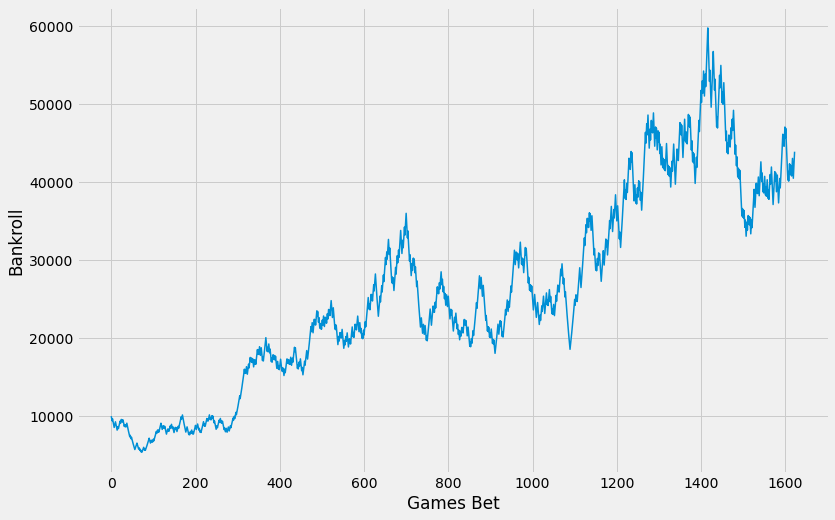

min balance: 5394.227702928191 
max balance: 59766.325969626225 
final balance: 42585.72589427221 
win percentage 54.65


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11772  2016-11-04 00:00:00     3.5            -14.0          3.245110   
1     11773  2016-11-04 00:00:00    11.5             20.0         -5.352964   
2     11775  2016-11-05 00:00:00    -3.5             17.0          2.345120   
3     11778  2016-11-05 00:00:00    -4.5            -24.0          2.687921   
4     11785  2016-11-07 00:00:00    -5.5             12.0         -6.921419   
...     ...                  ...     ...              ...               ...   
1618  16446  2020-09-04 00:00:00    -5.5            -15.0          3.672901   
1619  16448  2020-09-05 00:00:00    -9.0             -9.0         -4.396315   
1620  16450  2020-09-06 00:00:00    -6.0              8.0          2.686229   
1621  16464  2020-09-17 00:00:00    -3.0             -5.0         -4.081581   
1622  16475  2020-10-02 00:00:00   -11.0             10.0          3.186399   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n     bet_size  
0            0.0         1        0  10000.000000   9700.000000   300.000000  
1            1.0         0        0   9700.000000   9409.000000   291.000000  
2            1.0         1        1   9409.000000   9665.609091   282.270000  
3            0.0         1        0   9665.609091   9375.640818   289.968273  
4            1.0         0        0   9375.640818   9094.371594   281.269225  
...          ...       ...      ...           ...           ...          ...  
1618         0.0         1        0  41750.656697  40498.136996  1252.519701  
1619         0.0         0        1  40498.136996  41602.631641  1214.944110  
1620         1.0         1        1  41602.631641  42737.248868  1248.078949  
1621         0.0         0        1  42737.248868  43902.810200  1282.117466  
1622         0.0         1        0  43902.810200  42585.725894  1317.084306  

[1623 rows x 11 columns]

In [497]:
select_bets_nn, best_thresholds_nn = find_optimal_confidence_thresholds(test_outputs, test_indices)
simulate_bets(select_bets_nn)

In [459]:
(select_bets_nn['confidence_preds']>0).mean()

0.0

### Train NN on Full Data



In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0       2020-21      22020  1610612749               MIL   
1       2020-21      22020  1610612754               IND   
2       2020-21      22020  1610612755               PHI   
3       2020-21      22020  1610612737               ATL   
4       2020-21      22020  1610612750               MIN   
..          ...        ...         ...               ...   
598     2020-21      22020  1610612746               LAC   
599     2020-21      22020  1610612756               PHX   
600     2020-21      22020  1610612764               WAS   
601     2020-21      22020  1610612743               DEN   
602     2020-21      22020  1610612746               LAC   

                  TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Milwaukee Bucks  22000073 2021-01-01  MIL vs. CHI          1   
1            Indiana Pacers  22000080 2021-01-02  IND vs. NYK          1   
2        Philadelphia 76ers  22000082 2021-01-02  PHI vs. CHA          1   
3             Atlanta Hawks  22000083 2021-01-02  ATL vs. CLE          1   
4    Minnesota Timberwolves  22000088 2021-01-03  MIN vs. DEN          1   
..                      ...       ...        ...          ...        ...   
598             LA Clippers  22000717 2021-03-29  LAC vs. MIL          1   
599            Phoenix Suns  22000171 2021-03-30  PHX vs. ATL          1   
600      Washington Wizards  22000718 2021-03-30  WAS vs. CHA          1   
601          Denver Nuggets  22000719 2021-03-30  DEN vs. PHI          1   
602             LA Clippers  22000720 2021-03-30  LAC vs. ORL          1   

     SCORE_team  point_diff_team  WL_team  MIN_team  home_spread_mode  \
0           126               30        1       240             -14.5   
1           102               -4        0       240              -9.5   
2           127               15        1       240             -10.0   
3            91               -5        0       240              -5.5   
4           109              -15        0       240               8.5   
..          ...              ...      ...       ...               ...   
598         129               24        1       240               2.5   
599         117                7        1       240              -6.0   
600         104              -10        0       240               5.0   
601         104                9        1       240              -5.5   
602          96               -7        0       240             -11.5   

     WL_record_diff  ATS_record_diff  RECORD_team_diff  team_covered_diff  \
0          0.000000         0.000000         -0.066177          -0.044199   
1          0.400000         0.400000          0.362653           0.362653   
2          0.400000         0.200000          0.384630           0.224415   
3          0.200000         0.200000          0.244194           0.266172   
4          0.200000         0.200000          0.140436           0.140436   
..              ...              ...               ...                ...   
598        0.000484         0.119923         -0.058671           0.290187   
599        0.181818         0.181818          0.163215           0.222086   
600       -0.159091        -0.045455         -0.266612          -0.074674   
601       -0.086957        -0.086957         -0.027472          -0.061143   
602        0.340580         0.105072          0.481486           0.087948   

     FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0          1.011550        2.233474        3.260629        3.390149   
1          8.412029        2.926742        0.491954        1.743449   
2         -0.811116       -1.193304       -1.315426       -2.319015   
3         -4.651486      -12.189495        5.570072       12.611292   
4         -2.344070        1.994774       -0.061952        5.374765   
..              ...             ...             ...             ...   
598       -1.596767       -1.511494       -1.080255       -3.813030   


In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


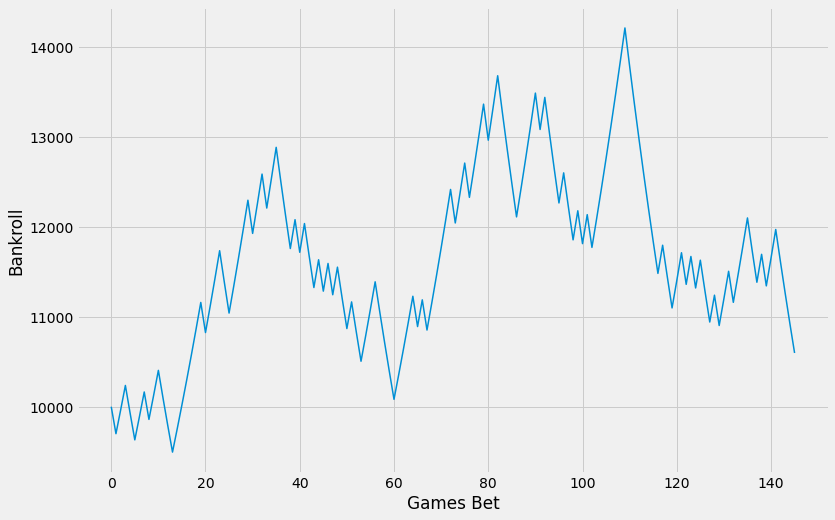

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        1               IND               -4  IND vs. NYK              -9.5   
1        5               DET               -2  DET vs. BOS               8.0   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4       10               PHX               -5  PHX vs. LAC               3.5   
..     ...               ...              ...          ...               ...   
141    573               TOR               -4  TOR vs. PHX               3.5   
142    577               NOP               -5  NOP vs. DEN               2.5   
143    587               TOR               -5  TOR vs. POR               2.5   
144    593               HOU              -10  HOU vs. MEM               8.0   
145    598               LAC               24  LAC vs. MIL               2.5   

     en_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0    3.723771           0         1        0  10000.000000  300.000000   
1    2.559869           1         1        1   9700.000000  291.000000   
2   -4.080041           0         0        1   9964.545455  298.936364   
3    3.573525           0         1        0  10236.305785  307.089174   
4    2.042165           0         1        0   9929.216612  297.876498   
..        ...         ...       ...      ...           ...         ...   
141  5.471833           0         1        0  11970.392977  359.111789   
142  2.881363           0         1        0  11611.281188  348.338436   
143  3.269273           0         1        0  11262.942752  337.888283   
144  3.477994           0         1        0  10925.054470  327.751634   
145  4.485047           1         1        1  10597.302836  317.919085   

       bankroll_n  
0     9700.000000  
1     9964.545455  
2    10236.305785  
3     9929.216612  
4     9631.340113  
..            ...  
141  11611.281188  
142  11262.942752  
143  10925.054470  
144  10597.302836  
145  10886.320186  

[146 rows x 12 columns]

In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

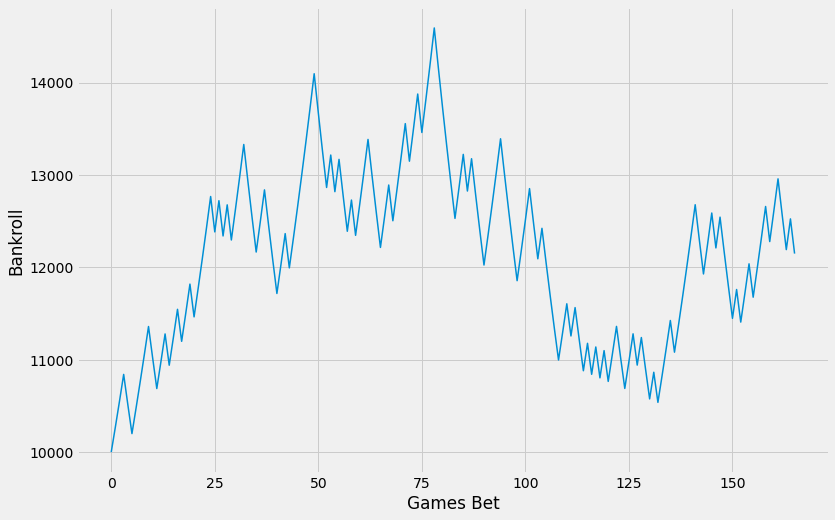

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        3               ATL               -5  ATL vs. CLE              -5.5   
1        4               MIN              -15  MIN vs. DEN               8.5   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4        8               SAS              -21  SAS vs. UTA               5.5   
..     ...               ...              ...          ...               ...   
161    548               MIL               27  MIL vs. IND              -7.0   
162    552               MIA              -10  MIA vs. PHX               2.0   
163    589               BOS               -6  BOS vs. NOP              -3.0   
164    593               HOU              -10  HOU vs. MEM               8.0   
165    596               UTA               39  UTA vs. CLE             -16.5   

     spread+diff  net_preds  home_cover  bet_home  bet_won    bankroll_i  \
0          -10.5  -7.630116           0         0        1  10000.000000   
1           -6.5 -17.511482           0         0        1  10272.727273   
2           -8.5 -24.358429           0         0        1  10552.892562   
3           -4.0  10.259763           0         1        0  10840.698723   
4          -15.5   8.119968           0         1        0  10515.477761   
..           ...        ...         ...       ...      ...           ...   
161         20.0  -7.958269           1         0        0  12957.206559   
162         -8.0   7.853865           0         1        0  12568.490362   
163         -9.0  -7.221478           0         0        1  12191.435651   
164         -2.0   8.024974           0         1        0  12523.929351   
165         22.5  -7.486481           1         0        0  12148.211470   

       bet_size    bankroll_n  
0    300.000000  10272.727273  
1    308.181818  10552.892562  
2    316.586777  10840.698723  
3    325.220962  10515.477761  
4    315.464333  10200.013428  
..          ...           ...  
161  388.716197  12568.490362  
162  377.054711  12191.435651  
163  365.743070  12523.929351  
164  375.717881  12148.211470  
165  364.446344  11783.765126  

[166 rows x 13 columns]

In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
14                MIL               10  MIL vs. DET             -16.0   
25                NOP               -1  NOP vs. OKC              -8.0   
28                MIL               15  MIL vs. DET             -12.0   
31                MIA               -2  MIA vs. BOS              -2.5   
40                POR               18  POR vs. MIN             -10.0   
49                BOS                9  BOS vs. WAS              -3.5   
56                MIN               -3  MIN vs. SAS               3.5   
61                HOU              -18  HOU vs. LAL               3.5   
62                NYK              -25  NYK vs. DEN               5.5   
63                LAC                3  LAC vs. CHI             -12.5   
103               POR                6  POR vs. ATL              -5.0   
104               DAL              -16  DAL vs. CHI              -6.5   
116               POR              -21  POR vs. SAS               1.5   
118               UTA               16  UTA vs. NOP              -6.5   
121               LAC               19  LAC vs. SAC             -11.0   
130               GSW              -15  GSW vs. NYK              -5.0   
157               CLE               -7  CLE vs. LAL              12.0   
165               UTA               14  UTA vs. NYK             -11.0   
229               CHA               -7  CHA vs. PHI               7.0   
246               PHI               16  PHI vs. BKN              -7.5   
269               UTA               14  UTA vs. BOS              -5.5   
272               NOP               29  NOP vs. HOU              -6.5   
306               DET               11  DET vs. NOP               5.5   
307               LAC               17  LAC vs. CLE              -9.0   
309               TOR               -4  TOR vs. MIN              -7.5   
316               GSW               31  GSW vs. CLE             -11.0   
348               MIL               13  MIL vs. OKC             -11.0   
352               POR               -7  POR vs. WAS              -4.5   
359               TOR                7  TOR vs. PHI               3.0   
365               UTA               22  UTA vs. CHA             -12.5   
370               LAC               19  LAC vs. WAS             -12.0   
379               UTA               25  UTA vs. LAL              -8.5   
380               PHX               -3  PHX vs. CHA              -9.5   
383               NOP               10  NOP vs. DET             -11.5   
410               HOU              -49  HOU vs. MEM               4.0   
420               HOU              -11  HOU vs. CLE              -3.0   
435               HOU              -18  HOU vs. BKN              10.5   
479               ATL               18  ATL vs. CLE              -5.5   
487               CHA                6  CHA vs. SAC              -3.5   
497               POR                1  POR vs. NOP              -2.0   
537               CLE               11  CLE vs. TOR               7.0   
548               MIL               27  MIL vs. IND              -7.0   
559               ORL                1  ORL vs. PHX               9.5   
572               DET               -2  DET vs. BKN               6.5   

     net_preds  home_cover  bet_home  bet_won  
14    0.176570           0         1        0  
25    0.033497           0         1        0  
28    0.113456           1         1        1  
31    0.000057           0         1        0  
40    0.032014           1         1        1  
49    0.029540           1         1        1  
56    0.087571           1         1        1  
61    0.029953           0         1        0  
62    0.009299           0         1        0  
63    0.000713           0         1        0  
103   0.007039           1         1        1  
104   0.024863           0         1        0  
116   0.015959           0         1        0  
118   0.011476           1         1        1 

In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [447]:
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.179463      -0.0744681        -0.130346   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0         0.0100565       0.771314        1.38298   -0.000764037   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0        3.60108       1.18658      0.615254        -0.3409       -3.48034   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -3.82125       3.28415       2.38366      0.670353      -2.05369   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      3.52316       2.72691            -0.580535              -0.945318   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              1.11265              -0.177191               1.1315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              -0.786312           -0.0324955        1.48803   -0.00496232   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.20019          3.19163               4.46767   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             2.72338           2.67205           -1.99951          0.718132   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.695025             3.30745        0.130346     -0.135756   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0       1.99365      0.416147       -3.4697      2.33052      2.30673   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00117765       2.07533      2.07415      2.90665     -2.29005   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.671452      3.54816    0.931445      3.30745            0.580535   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0             -0.177191              1.1315             -0.945318   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             1.11265              0.786312           0.0324955       1.81846   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00496232             1.39736         3.59304             -4.42725   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -1.72532          2.22005          -2.37193         0.657797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.346865         -0.0158015          0.017094          -0.017094   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0         0.0158015        -0.0326693        0.0326693       -0.0169042   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0238796        -0.0201873        0.0145145             2.89928   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.42549          -2.17765          2.81216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.386336    1326.610905    1406.997375           0.7

### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df